In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg
from brokenaxes import brokenaxes

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

beh_directory = 'Z:\\Behavioor'
#beh_directory = 'P:\\Behavioor'

#current_version = 0 # 6/22/23
current_version = 1 # 7/21/23
current_version = 2 # 7/24/23

In [2]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\Manuscript\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

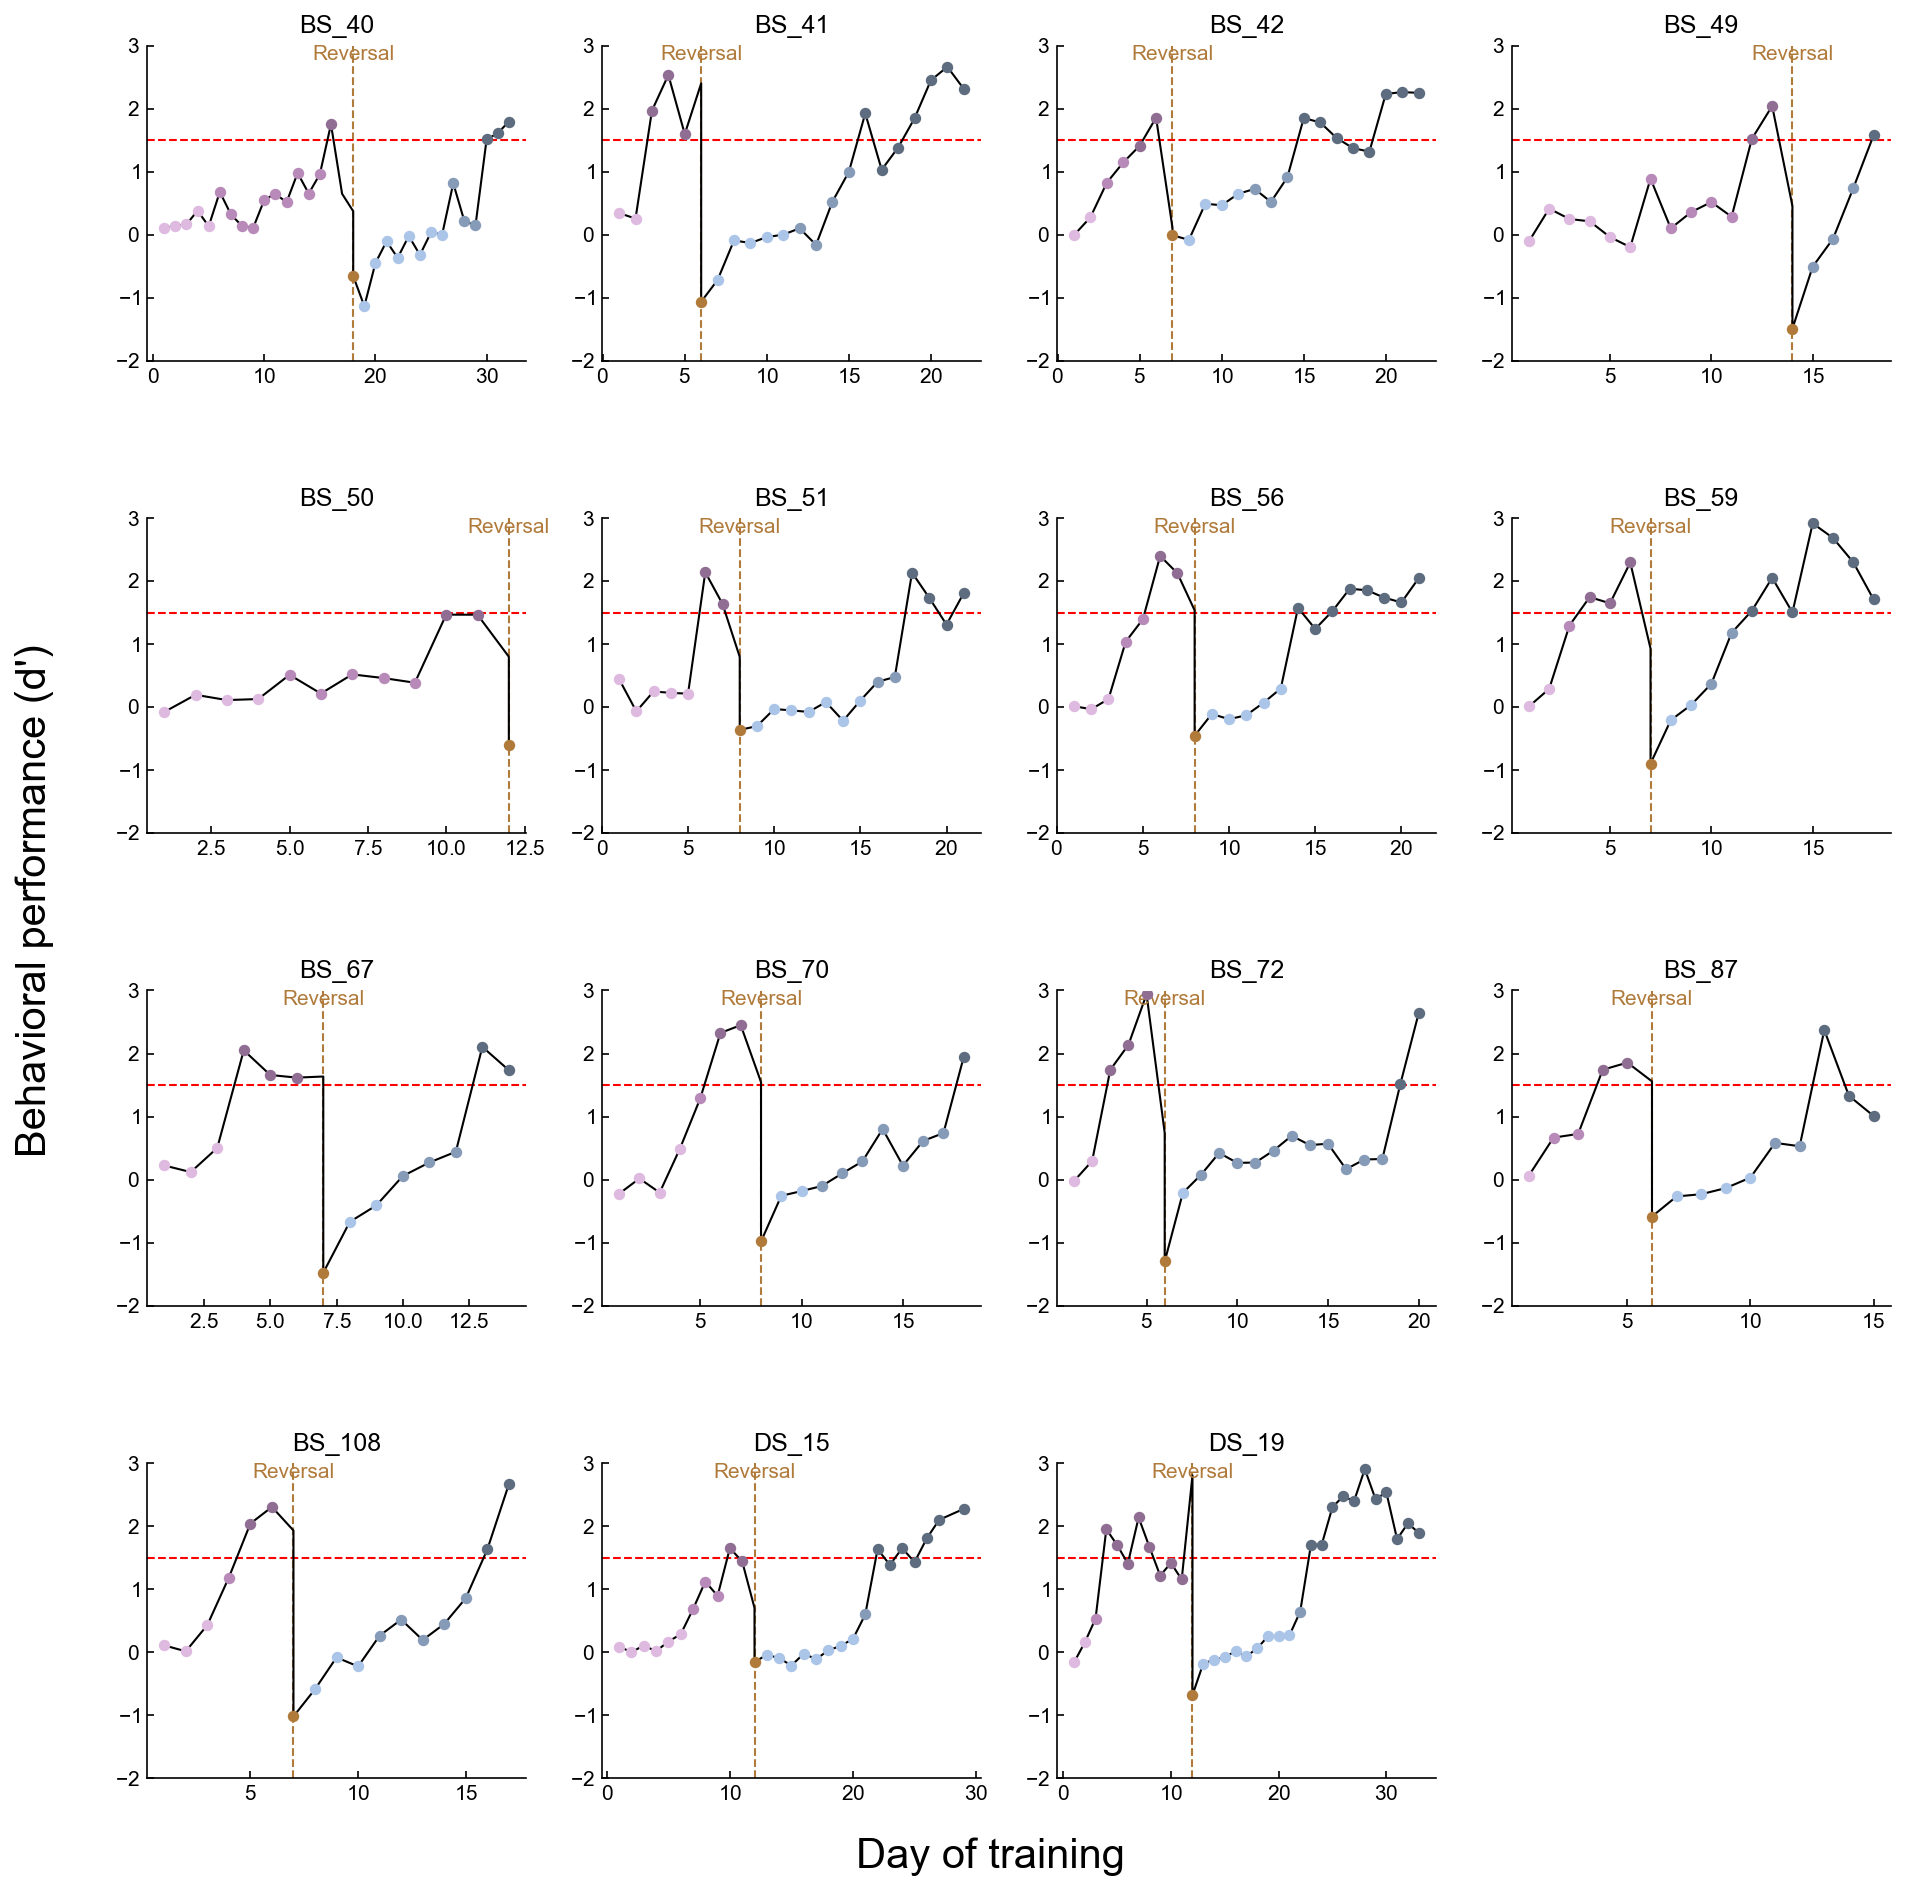

In [3]:
#animal = 'BS_108'
#animalPhases,_,_ = ilep.calculateLearningPhasesV2([animal],animalBehaviors,plot=True)
animalPhases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

In [4]:
animalPhases

{'BS_40': namespace(second_early_days=[],
           second_late_days=[],
           second_expert_days=[],
           post_early_days=array([19, 20, 21, 22, 23, 24, 25, 26]),
           post_late_days=array([27, 28, 29]),
           post_expert_days=array([30, 31, 32]),
           pre_early_days=array([1, 2, 3, 4, 5]),
           pre_late_days=array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
           pre_expert_days=array([16])),
 'BS_41': namespace(second_early_days=[],
           second_late_days=[],
           second_expert_days=[],
           post_early_days=array([ 7,  8,  9, 10, 11]),
           post_late_days=array([12, 13, 14, 15]),
           post_expert_days=array([16, 17, 18, 19, 20, 21, 22]),
           pre_early_days=array([1, 2]),
           pre_late_days=array([], dtype=int32),
           pre_expert_days=array([3, 4, 5])),
 'BS_42': namespace(second_early_days=[],
           second_late_days=[],
           second_expert_days=[],
           post_early_days=array([ 8,  

In [5]:
animalBehaviors['BS_108'].sessions[1].outcomes

0     1
1     1
2     1
3     1
4     1
     ..
93    2
94    2
95    4
96    4
97    4
Name: outcome, Length: 398, dtype: int64

In [6]:
# hit 1
# miss 2
# fa 3
# cr 4

In [76]:
#animal = 'BS_108'
animal = 'BS_70'

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0.10547308  0.01063495  0.42674176  1.18195369  2.03878793  2.30212246
 -1.02246561 -0.59084893 -0.08570874 -0.22906478  0.259121    0.51441997
  0.19019088  0.44518952  0.8541609   1.62785112  2.66146283]
7


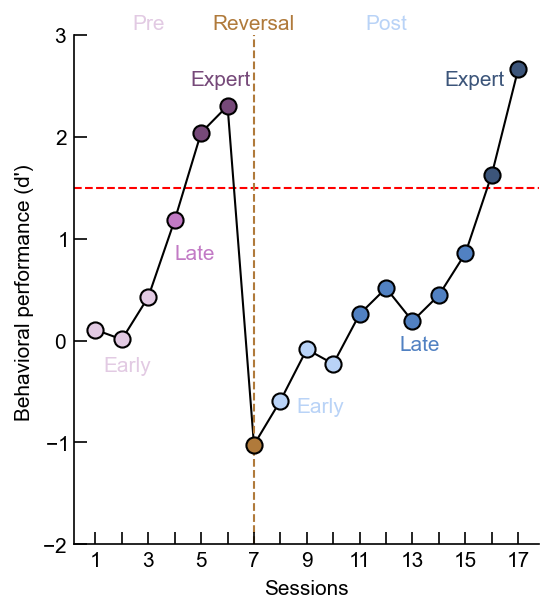

In [29]:
fig, ax = plt.subplots(figsize=(4,4.5))
PLOTTING_PHASE_COLORS = PHASE_COLORS


reversal = animalBehaviors[animal].reversal
days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)

days = np.sort(days)

print(days)
print(dp_list)

#All Days no color
ax.plot(days,dp_list,color='k',lw=1)

circle_size = 60

#Pre Early
pre_early = np.isin(days,animalPhases[animal].pre_early_days)
ax.scatter(days[pre_early],dp_list[pre_early],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10)

#Pre Late
pre_late = np.isin(days,animalPhases[animal].pre_late_days)
ax.scatter(days[pre_late],dp_list[pre_late],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10)
#ax.axhline(animalPreThresh[animal],c=PHASE_COLORS[1],linestyle='--',lw=1,zorder=-20)

#Pre Expert
pre_expert = np.isin(days,animalPhases[animal].pre_expert_days)
ax.scatter(days[pre_expert],dp_list[pre_expert],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10)

#Post Early
post_early = np.isin(days,animalPhases[animal].post_early_days)
ax.scatter(days[post_early],dp_list[post_early],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10)

#Post Late
post_late = np.isin(days,animalPhases[animal].post_late_days)
ax.scatter(days[post_late],dp_list[post_late],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10)
#ax.axhline(animalPostThresh[animal],c=PHASE_COLORS[4],linestyle='--',lw=1,zorder=-20)

#Post Expert
post_expert = np.isin(days,animalPhases[animal].post_expert_days)
ax.scatter(days[post_expert],dp_list[post_expert],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10)

#Switch
switch = np.equal(days,animalBehaviors[animal].reversal)
ax.scatter(days[switch],dp_list[switch],edgecolor = 'black',color=SWITCH_COLOR,s=circle_size,zorder=10)

ax.set_ylim([-2,3])
ax.set_yticks([-2,-1,0,1,2,3])
# ax.set_xlim([0,15])
ax.set_xticks(days)
ax.set_xticklabels(days)
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    labeledindex = [0,2,4,6,8,10,12,14,16]
    if index not in labeledindex:
        label.set_visible(False)
ax.tick_params(length=6)

ax.text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
ax.text(3,ax.get_ylim()[1]+0.2,'Pre',color=PLOTTING_PHASE_COLORS[0],horizontalalignment='center',verticalalignment='top')
ax.text(12,ax.get_ylim()[1]+0.2,'Post',color=PLOTTING_PHASE_COLORS[3],horizontalalignment='center',verticalalignment='top')

ax.axvline(reversal,c=SWITCH_COLOR,linestyle='--',lw=1)
ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
print(reversal)
ax.text(1.3,-0.3,'Early',color=PLOTTING_PHASE_COLORS[0])
ax.text(4,0.8,'Late',color=PLOTTING_PHASE_COLORS[1])
ax.text(4.6,2.5,'Expert',color=PLOTTING_PHASE_COLORS[2])
ax.text(8.6,-0.7,'Early',color=PLOTTING_PHASE_COLORS[3])
ax.text(12.5,-0.1,'Late',color=PLOTTING_PHASE_COLORS[4])
ax.text(14.2,2.5,'Expert',color=PLOTTING_PHASE_COLORS[5])

#days_recorded = training_days_recorded[animal]
#ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)
#ax.set_title(animal)
ax.set_ylabel("Behavioral performance (d') ")
ax.set_xlabel('Sessions')
ax.set_axisbelow(False)
#days_recorded = training_days_recorded[animal]
#ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript','example learning curve BS_108 v0.pdf'),transparent=False,facecolor="white")

In [61]:
range(0,4)

range(0, 4)

In [8]:
animals

['BS_40',
 'BS_41',
 'BS_42',
 'BS_49',
 'BS_50',
 'BS_51',
 'BS_56',
 'BS_59',
 'BS_67',
 'BS_70',
 'BS_72',
 'BS_87',
 'BS_108',
 'DS_15',
 'DS_19']

In [108]:
animal = 'BS_108'

7
17
7


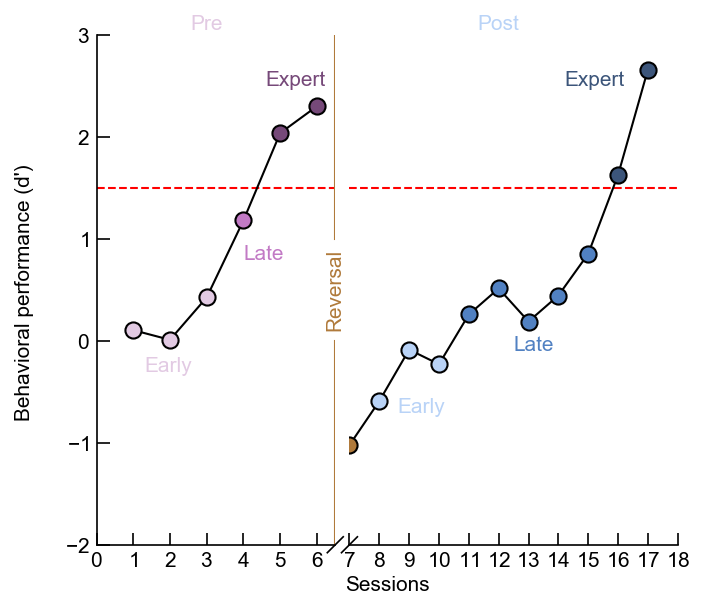

In [114]:
rev = animalBehaviors[animal].reversal
max_day = len(animalBehaviors[animal].sessions)
print(rev)
print(max_day)

fig = plt.figure(figsize=(5,4.5))
bax = brokenaxes(xlims=( (0,rev-0.5), (rev, max_day+1) ), width_ratios=[rev+1,max_day+1-rev], wspace=0.05)
PLOTTING_PHASE_COLORS = PHASE_COLORS


reversal = animalBehaviors[animal].reversal
days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)

days = np.sort(days)

#All Days no color
bax.plot(days[0:rev-1],dp_list[0:rev-1],color='k',lw=1)
bax.plot(days[rev-1:max_day],dp_list[rev-1:max_day],color='k',lw=1)

circle_size = 60

#Pre Early
pre_early = np.isin(days,animalPhases[animal].pre_early_days)
bax.scatter(days[pre_early],dp_list[pre_early],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10)

#Pre Late
pre_late = np.isin(days,animalPhases[animal].pre_late_days)
bax.scatter(days[pre_late],dp_list[pre_late],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10)
#ax.axhline(animalPreThresh[animal],c=PHASE_COLORS[1],linestyle='--',lw=1,zorder=-20)

#Pre Expert
pre_expert = np.isin(days,animalPhases[animal].pre_expert_days)
bax.scatter(days[pre_expert],dp_list[pre_expert],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10)

#Post Early
post_early = np.isin(days,animalPhases[animal].post_early_days)
bax.scatter(days[post_early],dp_list[post_early],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10)

#Post Late
post_late = np.isin(days,animalPhases[animal].post_late_days)
bax.scatter(days[post_late],dp_list[post_late],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10)
#ax.axhline(animalPostThresh[animal],c=PHASE_COLORS[4],linestyle='--',lw=1,zorder=-20)

#Post Expert
post_expert = np.isin(days,animalPhases[animal].post_expert_days)
bax.scatter(days[post_expert],dp_list[post_expert],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10)

#Switch
switch = np.equal(days,animalBehaviors[animal].reversal)
bax.axs[1].scatter(days[switch],dp_list[switch],edgecolor = 'black',color=SWITCH_COLOR,s=circle_size,zorder=10)

bax.set_ylim([-2,3])
bax.set_yticks([-2,-1,0,1,2,3])
#bax.set_xlim([0,15])
bax.axs[0].set_xticks([0,1,2,3,4,5,6])
#bax.axs[0].set_xticklabels(list(range(rev+1)))
bax.axs[1].set_xticks(range(rev+1,max_day+1))
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    labeledindex = [0,2,4,6,8,10,12,14,16]
    if index not in labeledindex:
        label.set_visible(False)
bax.tick_params(length=6)

#bax.axs[0].text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
size = 0.5
center = np.mean(bax.axs[0].get_ylim())
bax.axs[0].text(reversal-0.5,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
bax.axs[0].plot([rev-0.5,rev-0.5],[bax.axs[0].get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
bax.axs[0].plot([rev-0.5,rev-0.5],[center+size,bax.axs[0].get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

bax.axs[0].text(3,bax.axs[0].get_ylim()[1]+0.2,'Pre',color=PLOTTING_PHASE_COLORS[0],horizontalalignment='center',verticalalignment='top')
bax.axs[1].text(12,bax.axs[0].get_ylim()[1]+0.2,'Post',color=PLOTTING_PHASE_COLORS[3],horizontalalignment='center',verticalalignment='top')

#bax.axs[0].axvline(reversal,c=SWITCH_COLOR,linestyle='-',lw=1)
bax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
print(reversal)
bax.axs[0].text(1.3,-0.3,'Early',color=PLOTTING_PHASE_COLORS[0])
bax.axs[0].text(4,0.8,'Late',color=PLOTTING_PHASE_COLORS[1])
bax.axs[0].text(4.6,2.5,'Expert',color=PLOTTING_PHASE_COLORS[2])
bax.axs[1].text(8.6,-0.7,'Early',color=PLOTTING_PHASE_COLORS[3])
bax.axs[1].text(12.5,-0.1,'Late',color=PLOTTING_PHASE_COLORS[4])
bax.axs[1].text(14.2,2.5,'Expert',color=PLOTTING_PHASE_COLORS[5])

bax.set_ylabel("Behavioral performance (d') ")
bax.set_xlabel('Sessions')
bax.set_axisbelow(False)
#days_recorded = training_days_recorded[animal]
#ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript','example learning curve BS_108 v0.pdf'),transparent=False,facecolor="white")

#These must be changed at the end. brokenaxes recalculates ticks for several calls
bax.axs[0].set_xticks(range(rev))
bax.axs[1].set_xticks(range(rev,max_day+2))
# bax.axs[0].set_xticklabels([0,'',2,'',4,'',6])
# bax.axs[1].set_xticklabels(['',8,'',10,'',12,'',14,'',16,'',18])

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Example learning curve broken axes V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

### V2

In [5]:
animal = 'BS_108'

7
17
[ 0.10547308  0.01063495  0.42674176  1.18195369  2.03878793  2.30212246
 -1.02246561 -0.59084893 -0.08570874 -0.22906478  0.259121    0.51441997
  0.19019088  0.44518952  0.8541609   1.62785112  2.66146283]
7


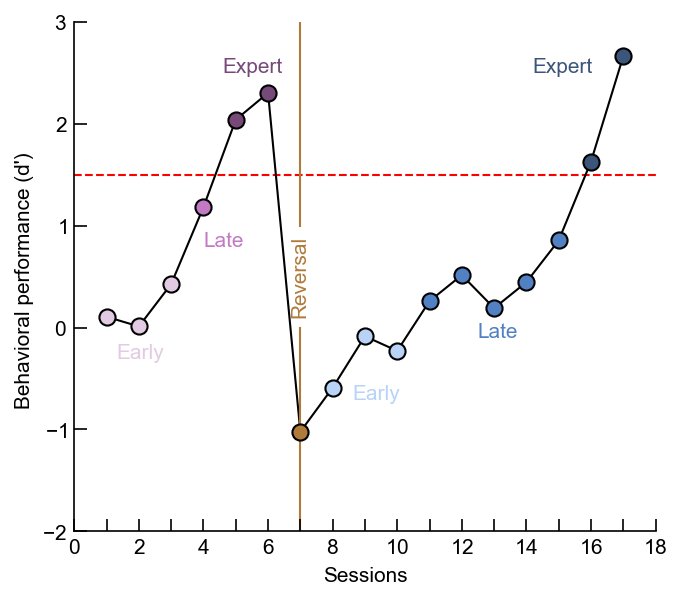

In [8]:
rev = animalBehaviors[animal].reversal
max_day = len(animalBehaviors[animal].sessions)
print(rev)
print(max_day)

fig, ax = plt.subplots(figsize=(5,4.5))
PLOTTING_PHASE_COLORS = PHASE_COLORS


reversal = animalBehaviors[animal].reversal
days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)

print(dp_list)

days = np.sort(days)

#All Days no color
# ax.plot(days[0:rev-1],dp_list[0:rev-1],color='k',lw=1)
# ax.plot(days[rev-1:max_day],dp_list[rev-1:max_day],color='k',lw=1)
ax.plot(days,dp_list,color='k',lw=1)

circle_size = 60

#Pre Early
pre_early = np.isin(days,animalPhases[animal].pre_early_days)
ax.scatter(days[pre_early],dp_list[pre_early],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10)

#Pre Late
pre_late = np.isin(days,animalPhases[animal].pre_late_days)
ax.scatter(days[pre_late],dp_list[pre_late],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10)
#ax.axhline(animalPreThresh[animal],c=PHASE_COLORS[1],linestyle='--',lw=1,zorder=-20)

#Pre Expert
pre_expert = np.isin(days,animalPhases[animal].pre_expert_days)
ax.scatter(days[pre_expert],dp_list[pre_expert],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10)

#Post Early
post_early = np.isin(days,animalPhases[animal].post_early_days)
ax.scatter(days[post_early],dp_list[post_early],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10)

#Post Late
post_late = np.isin(days,animalPhases[animal].post_late_days)
ax.scatter(days[post_late],dp_list[post_late],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10)
#ax.axhline(animalPostThresh[animal],c=PHASE_COLORS[4],linestyle='--',lw=1,zorder=-20)

#Post Expert
post_expert = np.isin(days,animalPhases[animal].post_expert_days)
ax.scatter(days[post_expert],dp_list[post_expert],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10)

#Switch
switch = np.equal(days,animalBehaviors[animal].reversal)
ax.scatter(days[switch],dp_list[switch],edgecolor = 'black',color=SWITCH_COLOR,s=circle_size,zorder=10)

ax.set_ylim([-2,3])
ax.set_yticks([-2,-1,0,1,2,3])
#bax.set_xlim([0,15])
#bax.axs[0].set_xticklabels(list(range(rev+1)))
ax.set_xticks(range(0,max_day+1))
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    labeledindex = [0,2,4,6,8,10,12,14,16,18]
    if index not in labeledindex:
        label.set_visible(False)
ax.tick_params(length=6)

#bax.axs[0].text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
size = 0.5
center = np.mean(ax.get_ylim())
ax.text(reversal,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

#ax.text(3,bax.axs[0].get_ylim()[1]+0.2,'Pre',color=PLOTTING_PHASE_COLORS[0],horizontalalignment='center',verticalalignment='top')
#ax.text(12,bax.axs[0].get_ylim()[1]+0.2,'Post',color=PLOTTING_PHASE_COLORS[3],horizontalalignment='center',verticalalignment='top')

#bax.axs[0].axvline(reversal,c=SWITCH_COLOR,linestyle='-',lw=1)
ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
print(reversal)
ax.text(1.3,-0.3,'Early',color=PLOTTING_PHASE_COLORS[0])
ax.text(4,0.8,'Late',color=PLOTTING_PHASE_COLORS[1])
ax.text(4.6,2.5,'Expert',color=PLOTTING_PHASE_COLORS[2])
ax.text(8.6,-0.7,'Early',color=PLOTTING_PHASE_COLORS[3])
ax.text(12.5,-0.1,'Late',color=PLOTTING_PHASE_COLORS[4])
ax.text(14.2,2.5,'Expert',color=PLOTTING_PHASE_COLORS[5])

ax.set_ylabel("Behavioral performance (d') ")
ax.set_xlabel('Sessions')
ax.set_axisbelow(False)
#days_recorded = training_days_recorded[animal]
#ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript','example learning curve BS_108 v0.pdf'),transparent=False,facecolor="white")

#These must be changed at the end. brokenaxes recalculates ticks for several calls
ax.set_xticks(range(0,max_day+2))
# bax.axs[0].set_xticklabels([0,'',2,'',4,'',6])
# bax.axs[1].set_xticklabels(['',8,'',10,'',12,'',14,'',16,'',18])

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Example learning curve broken axes V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [7]:
animalBehaviors['BS_108'].sessions[7]

namespace(animal='BS_108',
          session=7,
          files=array(['BS_108_7v1.txt', 'BS_108_7v2_reversal.txt',
                       'BS_108_7v3_reversal.txt', 'BS_108_7v4_reversal.txt'], dtype='<U23'),
          blocknumbers=array([1, 2, 3, 4]),
          type='switch',
          trials_per_session=array([200., 100.,  63.,  72.]),
          outcomes=0     1
                   1     1
                   2     1
                   3     1
                   4     1
                        ..
                   67    4
                   68    4
                   69    2
                   70    2
                   71    4
                   Name: outcome, Length: 435, dtype: int64,
          tones=0     11260
                1     11260
                2     11260
                3     11260
                4     11260
                      ...  
                67    11260
                68    11260
                69     5648
                70     5648
                71    

# Plot for Fig1

In [74]:
stdfont = 14
stdyfrac = 0.06

In [75]:
animal = 'BS_59'

reversal = animalBehaviors[animal].reversal
days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)
days = np.sort(days)

pc = pc_list*100
miss_fa = 100 - pc

In [76]:
pc

array([51.51515152, 55.7312253 , 68.        , 75.47169811, 79.16666667,
       74.46808511, 41.        , 47.81021898, 51.85714286, 52.        ,
       67.5       , 76.82926829, 69.64285714, 74.07407407, 82.07070707,
       78.4660767 , 73.72881356, 79.00552486])

7
18
[1 2 3 4 5 6]
[ 7  8  9 10 11 12 13 14 15]


meta NOT subset; don't know how to subset; dropped


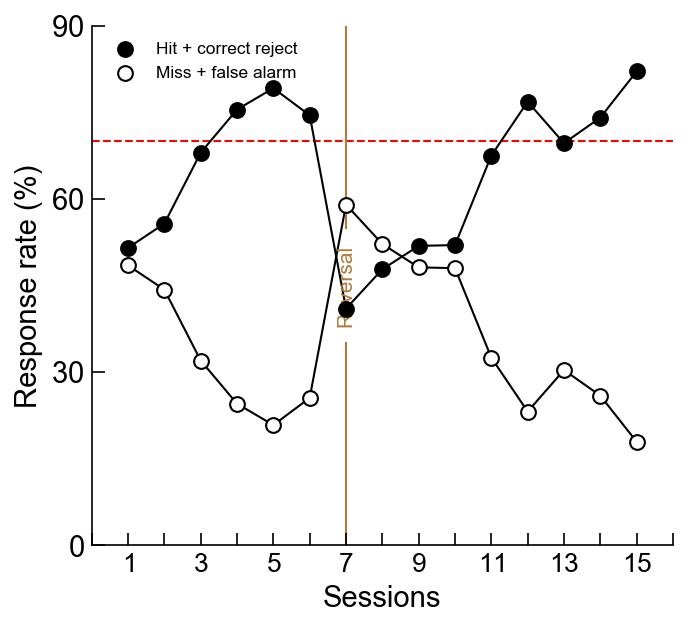

In [77]:
rev = animalBehaviors[animal].reversal
max_day = len(animalBehaviors[animal].sessions)
print(rev)
print(max_day)
max_day = 15

fig, ax = plt.subplots(figsize=(5,4.5))

circle_color = 'black'
circle_size = 50

ax.plot(days[0:max_day],pc[0:max_day],color=circle_color,lw=1)
ax.scatter(days[0:rev-1],pc[0:rev-1],color=circle_color,s=circle_size,label='Hit + correct reject',zorder=10)
ax.scatter(days[rev-1:max_day],pc[rev-1:max_day],color=circle_color,s=circle_size,zorder=10)

ax.plot(days[0:max_day],miss_fa[0:max_day],color=circle_color,lw=1)
ax.scatter(days[0:rev-1],miss_fa[0:rev-1],facecolors='white', edgecolor=circle_color,s=circle_size,label='Miss + false alarm',zorder=9)
ax.scatter(days[rev-1:max_day],miss_fa[rev-1:max_day],facecolors='white', edgecolor=circle_color,s=circle_size,zorder=9)

ax.set_xlim([0,max_day])
ax.set_ylim([0,90])
ax.set_yticks([0,30,60,90])

ax.set_xticks(range(0,max_day+2))
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    labeledindex = [1,3,5,7,9,11,13,15,17,19,21]
    if index not in labeledindex:
        label.set_visible(False)

size = 10
center = np.mean(ax.get_ylim())
ax.text(reversal,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
        
ax.tick_params(length=6)
ax.legend(frameon = False)

ax.axhline(70,c='r',linestyle='--',lw=1,zorder=-10)
ax.set_ylabel("Response rate (%)")
ax.set_xlabel("Sessions")
ax.tick_params(length=6)
ax.set_axisbelow(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

print(days[0:rev-1])
print(days[rev-1:max_day])

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\response rate example.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

In [78]:
animal='BS_108'

In [98]:
def animal_learning_curve(animal):
    rev = animalBehaviors[animal].reversal
    max_day = len(animalBehaviors[animal].sessions)
    print(rev)
    print(max_day)

    fig, ax = plt.subplots(figsize=(5,4.5))
    PLOTTING_PHASE_COLORS = PHASE_COLORS


    reversal = animalBehaviors[animal].reversal
    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)

    print(dp_list)

    days = np.sort(days)

    ax.plot(days,dp_list,color='k',lw=1)

    circle_size = 60

    #Pre Early
    pre_early = np.isin(days,animalPhases[animal].pre_early_days)
    ax.scatter(days[pre_early],dp_list[pre_early],color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10)

    #Pre Late
    pre_late = np.isin(days,animalPhases[animal].pre_late_days)
    ax.scatter(days[pre_late],dp_list[pre_late],color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10)

    #Pre Expert
    pre_expert = np.isin(days,animalPhases[animal].pre_expert_days)
    ax.scatter(days[pre_expert],dp_list[pre_expert],color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10)

    #Post Early
    post_early = np.isin(days,animalPhases[animal].post_early_days)
    ax.scatter(days[post_early],dp_list[post_early],color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10)

    #Post Late
    post_late = np.isin(days,animalPhases[animal].post_late_days)
    ax.scatter(days[post_late],dp_list[post_late],color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10)

    #Post Expert
    post_expert = np.isin(days,animalPhases[animal].post_expert_days)
    ax.scatter(days[post_expert],dp_list[post_expert],color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10)

    #Switch
    switch = np.equal(days,animalBehaviors[animal].reversal)
    ax.scatter(days[switch],dp_list[switch],color=SWITCH_COLOR,s=circle_size,zorder=10)

    ax.set_ylim([-2,3])
    ax.set_yticks([-2,-1,0,1,2,3])

    ax.set_xticks(range(0,max_day+2))
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        #labeledindex = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41]
        labeledindex = [1,5,9,13,17,21,25,29,33,37,41]
        if index not in labeledindex:
            label.set_visible(False)
            
    ax.tick_params(length=6)

    size = 0.5
    center = np.mean(ax.get_ylim())
    ax.text(reversal,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
    ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
    ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

    ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
    print(reversal)
    ax.text(1.3,-0.3,'Early',color=PLOTTING_PHASE_COLORS[0])
    ax.text(4,0.8,'Late',color=PLOTTING_PHASE_COLORS[1])
    ax.text(4.6,2.5,'Expert',color=PLOTTING_PHASE_COLORS[2])
    ax.text(8.6,-0.7,'Early',color=PLOTTING_PHASE_COLORS[3])
    ax.text(12.5,-0.1,'Late',color=PLOTTING_PHASE_COLORS[4])
    ax.text(14.2,2.5,'Expert',color=PLOTTING_PHASE_COLORS[5])

    ax.set_ylabel("Behavioral performance (d') ")
    ax.set_xlabel('Sessions')
    ax.set_axisbelow(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    #These must be changed at the end. brokenaxes recalculates ticks for several calls
    ax.set_xticks(range(0,max_day+2))
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(stdfont)
    for item in (ax.get_xticklabels()):
        item.set_fontsize(stdfont*0.9)
        pass
    
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\DS_19.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\DS_15.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\BS_40.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\BS_108.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript\\Learning'+animal+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

18
32
[ 1.01438707e-01  1.37470570e-01  1.61147678e-01  3.78100509e-01
  1.30667995e-01  6.75951955e-01  3.18152223e-01  1.33781642e-01
  1.05435139e-01  5.50061203e-01  6.47293906e-01  5.10515631e-01
  9.75839714e-01  6.49997918e-01  9.57439193e-01  1.75068607e+00
  6.45937118e-01 -6.59639262e-01 -1.13769046e+00 -4.53113066e-01
 -1.08914779e-01 -3.70657876e-01 -2.38342777e-02 -3.23904626e-01
  3.34667380e-02 -4.04163274e-04  8.12577505e-01  2.11904642e-01
  1.45051104e-01  1.51000976e+00  1.60662307e+00  1.79314022e+00]
18


meta NOT subset; don't know how to subset; dropped


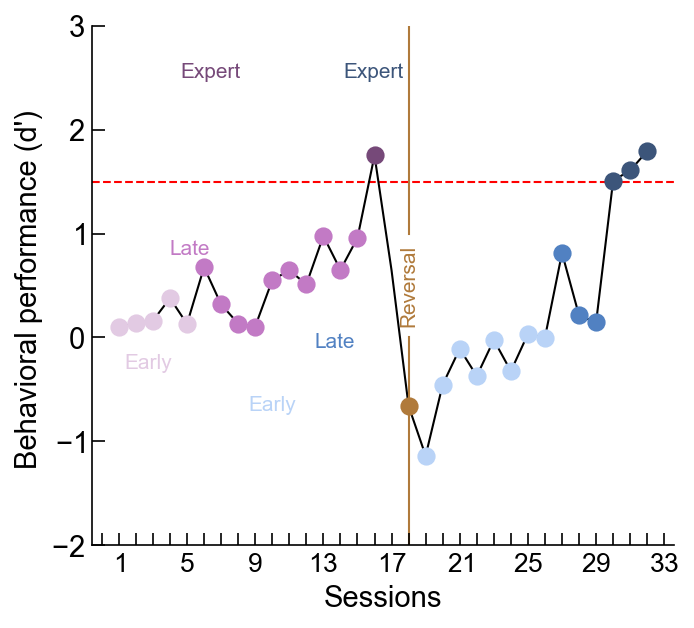

In [91]:
animal_learning_curve('BS_40')

12
28
[ 8.61384603e-02 -2.03034477e-03  1.02573122e-01  1.24458778e-02
  1.66176832e-01  2.80655963e-01  6.77793926e-01  1.11823327e+00
  8.91058914e-01  1.64894905e+00  1.43690184e+00 -1.59863879e-01
 -4.39018317e-02 -9.66780688e-02 -2.14399004e-01 -2.62007477e-02
 -1.13345688e-01  2.57492042e-02  9.80004420e-02  2.06937891e-01
  5.96598535e-01  1.63211448e+00  1.38231055e+00  1.64888276e+00
  1.42622532e+00  1.80425555e+00  2.09754363e+00  2.27182246e+00]
12


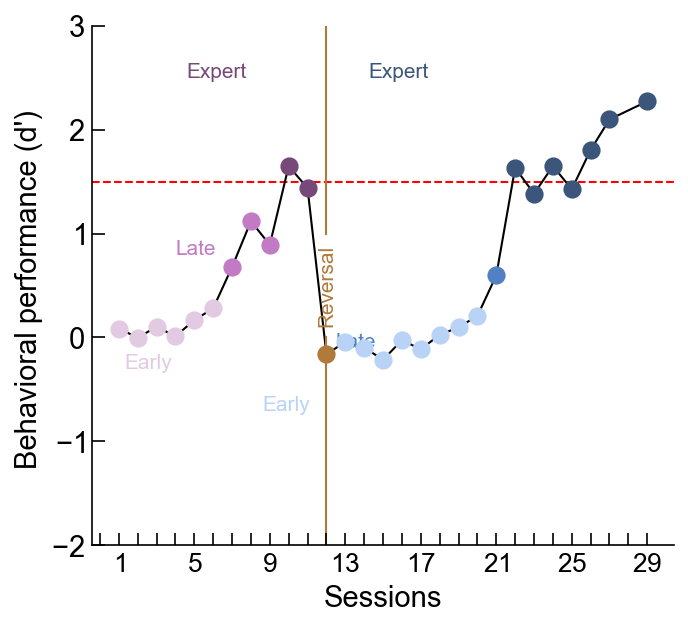

In [99]:
animal_learning_curve('DS_15')

12
33
[-0.16578112  0.15170629  0.529155    1.94855364  1.69923938  1.40452733
  2.13504722  1.66853941  1.21247435  1.41318373  1.15120421 -0.6835115
 -0.18323683 -0.12367374 -0.08483057  0.01520004 -0.06826717  0.05689732
  0.24704236  0.26028947  0.26275998  0.63923063  1.69955042  1.70571958
  2.30119323  2.47158419  2.39360896  2.90330358  2.42612572  2.5356624
  1.79180131  2.04154811  1.89442177]
12


meta NOT subset; don't know how to subset; dropped


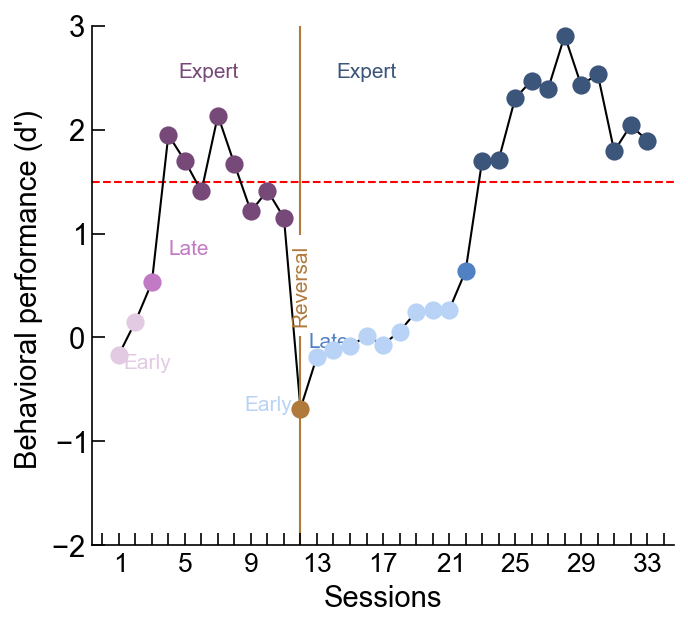

In [95]:
animal_learning_curve('DS_19')

7
17
[ 0.10547308  0.01063495  0.42674176  1.18195369  2.03878793  2.30212246
 -1.02246561 -0.59084893 -0.08570874 -0.22906478  0.259121    0.51441997
  0.19019088  0.44518952  0.8541609   1.62785112  2.66146283]
7


meta NOT subset; don't know how to subset; dropped


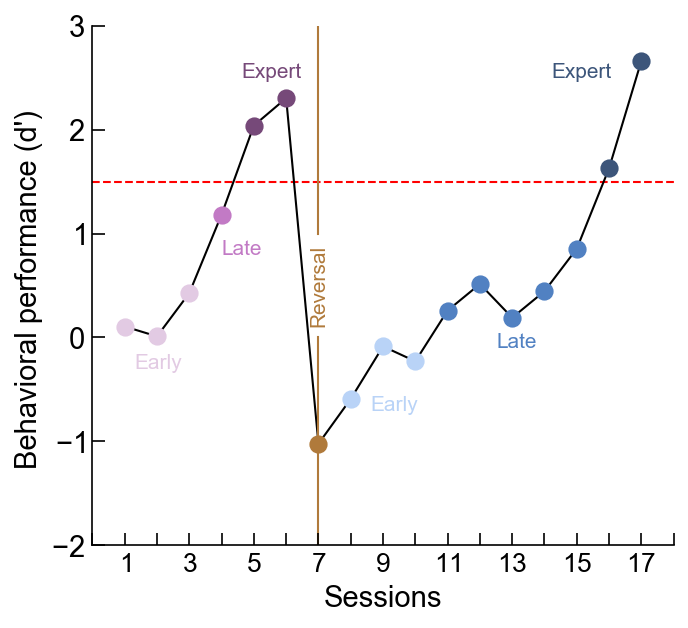

In [80]:
animal_learning_curve(animal)

18
32
[ 1.01438707e-01  1.37470570e-01  1.61147678e-01  3.78100509e-01
  1.30667995e-01  6.75951955e-01  3.18152223e-01  1.33781642e-01
  1.05435139e-01  5.50061203e-01  6.47293906e-01  5.10515631e-01
  9.75839714e-01  6.49997918e-01  9.57439193e-01  1.75068607e+00
  6.45937118e-01 -6.59639262e-01 -1.13769046e+00 -4.53113066e-01
 -1.08914779e-01 -3.70657876e-01 -2.38342777e-02 -3.23904626e-01
  3.34667380e-02 -4.04163274e-04  8.12577505e-01  2.11904642e-01
  1.45051104e-01  1.51000976e+00  1.60662307e+00  1.79314022e+00]
18


meta NOT subset; don't know how to subset; dropped


6
22
[ 3.39091644e-01  2.53561762e-01  1.96616793e+00  2.53234923e+00
  1.59387834e+00 -1.06692473e+00 -7.21861241e-01 -9.39984859e-02
 -1.35522963e-01 -4.07337237e-02 -2.58815788e-03  9.83928600e-02
 -1.64883802e-01  5.22237339e-01  9.94343648e-01  1.92294445e+00
  1.02747369e+00  1.37988470e+00  1.84349751e+00  2.44791545e+00
  2.66195058e+00  2.31262547e+00]
6


meta NOT subset; don't know how to subset; dropped


7
22
[-0.01042846  0.27330672  0.82267555  1.14305708  1.40833     1.85547589
 -0.01141025 -0.08588091  0.48846321  0.46395537  0.64516613  0.72354488
  0.51729442  0.90687867  1.84798855  1.77937662  1.53244044  1.37054047
  1.31545891  2.23160584  2.2599773   2.24867193]
7


meta NOT subset; don't know how to subset; dropped


14
18
[-0.11003674  0.41087968  0.24592819  0.20910164 -0.04103203 -0.20045666
  0.88579171  0.09791022  0.35506672  0.51495689  0.28147675  1.5188584
  2.03980726 -1.49267521 -0.51041583 -0.06887862  0.73320061  1.5721089 ]
14


meta NOT subset; don't know how to subset; dropped


12
12
[-0.07923552  0.19363     0.10976742  0.12618768  0.51066348  0.21341921
  0.51772575  0.45916083  0.38514331  1.46569067  1.46474463 -0.59842679]
12


meta NOT subset; don't know how to subset; dropped


8
21
[ 0.44108849 -0.06961766  0.24720434  0.22381911  0.21162565  2.13895803
  1.63634123 -0.36346292 -0.30321284 -0.03215041 -0.05386281 -0.0783368
  0.0782116  -0.21830623  0.10280486  0.39996163  0.47616062  2.13314312
  1.73219928  1.30808593  1.8081935 ]
8


meta NOT subset; don't know how to subset; dropped


8
21
[ 0.01307263 -0.03547696  0.12648658  1.03616409  1.3948341   2.39778481
  2.12321018 -0.45631639 -0.11041236 -0.19386323 -0.12960754  0.06764879
  0.29338906  1.57510456  1.23857784  1.52405519  1.87688788  1.85330874
  1.73627152  1.65886098  2.04357357]
8


meta NOT subset; don't know how to subset; dropped


7
18
[ 0.00829425  0.28796781  1.29335178  1.7453422   1.64524616  2.29411814
 -0.89764928 -0.20880529  0.03228668  0.36903883  1.17757411  1.52851681
  2.05102631  1.50108595  2.91488527  2.68367447  2.29772722  1.70926982]
7


meta NOT subset; don't know how to subset; dropped


7
14
[ 0.22333219  0.117072    0.50096659  2.0509076   1.65882123  1.6170513
 -1.47968652 -0.67227476 -0.41145554  0.05513363  0.27000882  0.44023325
  2.10546337  1.73469222]
7


meta NOT subset; don't know how to subset; dropped


8
18
[-0.22602724  0.01606811 -0.20800805  0.49016044  1.28604105  2.32682891
  2.44962099 -0.98391879 -0.25886575 -0.18376031 -0.10315011  0.0957528
  0.28730823  0.80142998  0.22019886  0.61274793  0.73711856  1.94579188]
8


meta NOT subset; don't know how to subset; dropped


6
20
[-0.02433998  0.29368628  1.74103614  2.13742629  2.94047358 -1.30134314
 -0.21241968  0.07382095  0.42205212  0.26361124  0.26937776  0.45895196
  0.69374891  0.54618644  0.5680109   0.16376591  0.31701882  0.32607074
  1.52371705  2.63730633]
6


meta NOT subset; don't know how to subset; dropped


6
15
[ 0.06326055  0.66478826  0.72324915  1.74206027  1.85544654 -0.58730401
 -0.26887854 -0.23360435 -0.13598467  0.03032988  0.58124835  0.52811649
  2.37170598  1.32895248  1.00982167]
6


meta NOT subset; don't know how to subset; dropped


7
17
[ 0.10547308  0.01063495  0.42674176  1.18195369  2.03878793  2.30212246
 -1.02246561 -0.59084893 -0.08570874 -0.22906478  0.259121    0.51441997
  0.19019088  0.44518952  0.8541609   1.62785112  2.66146283]
7


meta NOT subset; don't know how to subset; dropped


12
28
[ 8.61384603e-02 -2.03034477e-03  1.02573122e-01  1.24458778e-02
  1.66176832e-01  2.80655963e-01  6.77793926e-01  1.11823327e+00
  8.91058914e-01  1.64894905e+00  1.43690184e+00 -1.59863879e-01
 -4.39018317e-02 -9.66780688e-02 -2.14399004e-01 -2.62007477e-02
 -1.13345688e-01  2.57492042e-02  9.80004420e-02  2.06937891e-01
  5.96598535e-01  1.63211448e+00  1.38231055e+00  1.64888276e+00
  1.42622532e+00  1.80425555e+00  2.09754363e+00  2.27182246e+00]
12


meta NOT subset; don't know how to subset; dropped


12
33
[-0.16578112  0.15170629  0.529155    1.94855364  1.69923938  1.40452733
  2.13504722  1.66853941  1.21247435  1.41318373  1.15120421 -0.6835115
 -0.18323683 -0.12367374 -0.08483057  0.01520004 -0.06826717  0.05689732
  0.24704236  0.26028947  0.26275998  0.63923063  1.69955042  1.70571958
  2.30119323  2.47158419  2.39360896  2.90330358  2.42612572  2.5356624
  1.79180131  2.04154811  1.89442177]
12


meta NOT subset; don't know how to subset; dropped


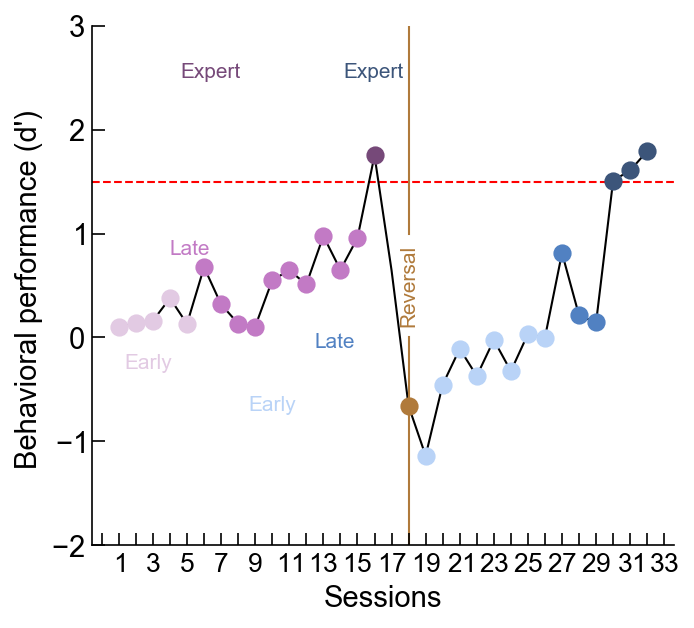

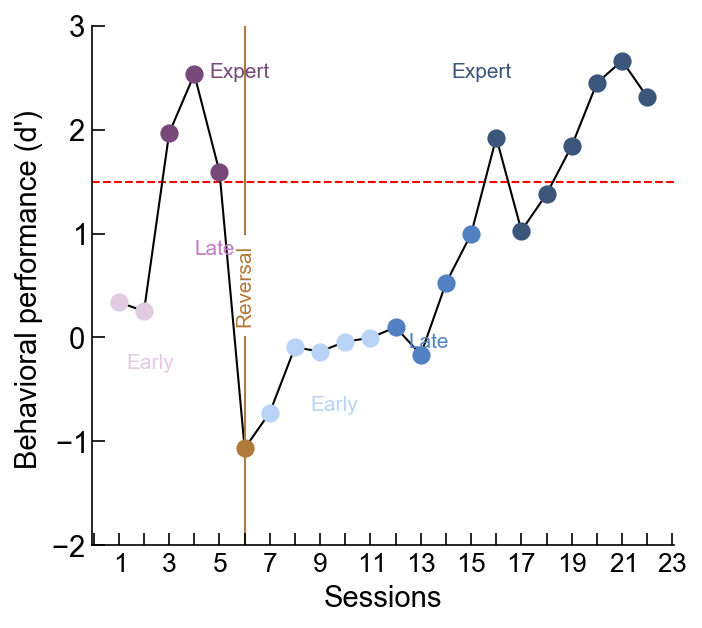

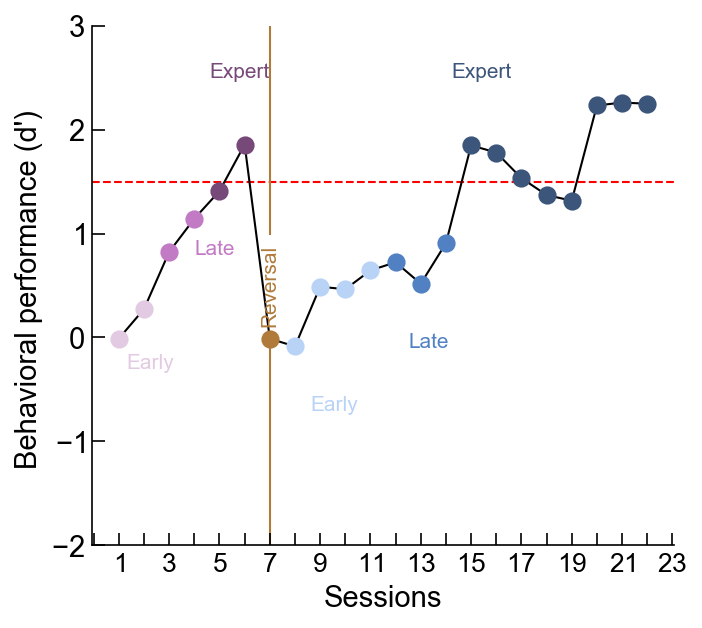

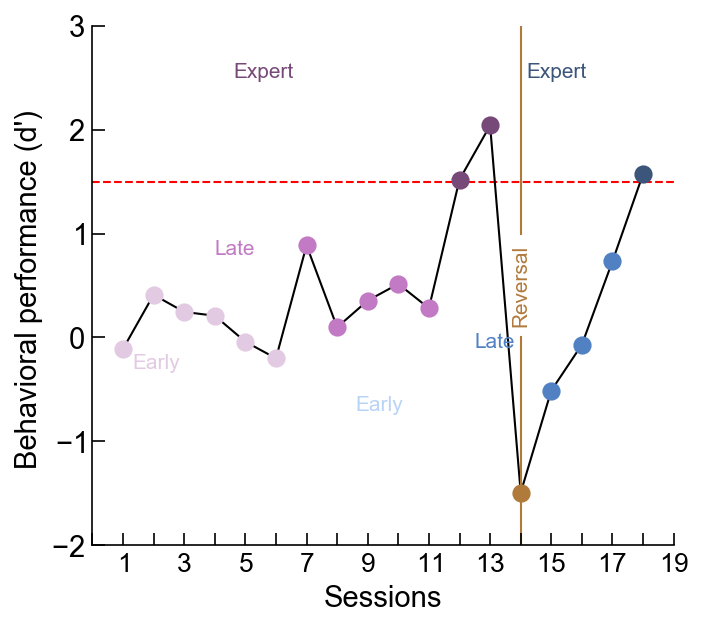

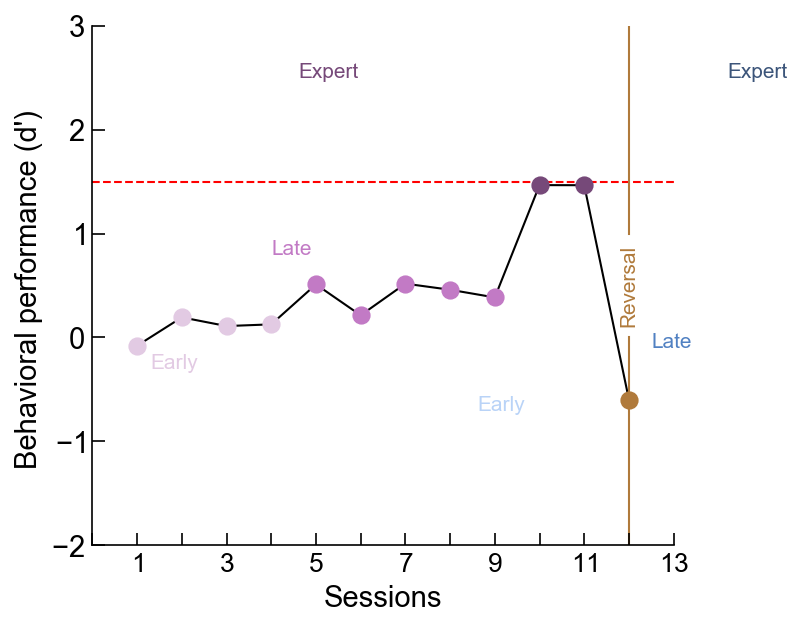

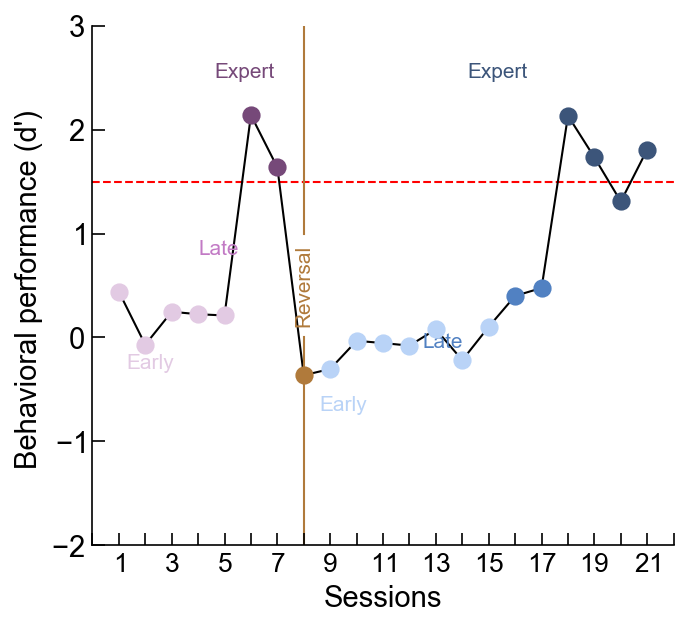

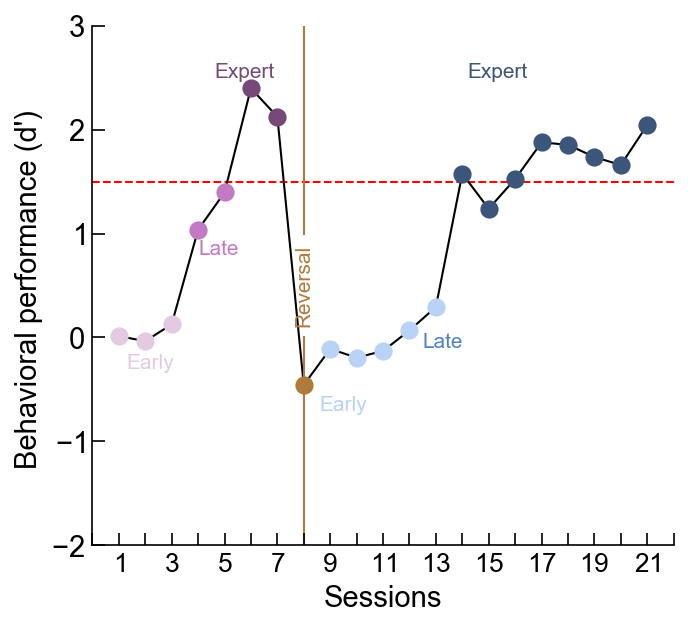

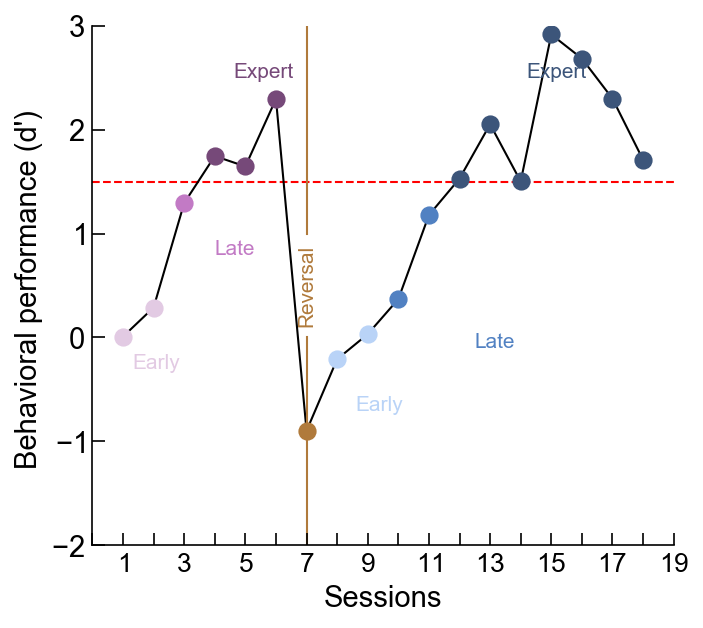

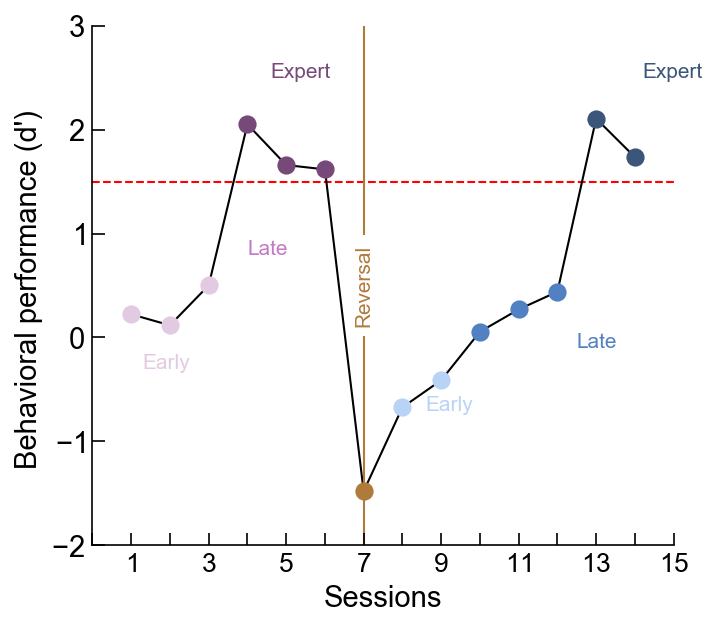

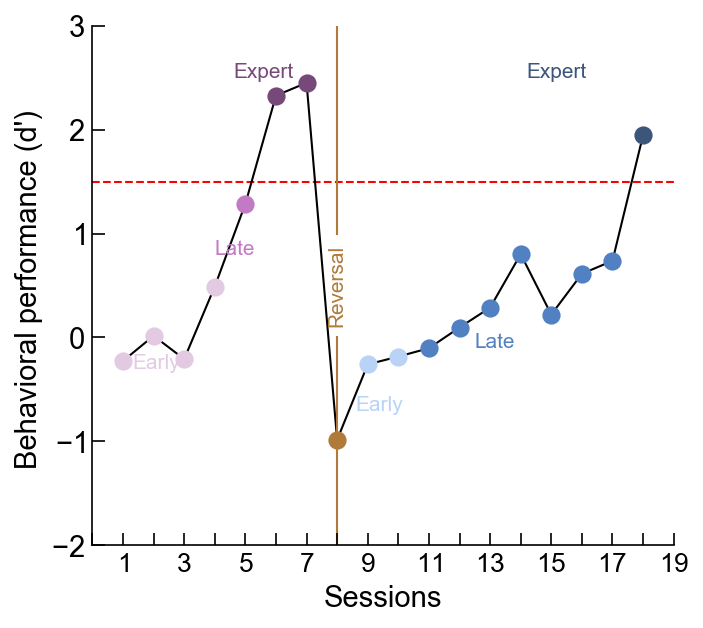

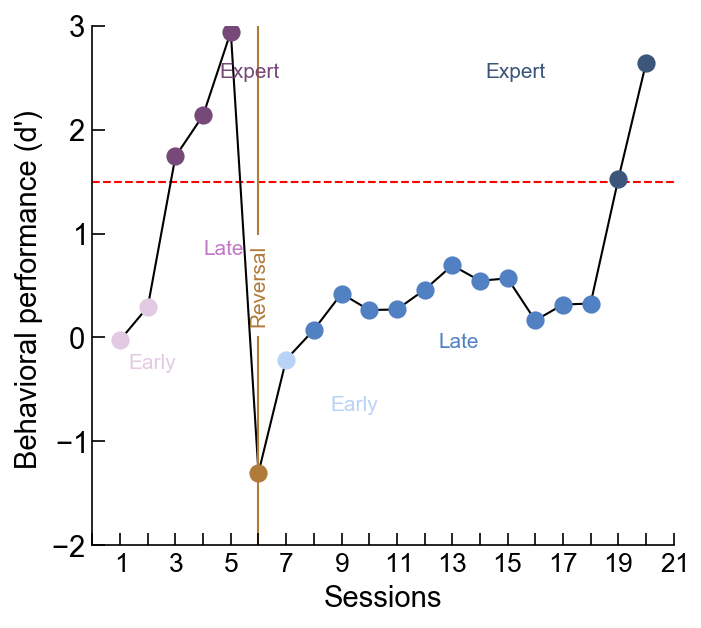

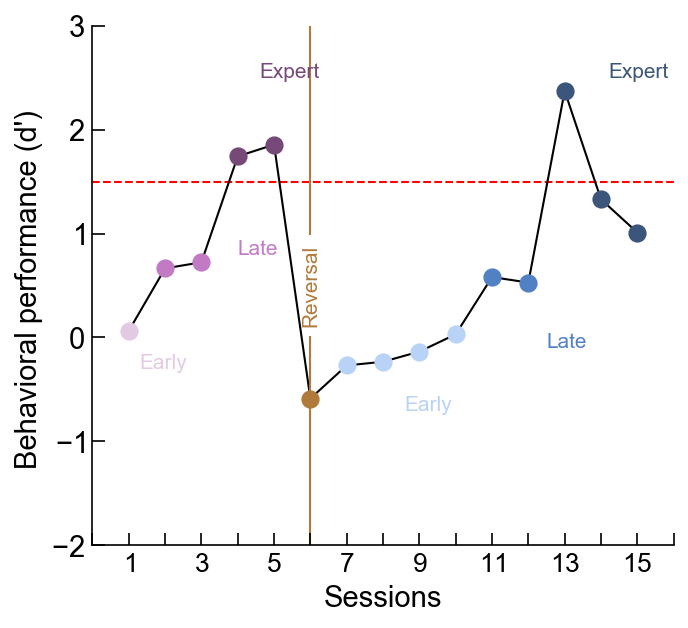

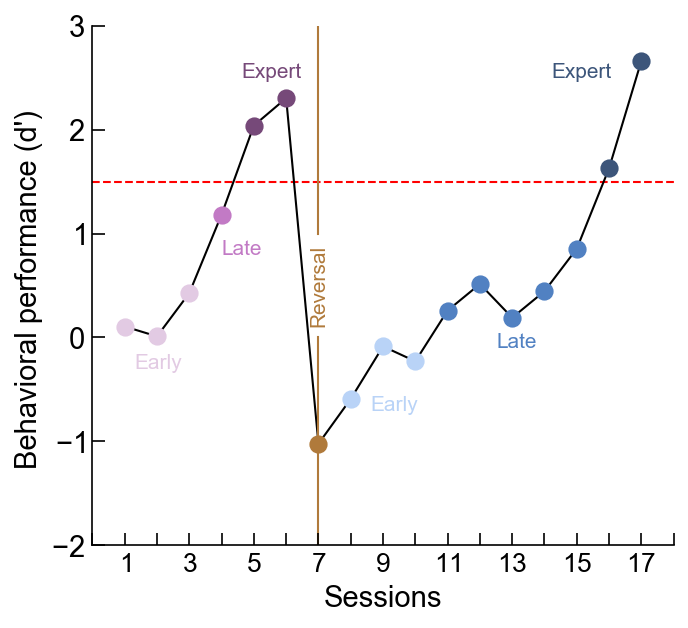

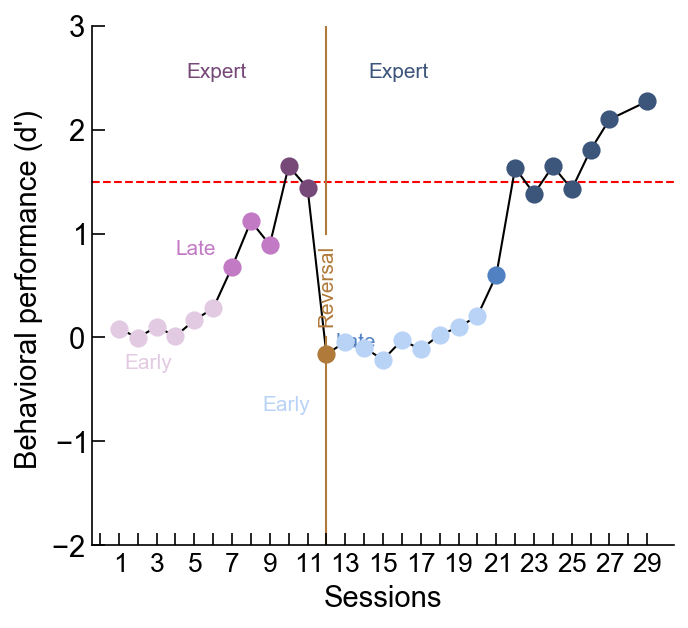

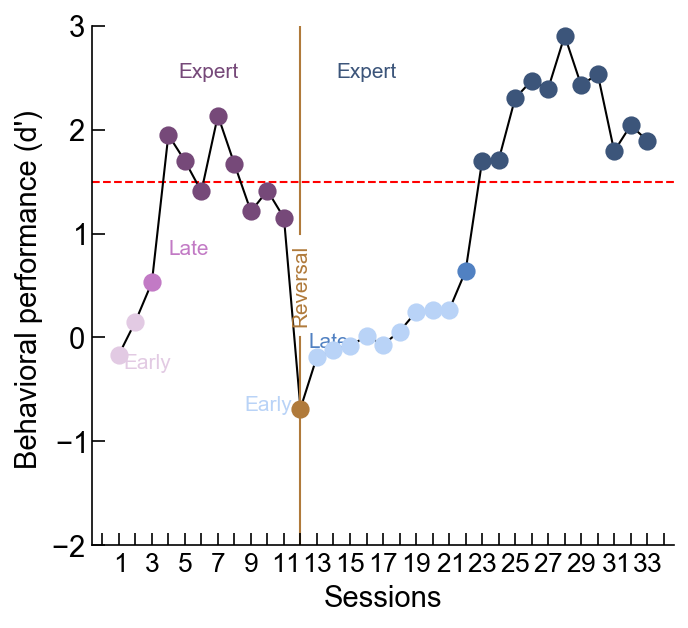

In [82]:
animallist = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

for animal in animallist:
    animal_learning_curve(animal)

In [4]:
animals

['BS_40',
 'BS_41',
 'BS_42',
 'BS_49',
 'BS_50',
 'BS_51',
 'BS_56',
 'BS_59',
 'BS_67',
 'BS_70',
 'BS_72',
 'BS_87',
 'BS_108',
 'DS_15',
 'DS_19']

In [5]:
#animal = 'BS_70'
animal = 'BS_59'

reversal = animalBehaviors[animal].reversal
days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)
days = np.sort(days)

In [6]:
pc = pc_list*100
miss_fa = 100 - pc

In [7]:
print(pc)

[51.51515152 55.7312253  68.         75.47169811 79.16666667 74.46808511
 41.         47.81021898 51.85714286 52.         67.5        76.82926829
 69.64285714 74.07407407 82.07070707 78.4660767  73.72881356 79.00552486]


# V1

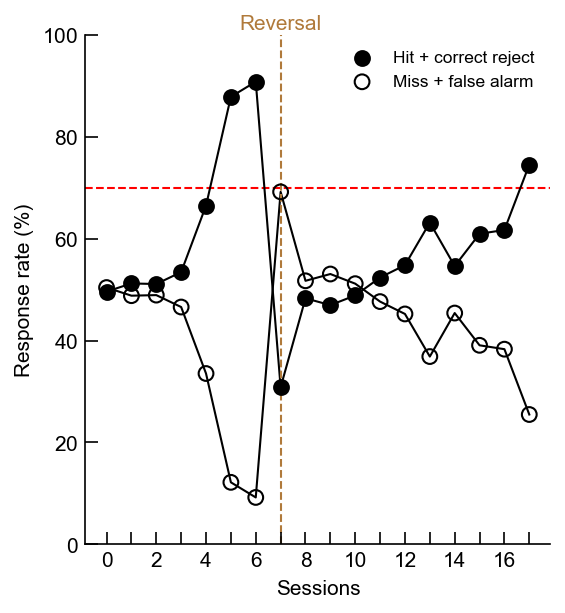

In [83]:
fig, ax = plt.subplots(figsize=(4,4.5))
circle_color = 'black'
circle_size = 50
ax.plot(days,pc,color=circle_color,lw=1)
ax.scatter(days,pc,color=circle_color,s=circle_size,label='Hit + correct reject',zorder=10)

ax.plot(days,miss_fa,color=circle_color,lw=1)
ax.scatter(days,miss_fa,facecolors='none', edgecolor=circle_color,s=circle_size,label='Miss + false alarm',zorder=10)


ax.set_ylim([0,100])
ax.set_yticks([0,20,40,60,80,100])
ax.set_xticks(days)
ax.set_xticklabels(days-1)
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    labeledindex = [0,2,4,6,8,10,12,14,16]
    if index not in labeledindex:
        label.set_visible(False)
        
ax.tick_params(length=6)
ax.legend(frameon = False)
ax.text(reversal,ax.get_ylim()[1]+4,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
#ax.text(16,10,'N = 1')
ax.axvline(reversal,c=SWITCH_COLOR,linestyle='--',lw=1)
ax.axhline(70,c='r',linestyle='--',lw=1,zorder=-10)
ax.set_ylabel("Response rate (%)")
ax.set_xlabel("Sessions")
ax.tick_params(length=6)
ax.set_axisbelow(False)
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript','example response rate BS_108 v0.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Example response rate '+animal+' broken axes V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

8
18


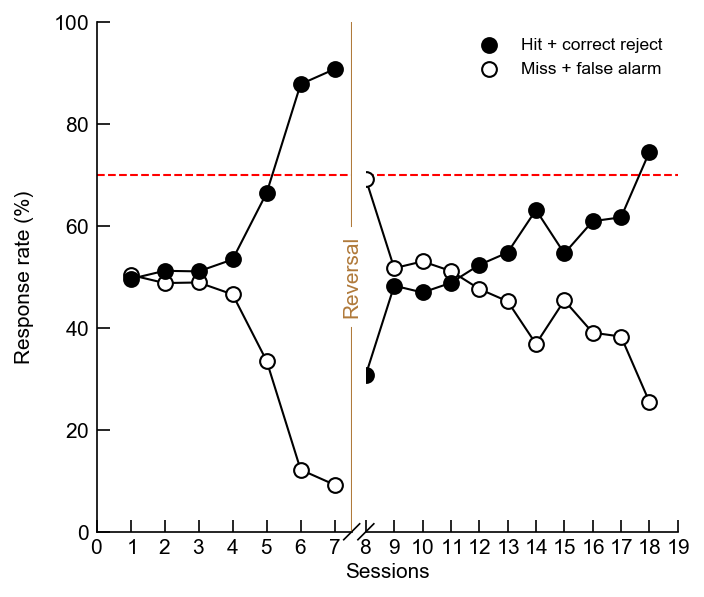

In [201]:
rev = animalBehaviors[animal].reversal
max_day = len(animalBehaviors[animal].sessions)
print(rev)
print(max_day)

fig = plt.figure(figsize=(5,4.5))
bax = brokenaxes(xlims=( (0,rev-0.5), (rev, max_day+1) ), width_ratios=[rev+1,max_day+1-rev], wspace=0.05)

circle_color = 'black'
circle_size = 50
bax.axs[0].plot(days[0:rev-1],pc[0:rev-1],color=circle_color,lw=1)
bax.axs[1].plot(days[rev-1:max_day],pc[rev-1:max_day],color=circle_color,lw=1)
bax.axs[0].scatter(days[0:rev-1],pc[0:rev-1],color=circle_color,s=circle_size,label='Hit + correct reject',zorder=10)
bax.axs[1].scatter(days[rev-1:max_day],pc[rev-1:max_day],color=circle_color,s=circle_size,label='Hit + correct reject',zorder=10)

bax.axs[0].plot(days[0:rev-1],miss_fa[0:rev-1],color=circle_color,lw=1)
bax.axs[1].plot(days[rev-1:max_day],miss_fa[rev-1:max_day],color=circle_color,lw=1)
bax.axs[0].scatter(days[0:rev-1],miss_fa[0:rev-1],facecolors='white', edgecolor=circle_color,s=circle_size,label='Miss + false alarm',zorder=9)
bax.axs[1].scatter(days[rev-1:max_day],miss_fa[rev-1:max_day],facecolors='white', edgecolor=circle_color,s=circle_size,label='Miss + false alarm',zorder=9)


bax.set_ylim([0,100])
bax.set_yticks([0,20,40,60,80,100])
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    labeledindex = [0,2,4,6,8,10,12,14,16]
    if index not in labeledindex:
        label.set_visible(False)

size = 10
center = np.mean(ax.get_ylim())
bax.axs[0].text(reversal-0.5,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
bax.axs[0].plot([rev-0.5,rev-0.5],[bax.axs[0].get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
bax.axs[0].plot([rev-0.5,rev-0.5],[center+size,bax.axs[0].get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
        
bax.tick_params(length=6)
bax.legend(frameon = False)
#bax.text(16,10,'N = 1')
bax.axhline(70,c='r',linestyle='--',lw=1,zorder=-10)
bax.set_ylabel("Response rate (%)")
bax.set_xlabel("Sessions")
bax.tick_params(length=6)
bax.set_axisbelow(False)

bax.axs[0].set_xticks(range(rev))
bax.axs[1].set_xticks(range(rev,max_day+2))
#bax.axs[0].set_xticklabels([0,'',2,'',4,'',6,''])
#bax.axs[1].set_xticklabels(['',8,'',10,'',12,'',14,'',16,'',18])

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Example response rate '+animal+' broken axes V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

### V2

7
18


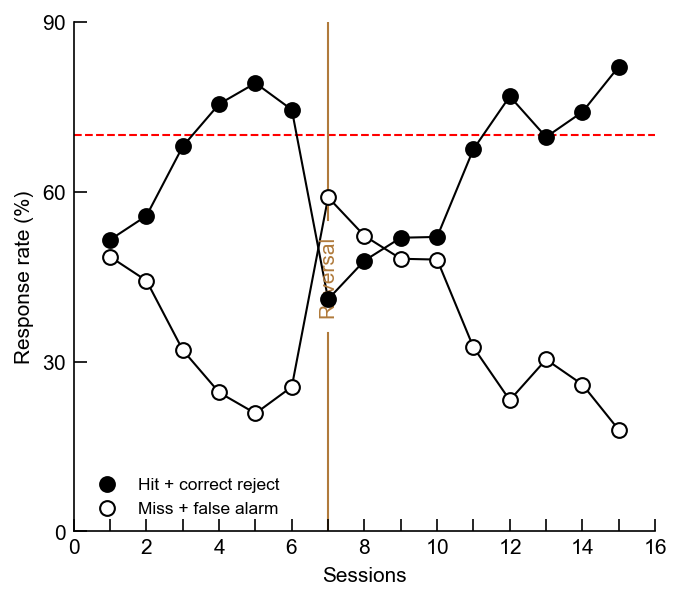

In [8]:
rev = animalBehaviors[animal].reversal
max_day = len(animalBehaviors[animal].sessions)
print(rev)
print(max_day)
max_day = 15

fig, ax = plt.subplots(figsize=(5,4.5))

circle_color = 'black'
circle_size = 50
# ax.plot(days[0:rev-1],pc[0:rev-1],color=circle_color,lw=1)
# ax.plot(days[rev-1:max_day],pc[rev-1:max_day],color=circle_color,lw=1)
ax.plot(days[0:max_day],pc[0:max_day],color=circle_color,lw=1)
ax.scatter(days[0:rev-1],pc[0:rev-1],color=circle_color,s=circle_size,label='Hit + correct reject',zorder=10)
ax.scatter(days[rev-1:max_day],pc[rev-1:max_day],color=circle_color,s=circle_size,zorder=10)

# ax.plot(days[0:rev-1],miss_fa[0:rev-1],color=circle_color,lw=1)
# ax.plot(days[rev-1:max_day],miss_fa[rev-1:max_day],color=circle_color,lw=1)
ax.plot(days[0:max_day],miss_fa[0:max_day],color=circle_color,lw=1)
ax.scatter(days[0:rev-1],miss_fa[0:rev-1],facecolors='white', edgecolor=circle_color,s=circle_size,label='Miss + false alarm',zorder=9)
ax.scatter(days[rev-1:max_day],miss_fa[rev-1:max_day],facecolors='white', edgecolor=circle_color,s=circle_size,zorder=9)

ax.set_xlim([0,16])
ax.set_ylim([0,90])
ax.set_yticks([0,30,60,90])
#ax.set_yticks([0,20,40,60,80,100])
ax.set_xticks(range(0,max_day+2))
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    labeledindex = [0,2,4,6,8,10,12,14,16,18,20]
    if index not in labeledindex:
        label.set_visible(False)

size = 10
center = np.mean(ax.get_ylim())
ax.text(reversal,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
        
ax.tick_params(length=6)
ax.legend(frameon = False)
#ax.text(16,10,'N = 1')
ax.axhline(70,c='r',linestyle='--',lw=1,zorder=-10)
ax.set_ylabel("Response rate (%)")
ax.set_xlabel("Sessions")
ax.tick_params(length=6)
ax.set_axisbelow(False)

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Example response rate '+animal+' broken axes V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [16]:
##############
animallist = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

In [17]:
def animal_learning_curve(animal):
    rev = animalBehaviors[animal].reversal
    max_day = len(animalBehaviors[animal].sessions)
    print(rev)
    print(max_day)

    fig, ax = plt.subplots(figsize=(5,4.5))
    PLOTTING_PHASE_COLORS = PHASE_COLORS


    reversal = animalBehaviors[animal].reversal
    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)

    print(dp_list)

    days = np.sort(days)

    ax.plot(days,dp_list,color='k',lw=1)

    circle_size = 60

    #Pre Early
    pre_early = np.isin(days,animalPhases[animal].pre_early_days)
    ax.scatter(days[pre_early],dp_list[pre_early],color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10)

    #Pre Late
    pre_late = np.isin(days,animalPhases[animal].pre_late_days)
    ax.scatter(days[pre_late],dp_list[pre_late],color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10)

    #Pre Expert
    pre_expert = np.isin(days,animalPhases[animal].pre_expert_days)
    ax.scatter(days[pre_expert],dp_list[pre_expert],color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10)

    #Post Early
    post_early = np.isin(days,animalPhases[animal].post_early_days)
    ax.scatter(days[post_early],dp_list[post_early],color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10)

    #Post Late
    post_late = np.isin(days,animalPhases[animal].post_late_days)
    ax.scatter(days[post_late],dp_list[post_late],color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10)

    #Post Expert
    post_expert = np.isin(days,animalPhases[animal].post_expert_days)
    ax.scatter(days[post_expert],dp_list[post_expert],color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10)

    #Switch
    switch = np.equal(days,animalBehaviors[animal].reversal)
    ax.scatter(days[switch],dp_list[switch],color=SWITCH_COLOR,s=circle_size,zorder=10)

    ax.set_ylim([-2,3])
    ax.set_yticks([-2,-1,0,1,2,3])

    ax.set_xticks(range(0,max_day+1))
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        labeledindex = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
        if index not in labeledindex:
            label.set_visible(False)
    ax.tick_params(length=6)

    size = 0.5
    center = np.mean(ax.get_ylim())
    ax.text(reversal,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
    ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
    ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

    ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
    print(reversal)
    ax.text(1.3,-0.3,'Early',color=PLOTTING_PHASE_COLORS[0])
    ax.text(4,0.8,'Late',color=PLOTTING_PHASE_COLORS[1])
    ax.text(4.6,2.5,'Expert',color=PLOTTING_PHASE_COLORS[2])
    ax.text(8.6,-0.7,'Early',color=PLOTTING_PHASE_COLORS[3])
    ax.text(12.5,-0.1,'Late',color=PLOTTING_PHASE_COLORS[4])
    ax.text(14.2,2.5,'Expert',color=PLOTTING_PHASE_COLORS[5])

    ax.set_ylabel("Behavioral performance (d') ")
    ax.set_xlabel('Sessions')
    ax.set_axisbelow(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    #These must be changed at the end. brokenaxes recalculates ticks for several calls
    ax.set_xticks(range(0,max_day+2))
    
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript\\Learning'+animal+'.pdf'),transparent=False,facecolor="white")

18
32
[ 1.01438707e-01  1.37470570e-01  1.61147678e-01  3.78100509e-01
  1.30667995e-01  6.75951955e-01  3.18152223e-01  1.33781642e-01
  1.05435139e-01  5.50061203e-01  6.47293906e-01  5.10515631e-01
  9.75839714e-01  6.49997918e-01  9.57439193e-01  1.75068607e+00
  6.45937118e-01 -6.59639262e-01 -1.13769046e+00 -4.53113066e-01
 -1.08914779e-01 -3.70657876e-01 -2.38342777e-02 -3.23904626e-01
  3.34667380e-02 -4.04163274e-04  8.12577505e-01  2.11904642e-01
  1.45051104e-01  1.51000976e+00  1.60662307e+00  1.79314022e+00]
18


meta NOT subset; don't know how to subset; dropped


6
22
[ 3.39091644e-01  2.53561762e-01  1.96616793e+00  2.53234923e+00
  1.59387834e+00 -1.06692473e+00 -7.21861241e-01 -9.39984859e-02
 -1.35522963e-01 -4.07337237e-02 -2.58815788e-03  9.83928600e-02
 -1.64883802e-01  5.22237339e-01  9.94343648e-01  1.92294445e+00
  1.02747369e+00  1.37988470e+00  1.84349751e+00  2.44791545e+00
  2.66195058e+00  2.31262547e+00]
6


meta NOT subset; don't know how to subset; dropped


7
22
[-0.01042846  0.27330672  0.82267555  1.14305708  1.40833     1.85547589
 -0.01141025 -0.08588091  0.48846321  0.46395537  0.64516613  0.72354488
  0.51729442  0.90687867  1.84798855  1.77937662  1.53244044  1.37054047
  1.31545891  2.23160584  2.2599773   2.24867193]
7


meta NOT subset; don't know how to subset; dropped


14
18
[-0.11003674  0.41087968  0.24592819  0.20910164 -0.04103203 -0.20045666
  0.88579171  0.09791022  0.35506672  0.51495689  0.28147675  1.5188584
  2.03980726 -1.49267521 -0.51041583 -0.06887862  0.73320061  1.5721089 ]
14


meta NOT subset; don't know how to subset; dropped


12
12
[-0.07923552  0.19363     0.10976742  0.12618768  0.51066348  0.21341921
  0.51772575  0.45916083  0.38514331  1.46569067  1.46474463 -0.59842679]
12


meta NOT subset; don't know how to subset; dropped


8
21
[ 0.44108849 -0.06961766  0.24720434  0.22381911  0.21162565  2.13895803
  1.63634123 -0.36346292 -0.30321284 -0.03215041 -0.05386281 -0.0783368
  0.0782116  -0.21830623  0.10280486  0.39996163  0.47616062  2.13314312
  1.73219928  1.30808593  1.8081935 ]
8


meta NOT subset; don't know how to subset; dropped


8
21
[ 0.01307263 -0.03547696  0.12648658  1.03616409  1.3948341   2.39778481
  2.12321018 -0.45631639 -0.11041236 -0.19386323 -0.12960754  0.06764879
  0.29338906  1.57510456  1.23857784  1.52405519  1.87688788  1.85330874
  1.73627152  1.65886098  2.04357357]
8


meta NOT subset; don't know how to subset; dropped


7
18
[ 0.00829425  0.28796781  1.29335178  1.7453422   1.64524616  2.29411814
 -0.89764928 -0.20880529  0.03228668  0.36903883  1.17757411  1.52851681
  2.05102631  1.50108595  2.91488527  2.68367447  2.29772722  1.70926982]
7


meta NOT subset; don't know how to subset; dropped


7
14
[ 0.22333219  0.117072    0.50096659  2.0509076   1.65882123  1.6170513
 -1.47968652 -0.67227476 -0.41145554  0.05513363  0.27000882  0.44023325
  2.10546337  1.73469222]
7


meta NOT subset; don't know how to subset; dropped


8
18
[-0.22602724  0.01606811 -0.20800805  0.49016044  1.28604105  2.32682891
  2.44962099 -0.98391879 -0.25886575 -0.18376031 -0.10315011  0.0957528
  0.28730823  0.80142998  0.22019886  0.61274793  0.73711856  1.94579188]
8


meta NOT subset; don't know how to subset; dropped


6
20
[-0.02433998  0.29368628  1.74103614  2.13742629  2.94047358 -1.30134314
 -0.21241968  0.07382095  0.42205212  0.26361124  0.26937776  0.45895196
  0.69374891  0.54618644  0.5680109   0.16376591  0.31701882  0.32607074
  1.52371705  2.63730633]
6


meta NOT subset; don't know how to subset; dropped


6
15
[ 0.06326055  0.66478826  0.72324915  1.74206027  1.85544654 -0.58730401
 -0.26887854 -0.23360435 -0.13598467  0.03032988  0.58124835  0.52811649
  2.37170598  1.32895248  1.00982167]
6


meta NOT subset; don't know how to subset; dropped


7
17
[ 0.10547308  0.01063495  0.42674176  1.18195369  2.03878793  2.30212246
 -1.02246561 -0.59084893 -0.08570874 -0.22906478  0.259121    0.51441997
  0.19019088  0.44518952  0.8541609   1.62785112  2.66146283]
7


meta NOT subset; don't know how to subset; dropped


12
28
[ 8.61384603e-02 -2.03034477e-03  1.02573122e-01  1.24458778e-02
  1.66176832e-01  2.80655963e-01  6.77793926e-01  1.11823327e+00
  8.91058914e-01  1.64894905e+00  1.43690184e+00 -1.59863879e-01
 -4.39018317e-02 -9.66780688e-02 -2.14399004e-01 -2.62007477e-02
 -1.13345688e-01  2.57492042e-02  9.80004420e-02  2.06937891e-01
  5.96598535e-01  1.63211448e+00  1.38231055e+00  1.64888276e+00
  1.42622532e+00  1.80425555e+00  2.09754363e+00  2.27182246e+00]
12


meta NOT subset; don't know how to subset; dropped


12
33
[-0.16578112  0.15170629  0.529155    1.94855364  1.69923938  1.40452733
  2.13504722  1.66853941  1.21247435  1.41318373  1.15120421 -0.6835115
 -0.18323683 -0.12367374 -0.08483057  0.01520004 -0.06826717  0.05689732
  0.24704236  0.26028947  0.26275998  0.63923063  1.69955042  1.70571958
  2.30119323  2.47158419  2.39360896  2.90330358  2.42612572  2.5356624
  1.79180131  2.04154811  1.89442177]
12


meta NOT subset; don't know how to subset; dropped


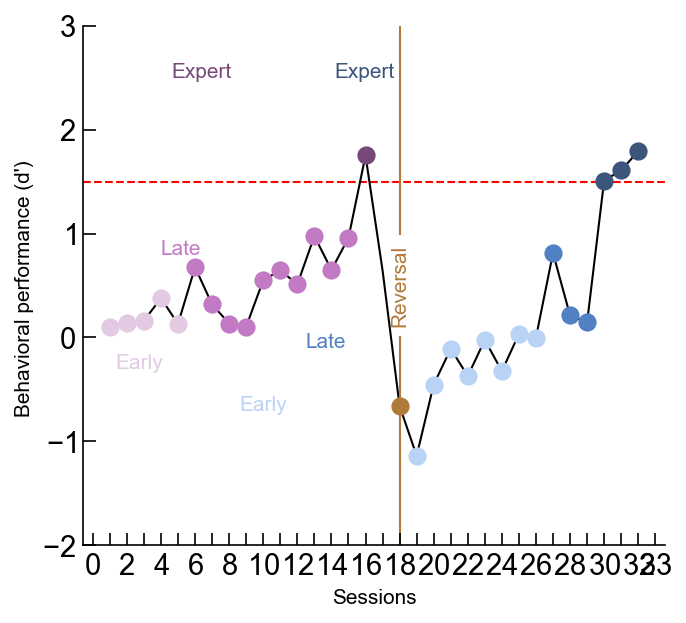

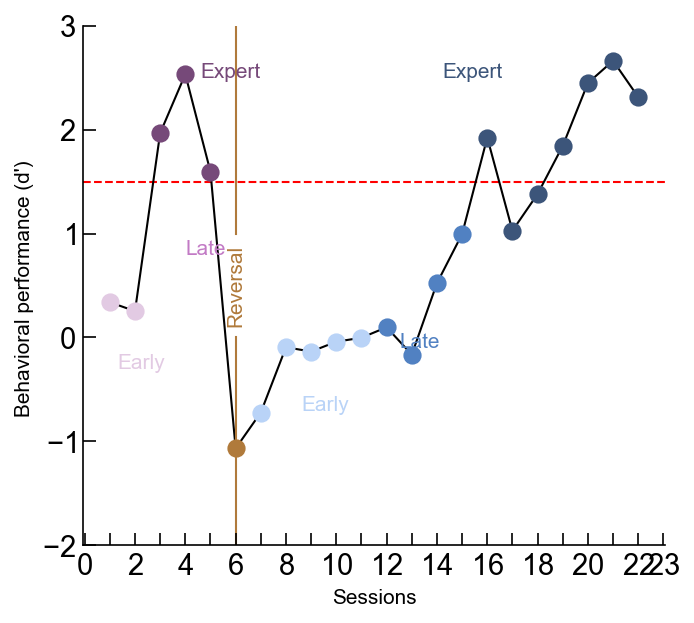

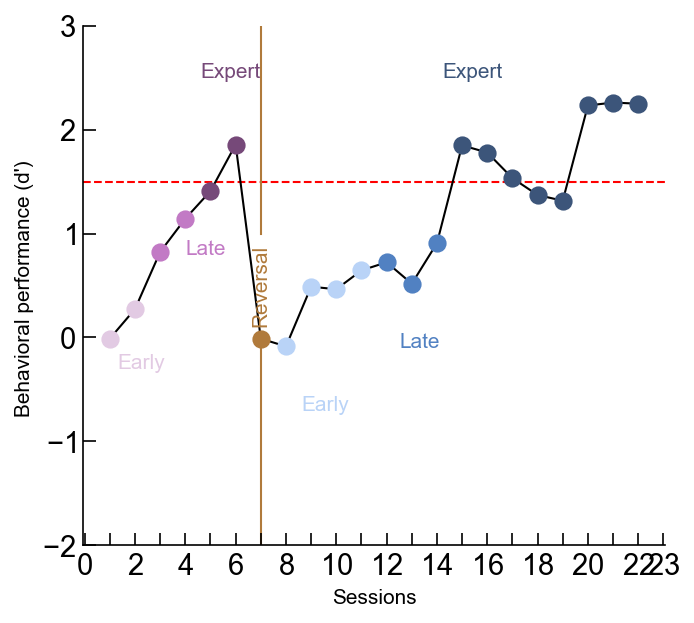

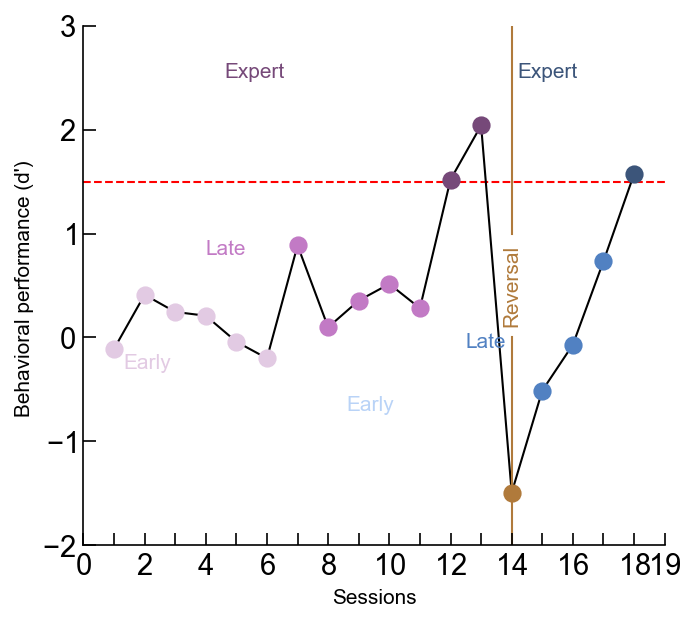

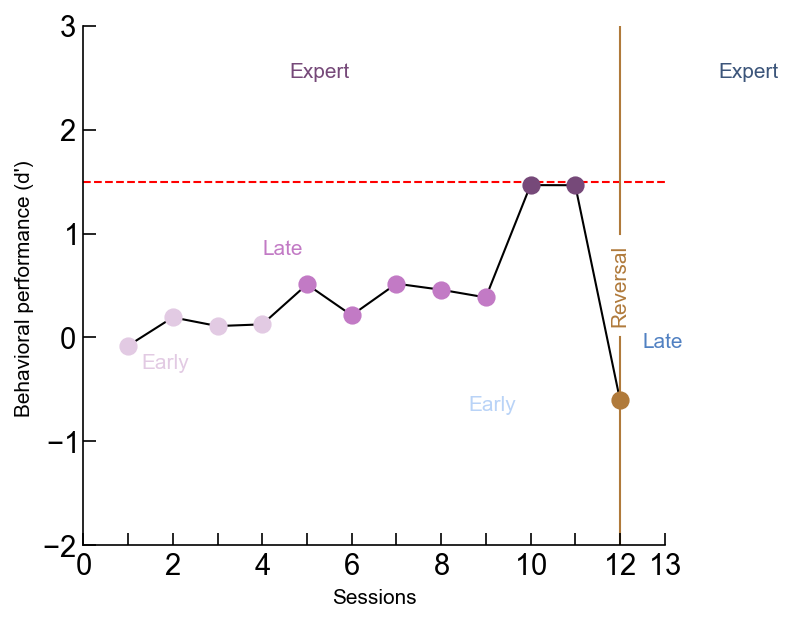

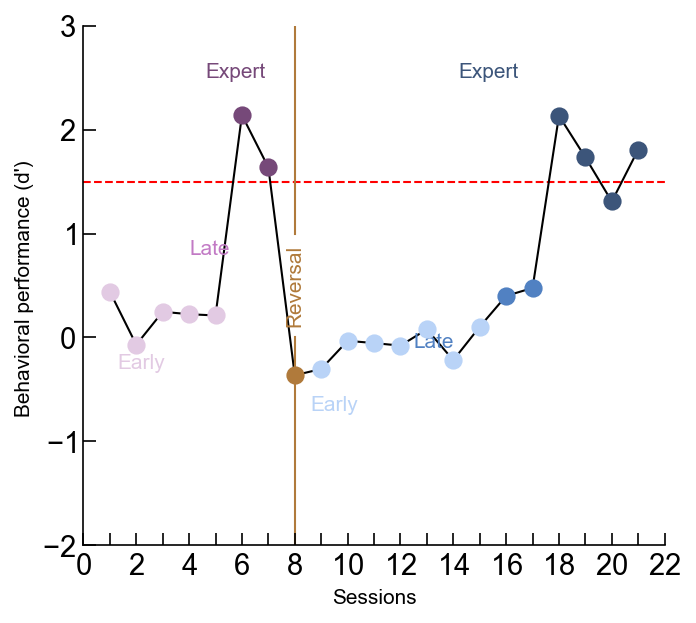

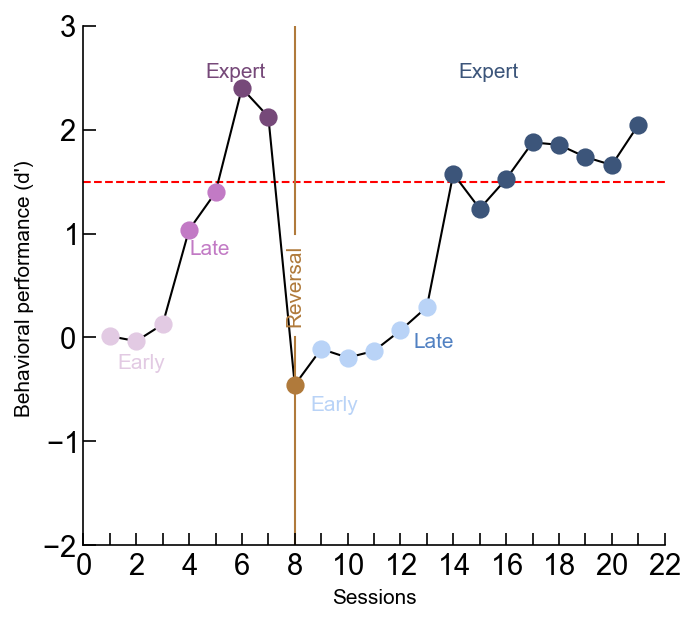

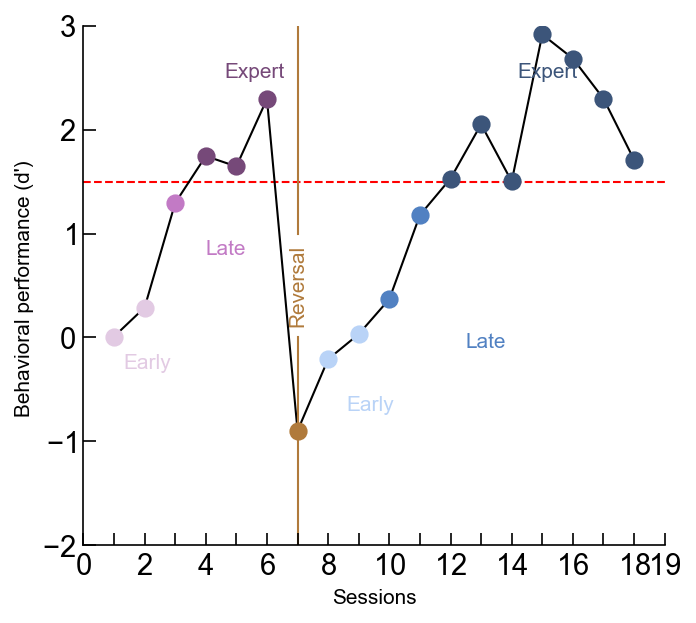

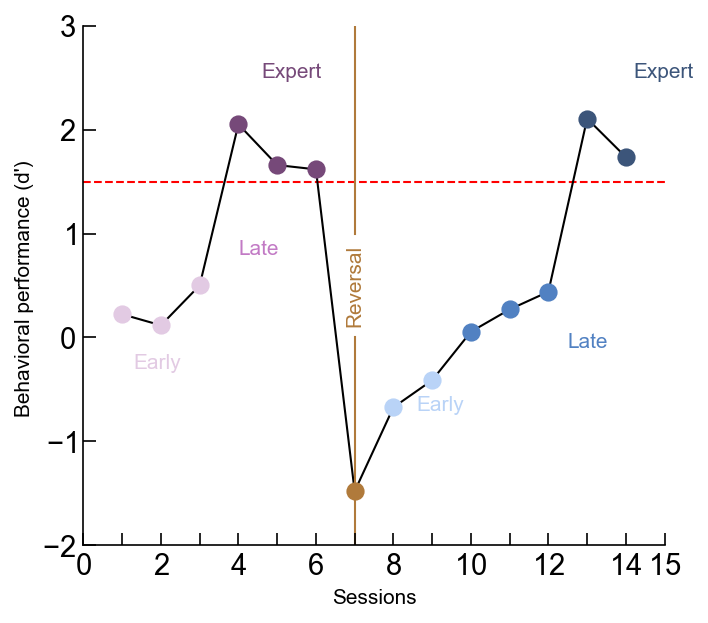

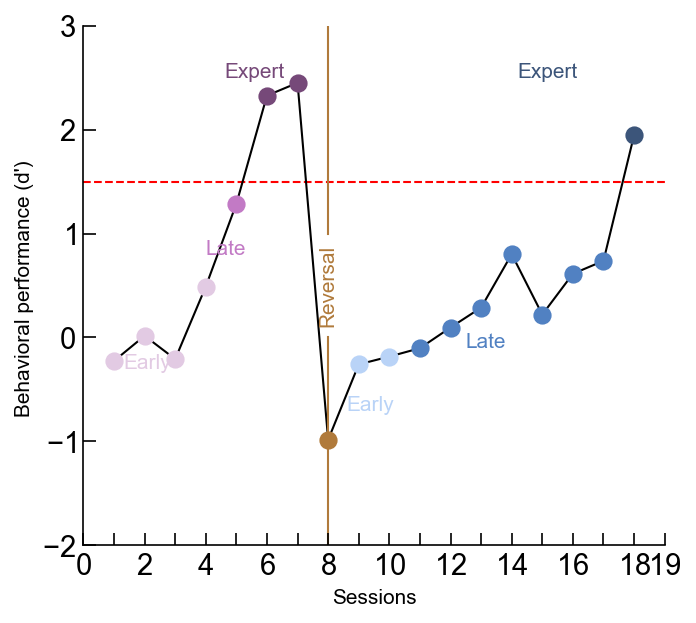

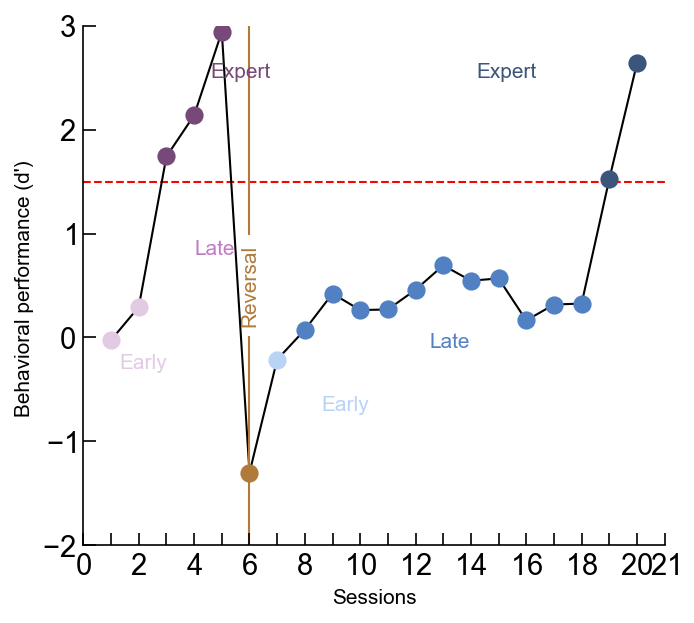

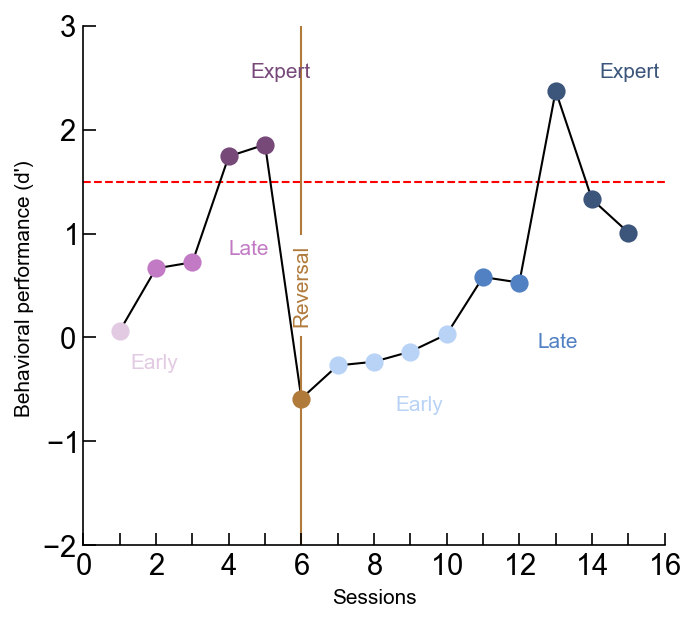

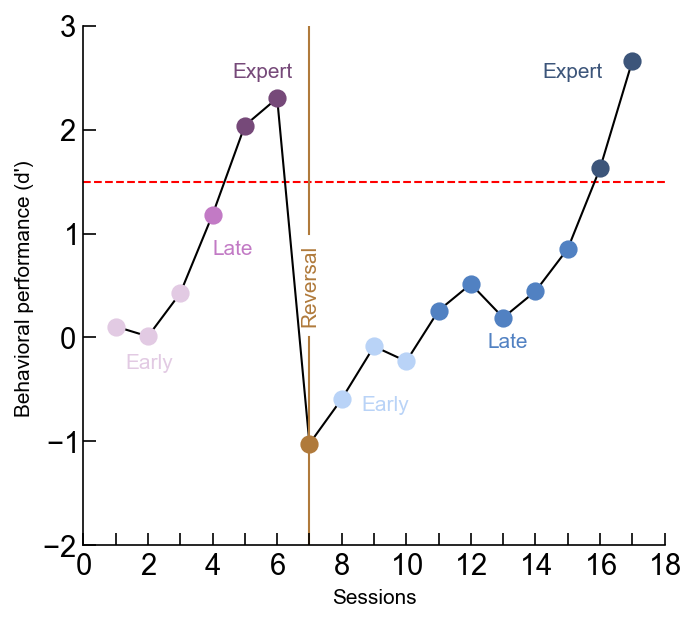

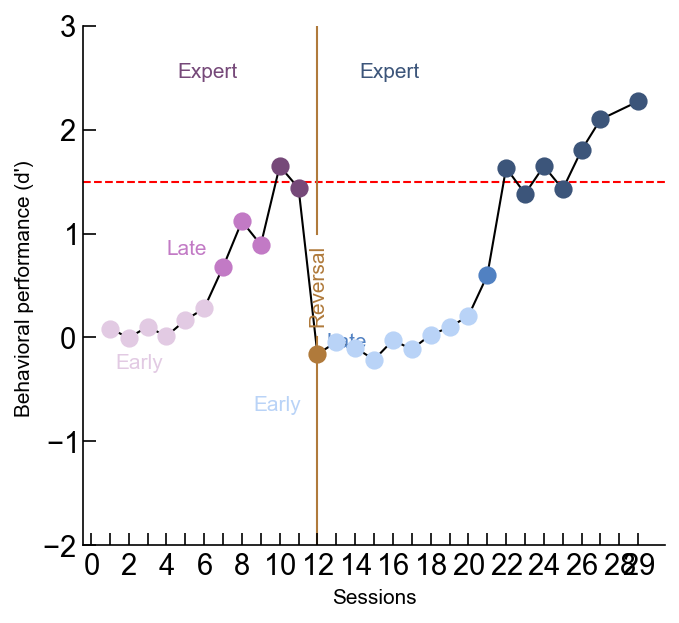

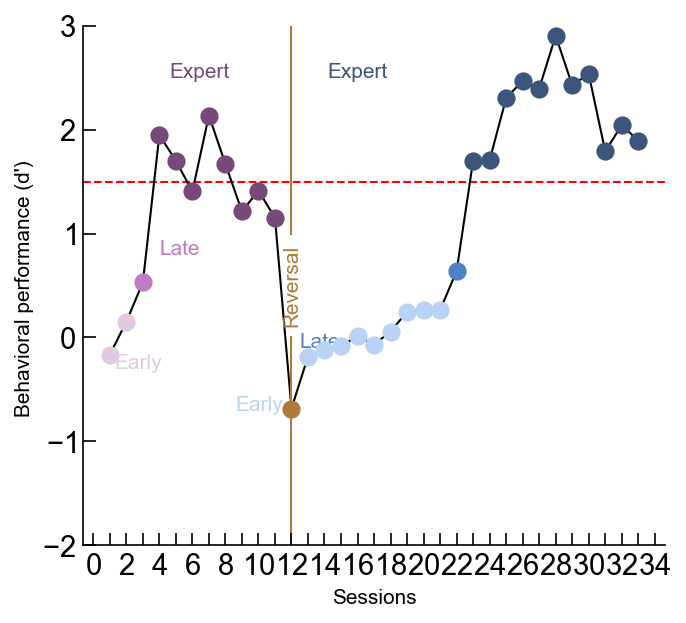

In [18]:
for animal in animallist:
    animal_learning_curve(animal)

meta NOT subset; don't know how to subset; dropped


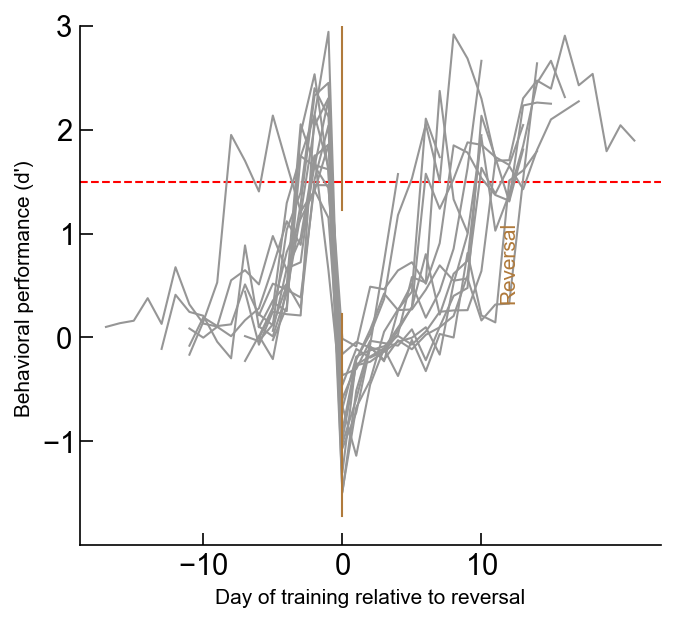

In [15]:
#All learning curves
fig, ax = plt.subplots(figsize=(5,4.5))

for animal in animallist:
    #animalPhases,_,_ = ilep.calculateLearningPhasesV2([animal],animalBehaviors,plot=True)
    reversal = animalBehaviors[animal].reversal
    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)
    days = np.sort(days)
    ax.plot(days-reversal,dp_list,color='#969696',lw=1)

    
size = 0.5
center = np.mean(ax.get_ylim())
ax.text(reversal,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([0,0],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([0,0],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
    
ax.set_ylim([-2,3])
ax.set_yticks([-1,0,1,2,3])
ax.set_xticks([-10,0,10])
#ax.text(0,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
#ax.axvline(0,c=SWITCH_COLOR,linestyle='--',lw=1)
ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-10)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel("Behavioral performance (d') ")
ax.set_xlabel('Day of training relative to reversal')
ax.tick_params(length=6)
ax.set_axisbelow(False)
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript','all animal learning curve v1.pdf'),transparent=False,facecolor="white")

In [239]:
def plotLearningCurve(animal):
    animalPhases,_,_ = ilep.calculateLearningPhasesV2([animal],animalBehaviors,plot=True)

    fig, ax = plt.subplots(figsize=(4,4.5))
    PLOTTING_PHASE_COLORS = PHASE_COLORS

    reversal = animalBehaviors[animal].reversal
    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)

    days = np.sort(days)

    #print(days)
    #print(dp_list)

    #All Days no color
    ax.plot(days,dp_list,color='k',lw=1)

    circle_size = 60

    #Pre Early
    pre_early = np.isin(days,animalPhases[animal].pre_early_days)
    ax.scatter(days[pre_early],dp_list[pre_early],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10)

    #Pre Late
    pre_late = np.isin(days,animalPhases[animal].pre_late_days)
    ax.scatter(days[pre_late],dp_list[pre_late],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10)
    #ax.axhline(animalPreThresh[animal],c=PHASE_COLORS[1],linestyle='--',lw=1,zorder=-20)

    #Pre Expert
    pre_expert = np.isin(days,animalPhases[animal].pre_expert_days)
    ax.scatter(days[pre_expert],dp_list[pre_expert],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10)

    #Post Early
    post_early = np.isin(days,animalPhases[animal].post_early_days)
    ax.scatter(days[post_early],dp_list[post_early],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10)

    #Post Late
    post_late = np.isin(days,animalPhases[animal].post_late_days)
    ax.scatter(days[post_late],dp_list[post_late],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10)

    #Post Expert
    post_expert = np.isin(days,animalPhases[animal].post_expert_days)
    ax.scatter(days[post_expert],dp_list[post_expert],edgecolor = 'black',color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10)
    
    #Switch
    switch = np.equal(days,animalBehaviors[animal].reversal)
    ax.scatter(days[switch],dp_list[switch],edgecolor = 'black',color=SWITCH_COLOR,s=circle_size,zorder=10)

    ax.set_ylim([-2,3])
    ax.set_yticks([-2,-1,0,1,2,3])
    ax.set_xticks(days)
    ax.set_xticklabels(days-1)
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        if index %2 !=0:
            label.set_visible(False)
    ax.tick_params(length=6)

    ax.text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
    ax.text(3,ax.get_ylim()[1]+0.2,'Pre',color=PLOTTING_PHASE_COLORS[0],horizontalalignment='center',verticalalignment='top')
    ax.text(12,ax.get_ylim()[1]+0.2,'Post',color=PLOTTING_PHASE_COLORS[3],horizontalalignment='center',verticalalignment='top')

    ax.axvline(reversal,c=SWITCH_COLOR,linestyle='--',lw=1)
    ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
    #print(reversal)
    
    if days[pre_early].size !=0:
        ax.text(days[pre_early][0],-0.3,'Early',color=PLOTTING_PHASE_COLORS[0])
    
    if days[pre_late].size !=0:
        ax.text(days[pre_late][0],0.8,'Late',color=PLOTTING_PHASE_COLORS[1])
    
    if days[pre_expert].size !=0:
        ax.text(days[pre_expert][0],2.5,'Expert',color=PLOTTING_PHASE_COLORS[2])
        
    if days[post_early].size !=0:
        ax.text(days[post_early][0],-0.7,'Early',color=PLOTTING_PHASE_COLORS[3])
        
    if days[post_late].size !=0:
        ax.text(days[post_late][0],-0.1,'Late',color=PLOTTING_PHASE_COLORS[4])
        
    if days[post_expert].size !=0:
        ax.text(days[post_expert][0],2.5,'Expert',color=PLOTTING_PHASE_COLORS[5])

    ax.set_ylabel("Behavioral performance (d') ")
    ax.set_xlabel('Sessions')
    ax.set_axisbelow(False)
    print(days-1)
    ax.text(max(days)/2, ax.get_ylim()[1]+0.5,animal,horizontalalignment='center',verticalalignment='top')
    #ax.legend(frameon = False)
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript\\Animals'+animal+'.pdf'),transparent=False,facecolor="white")

posx and posy should be finite values
posx and posy should be finite values


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28]


posx and posy should be finite values


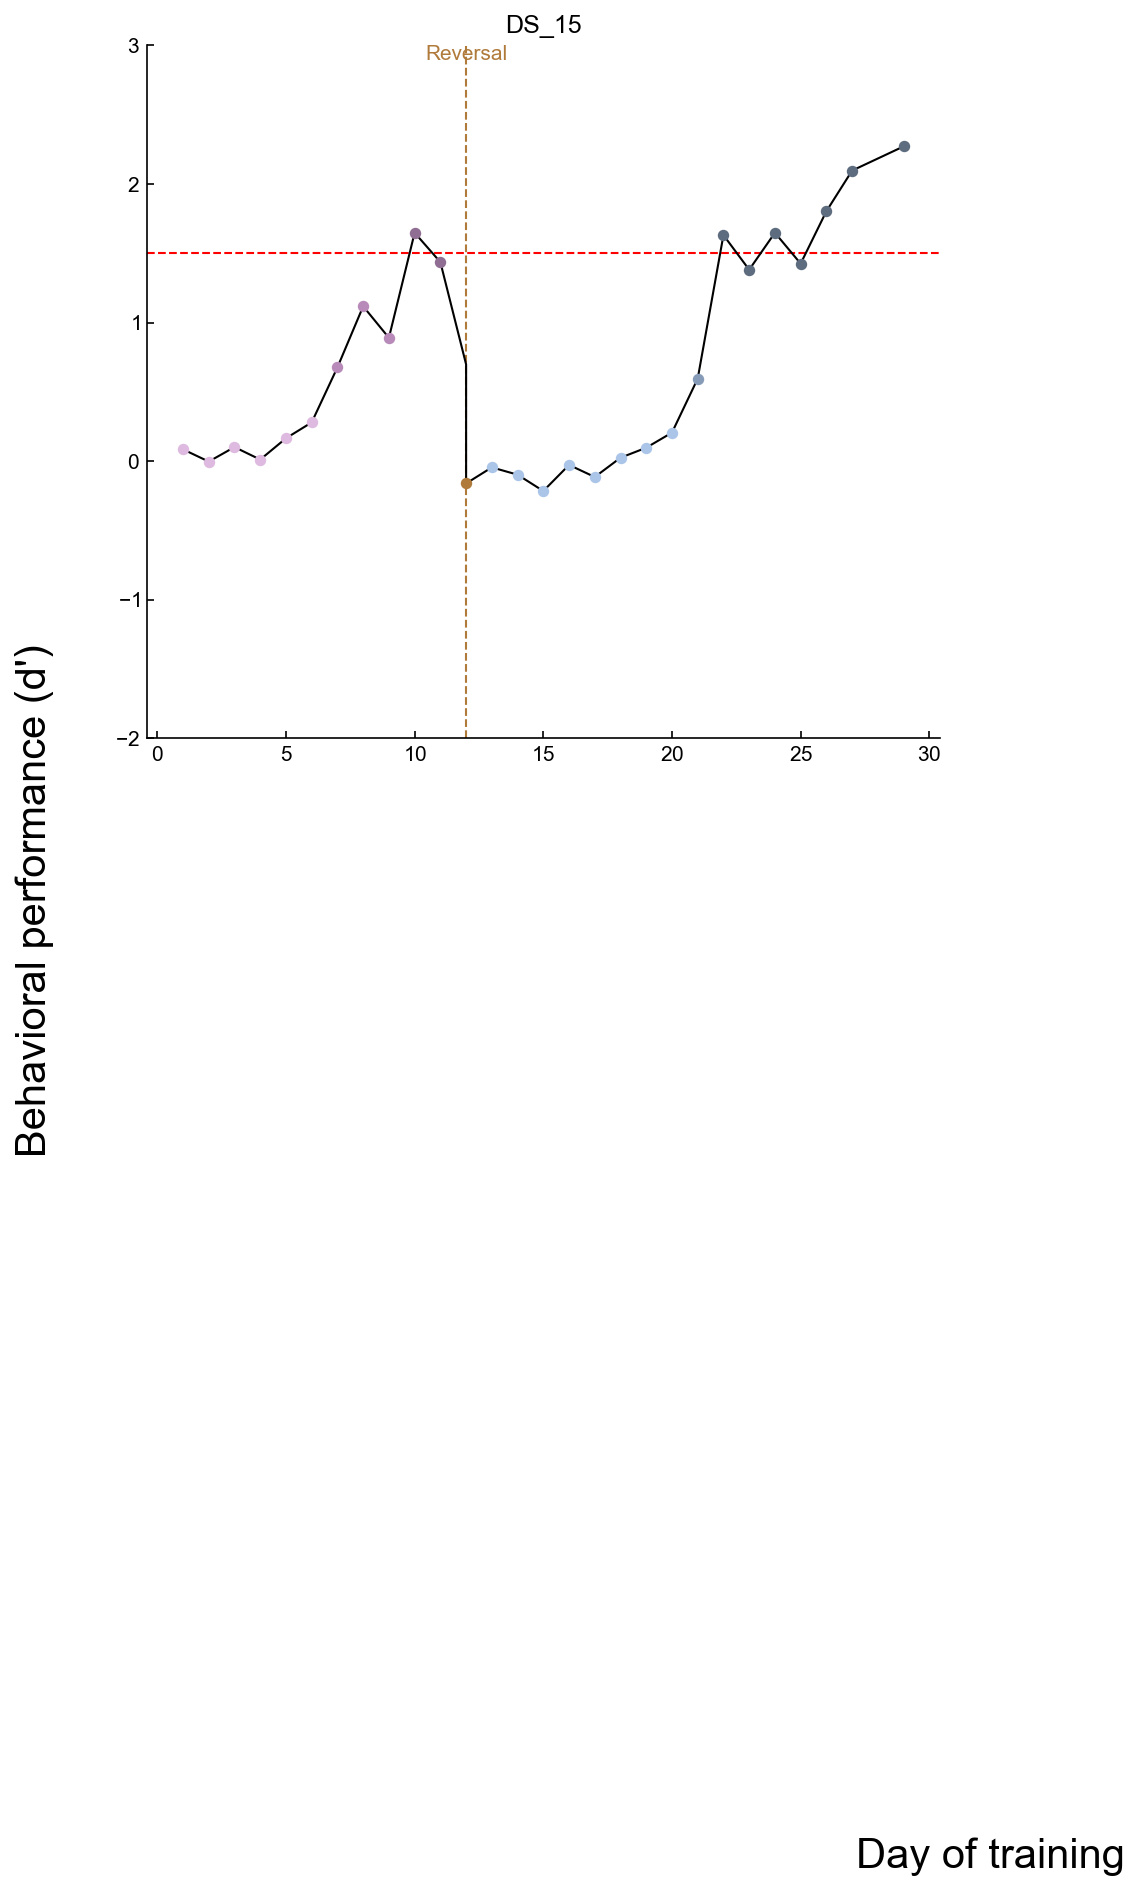

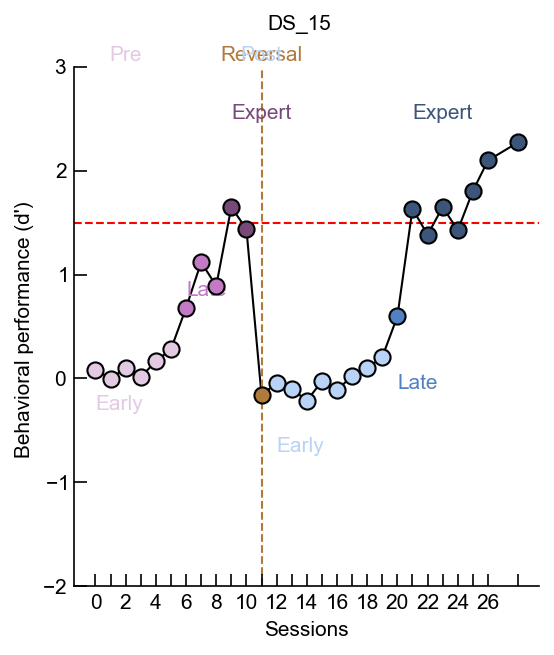

In [240]:
plotLearningCurve('DS_15')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx an

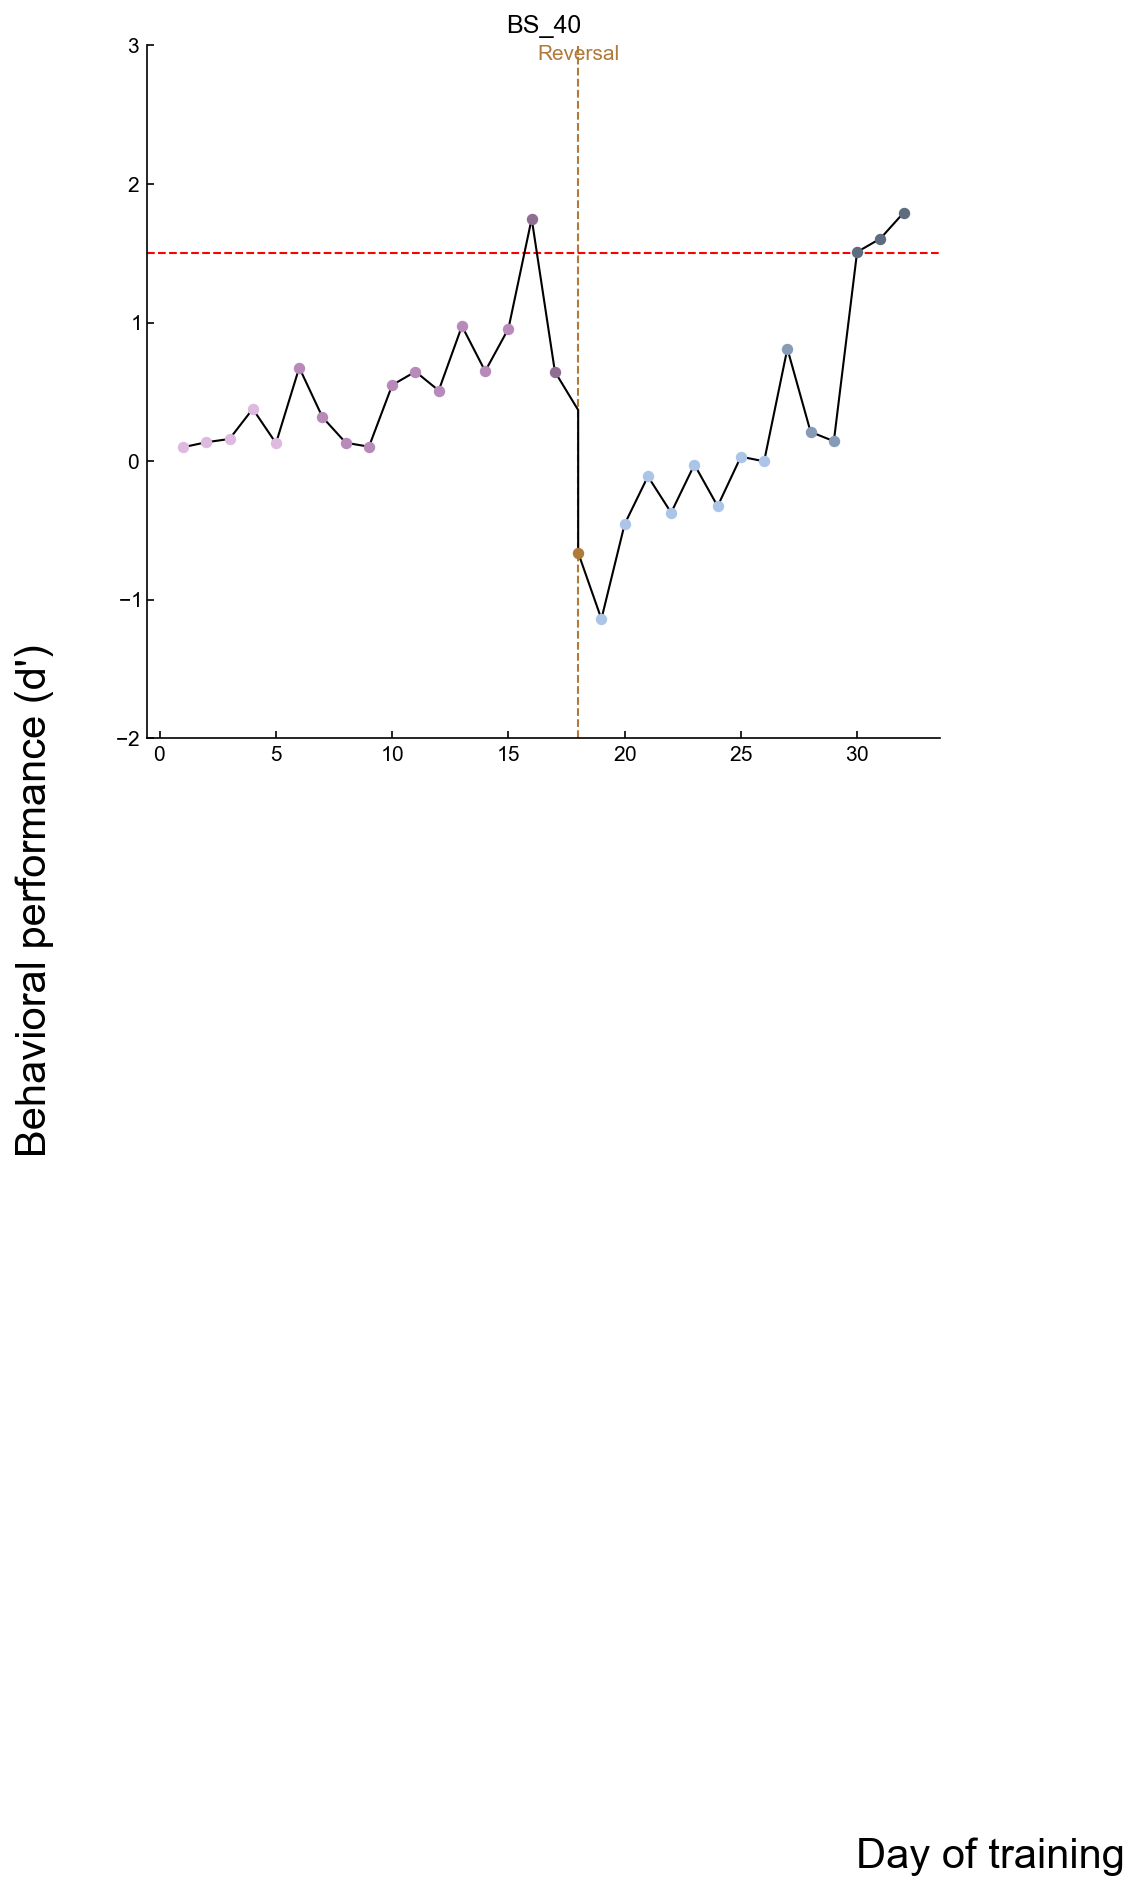

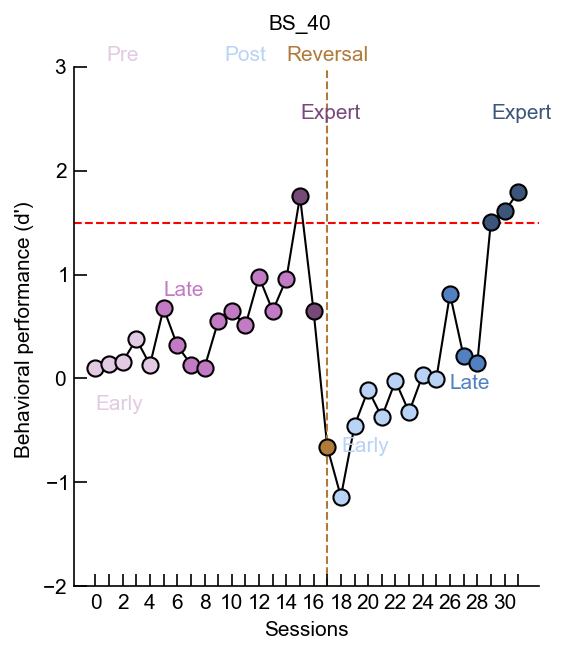

posx and posy should be finite values
posx and posy should be finite values


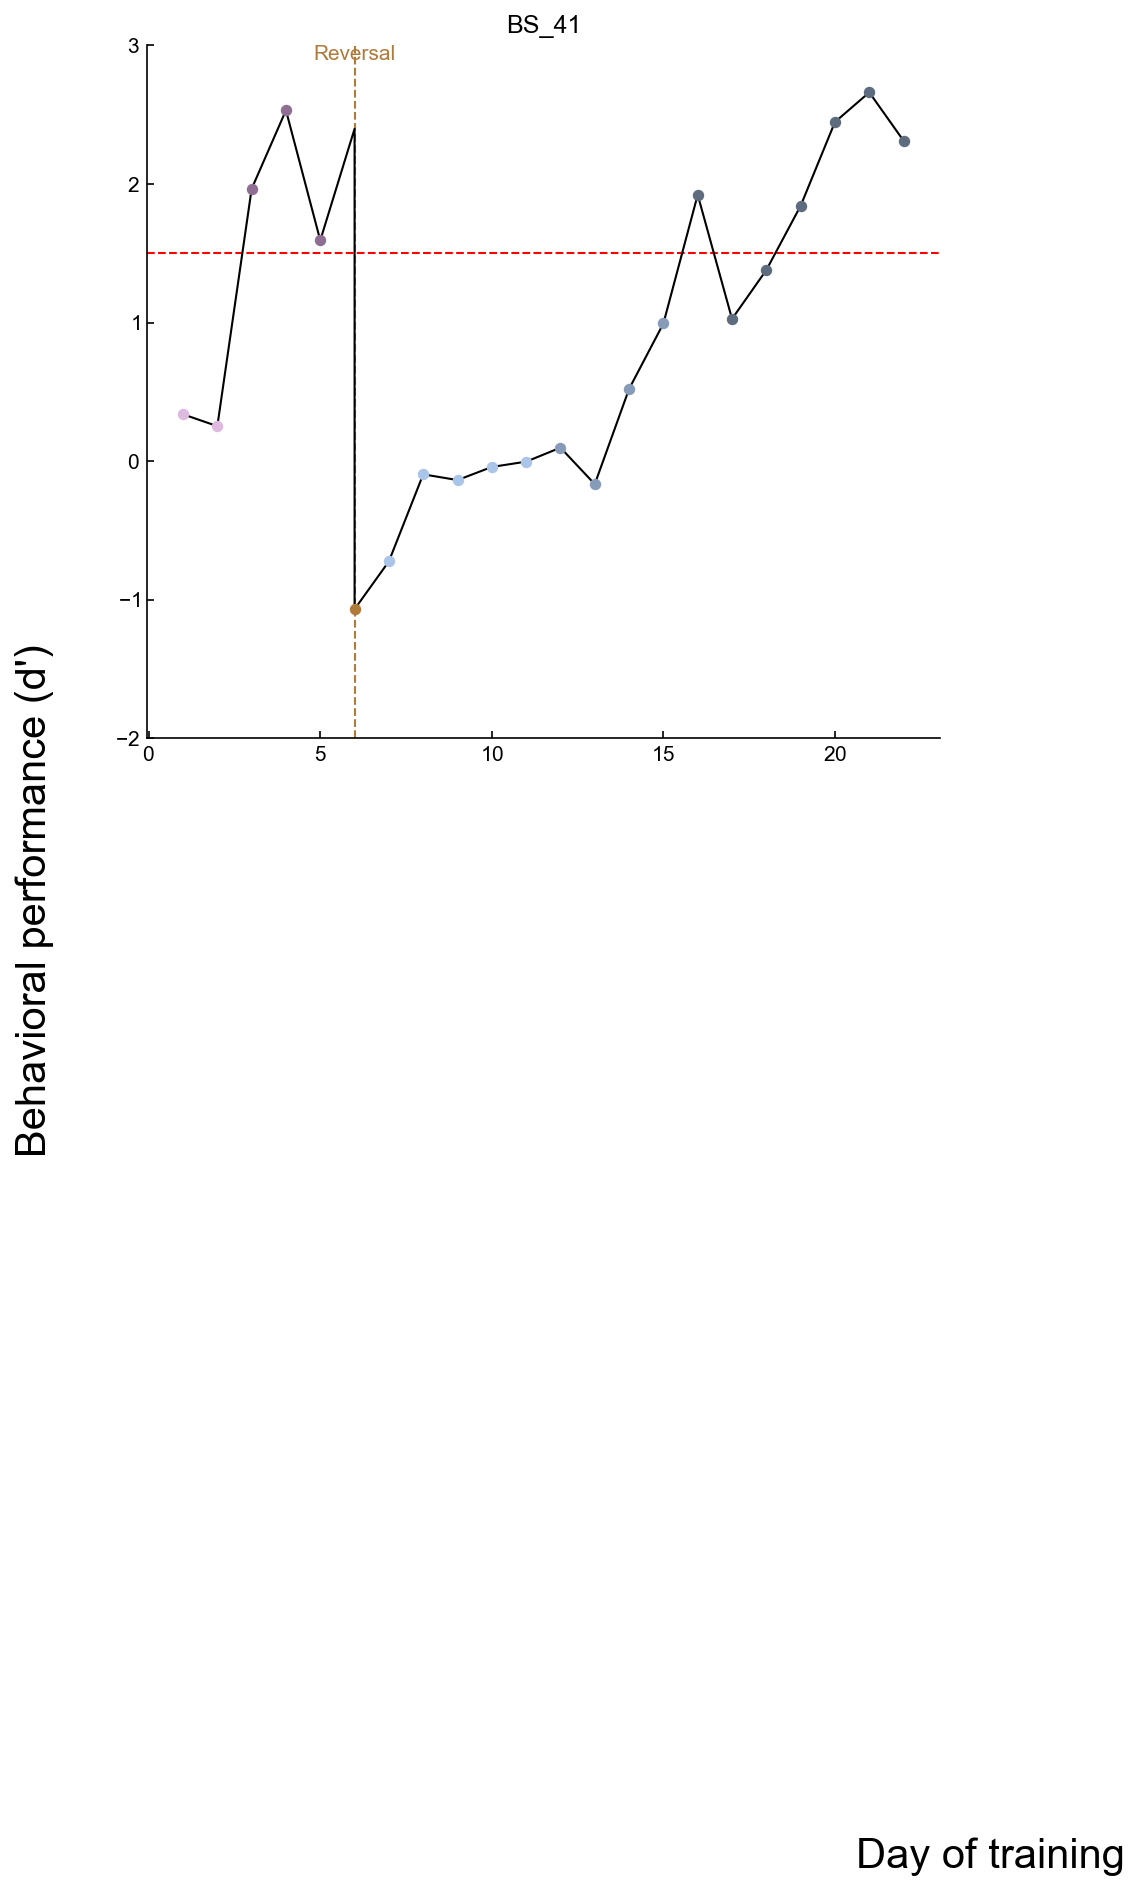

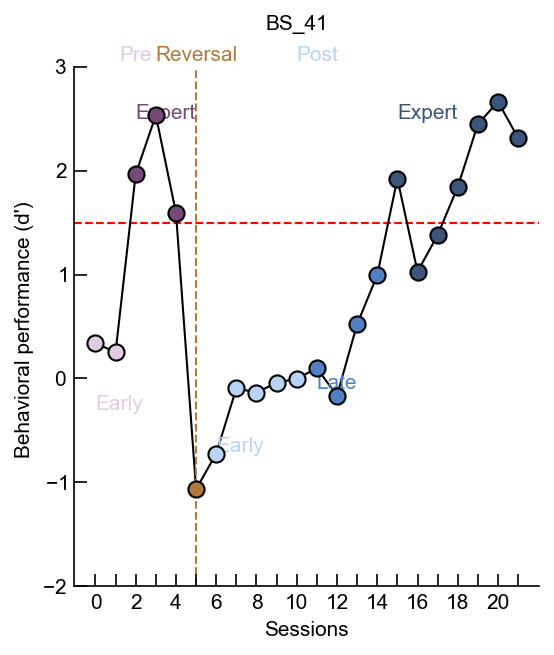

posx and posy should be finite values
posx and posy should be finite values


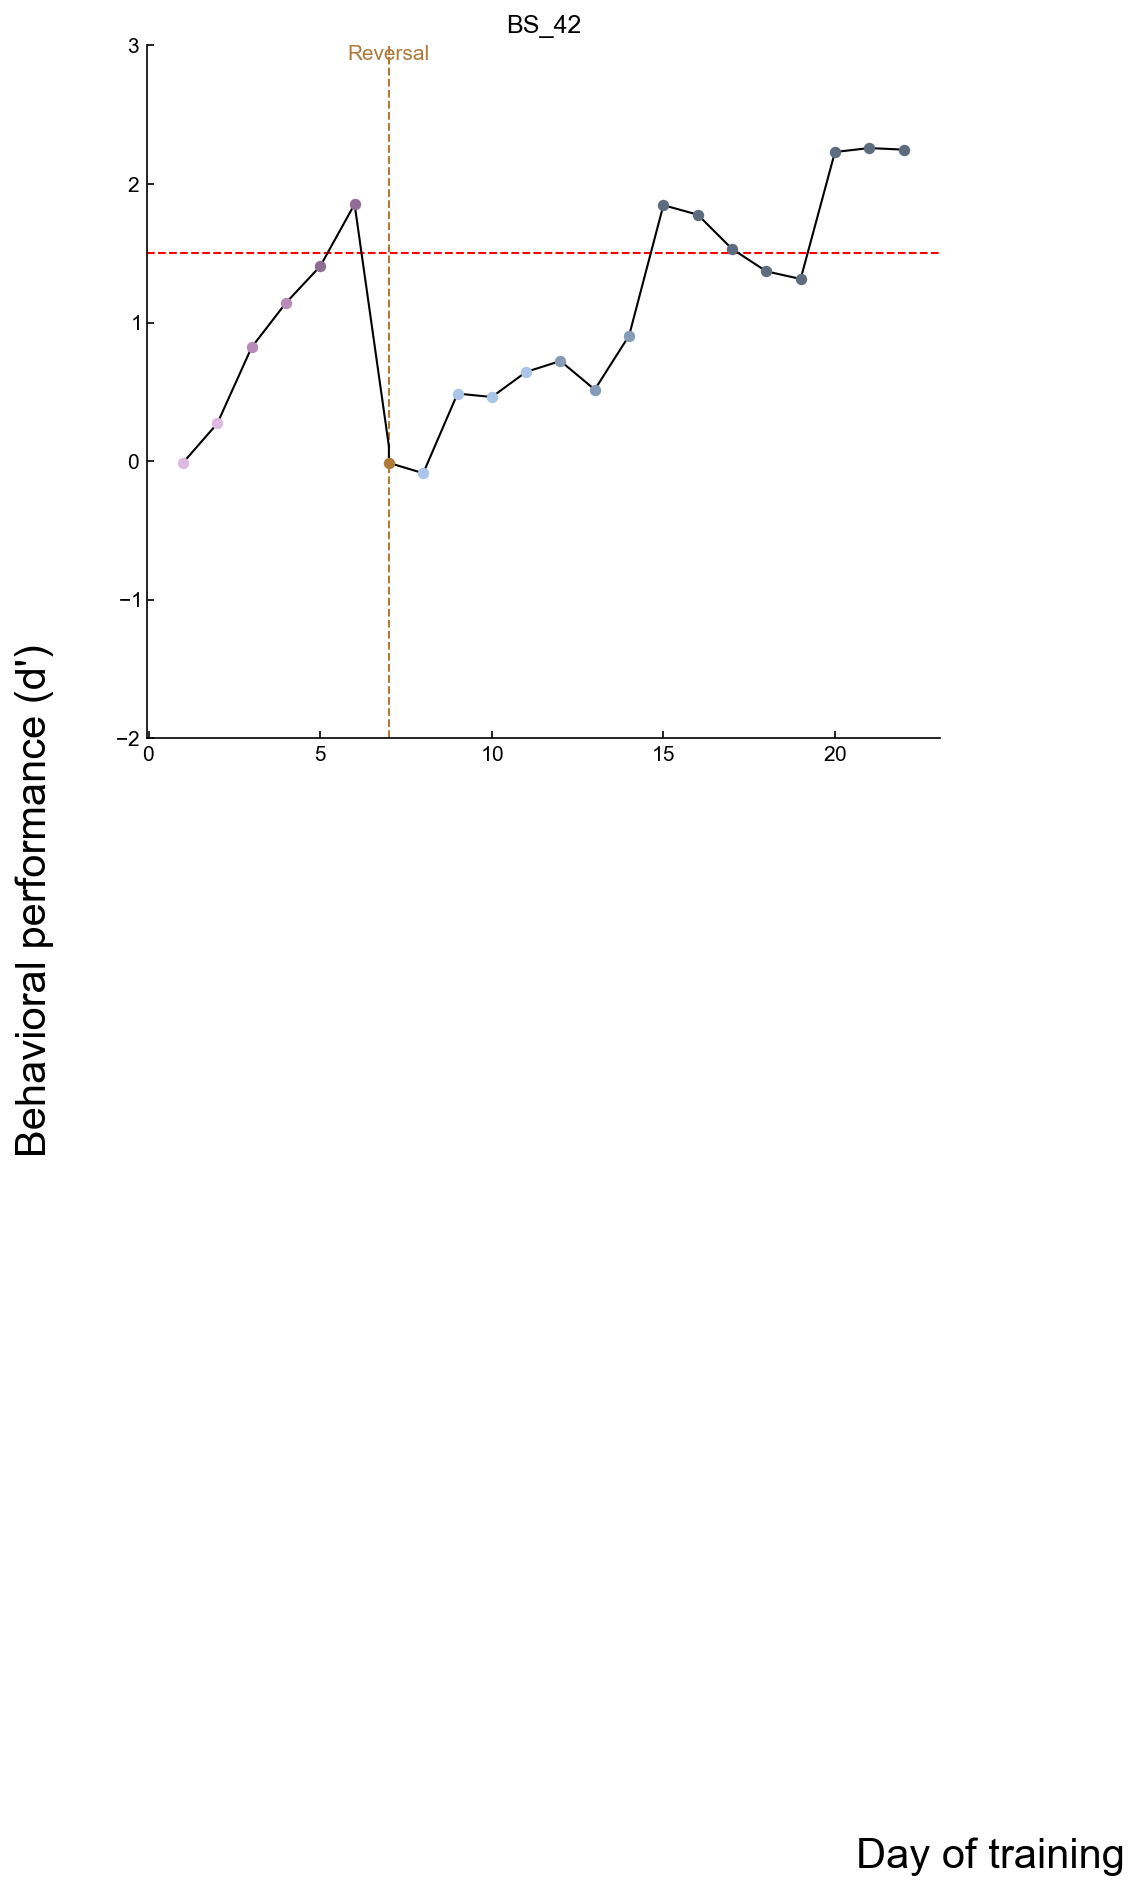

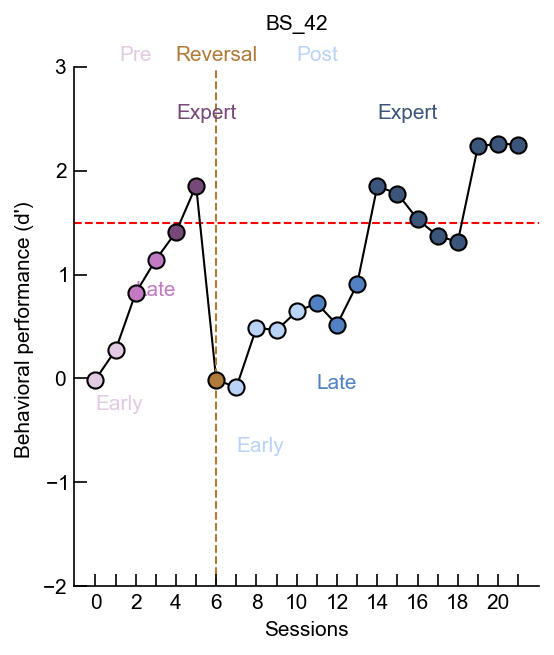

posx and posy should be finite values
posx and posy should be finite values


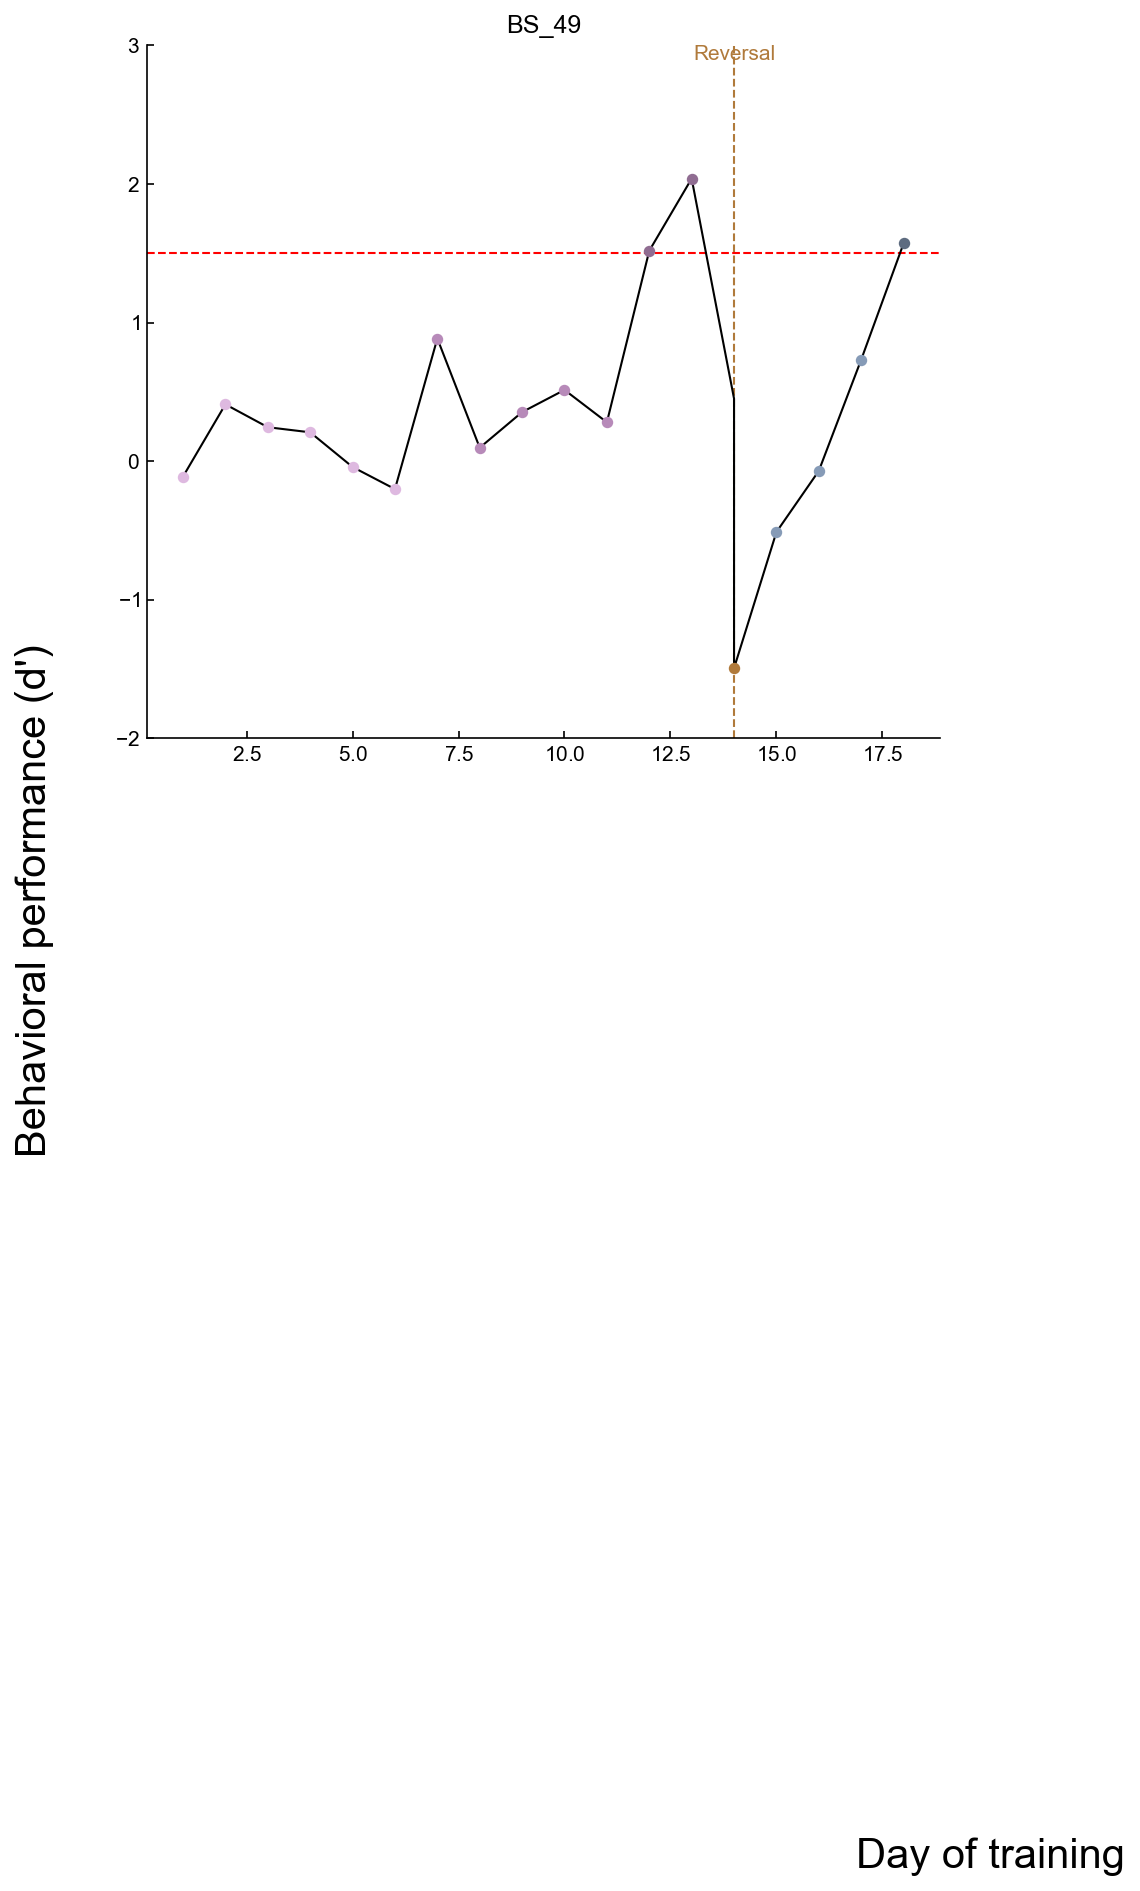

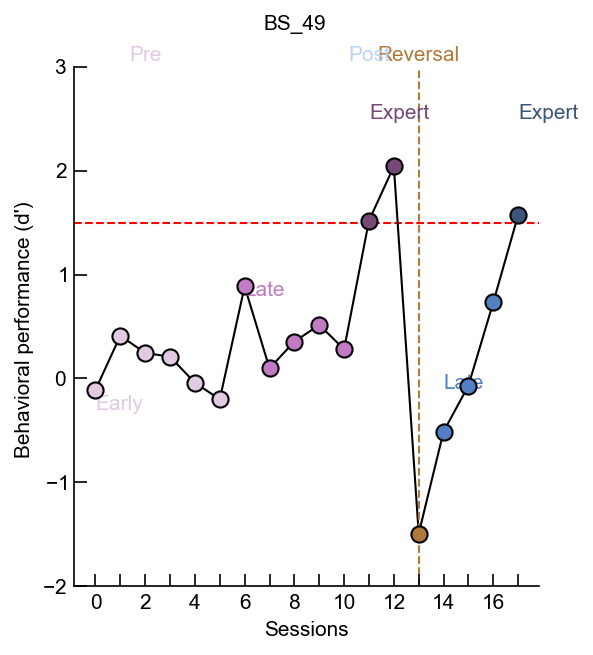

posx and posy should be finite values
posx and posy should be finite values


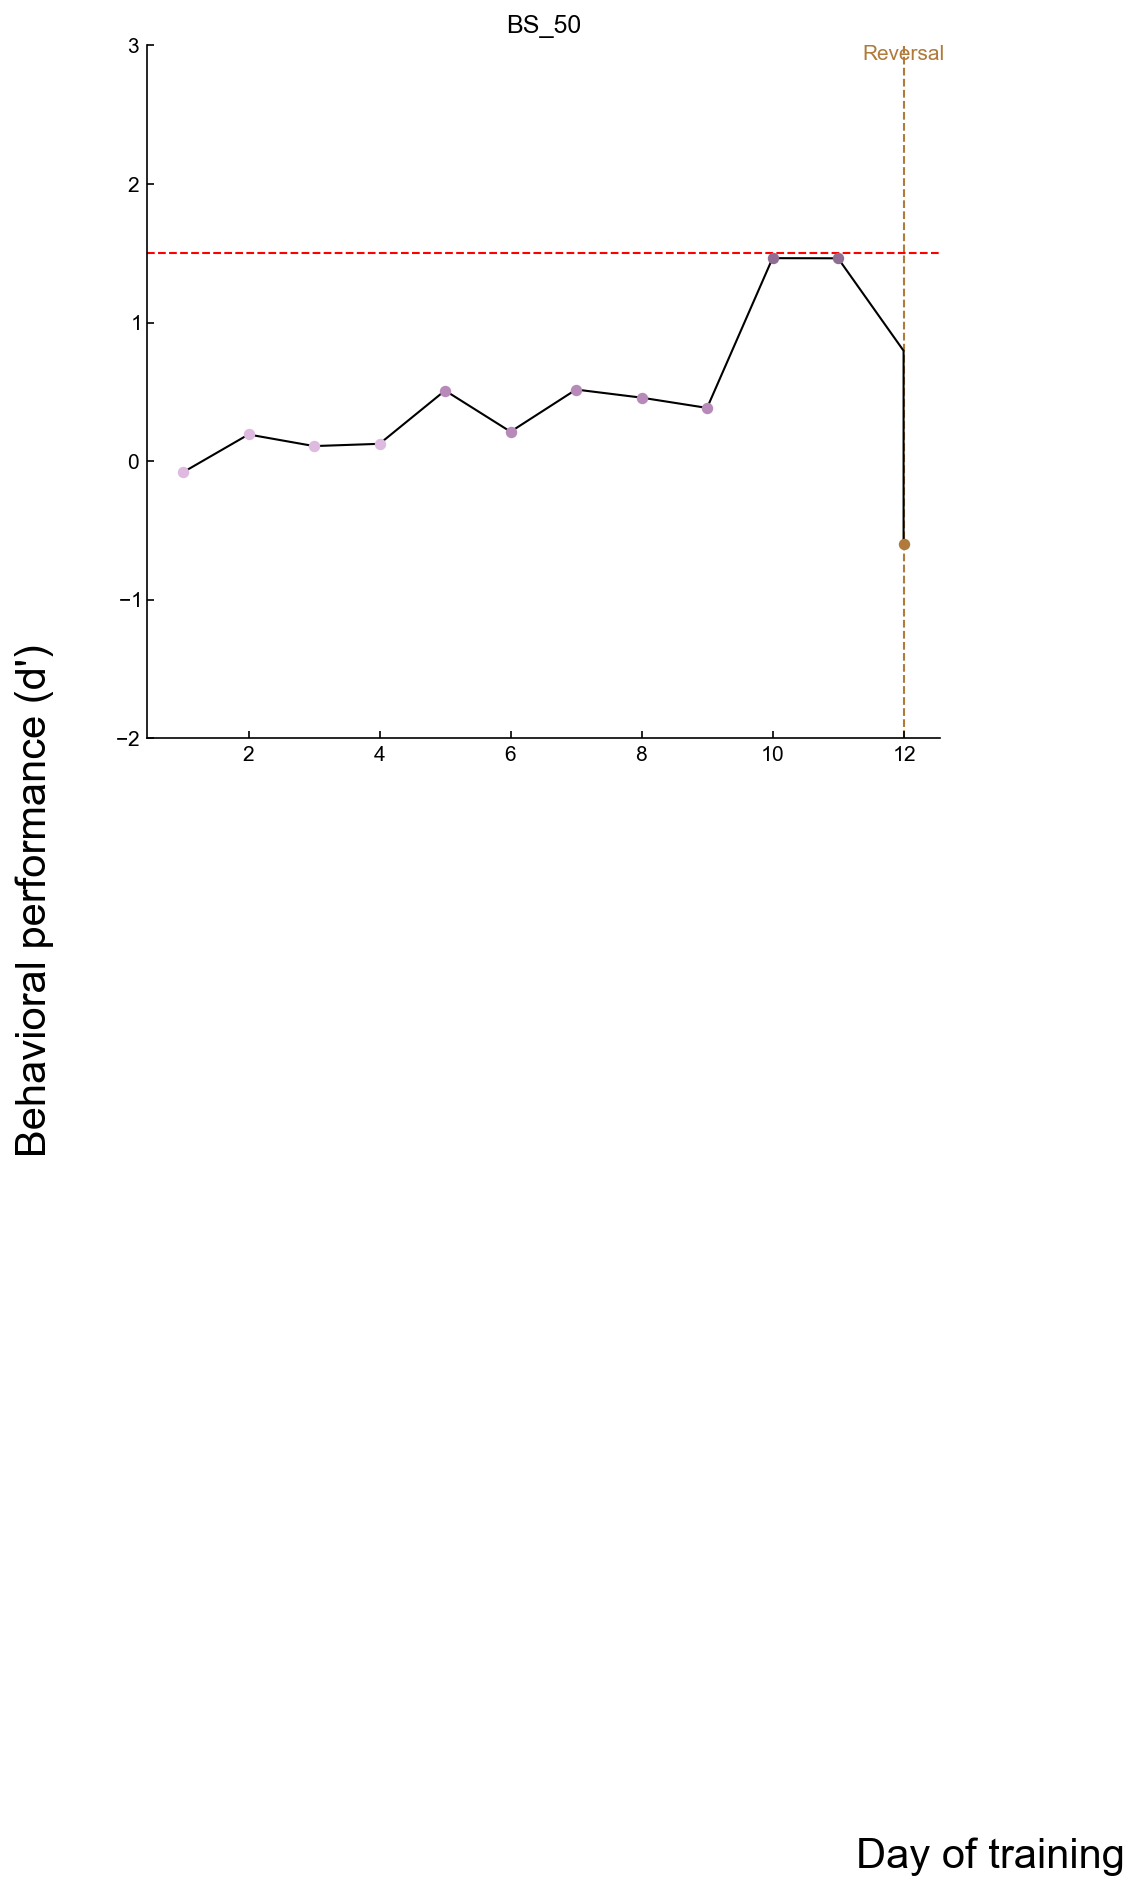

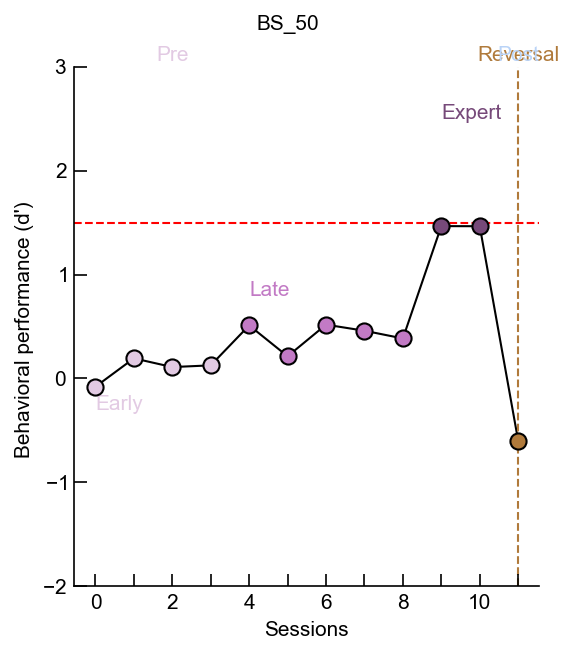

posx and posy should be finite values
posx and posy should be finite values


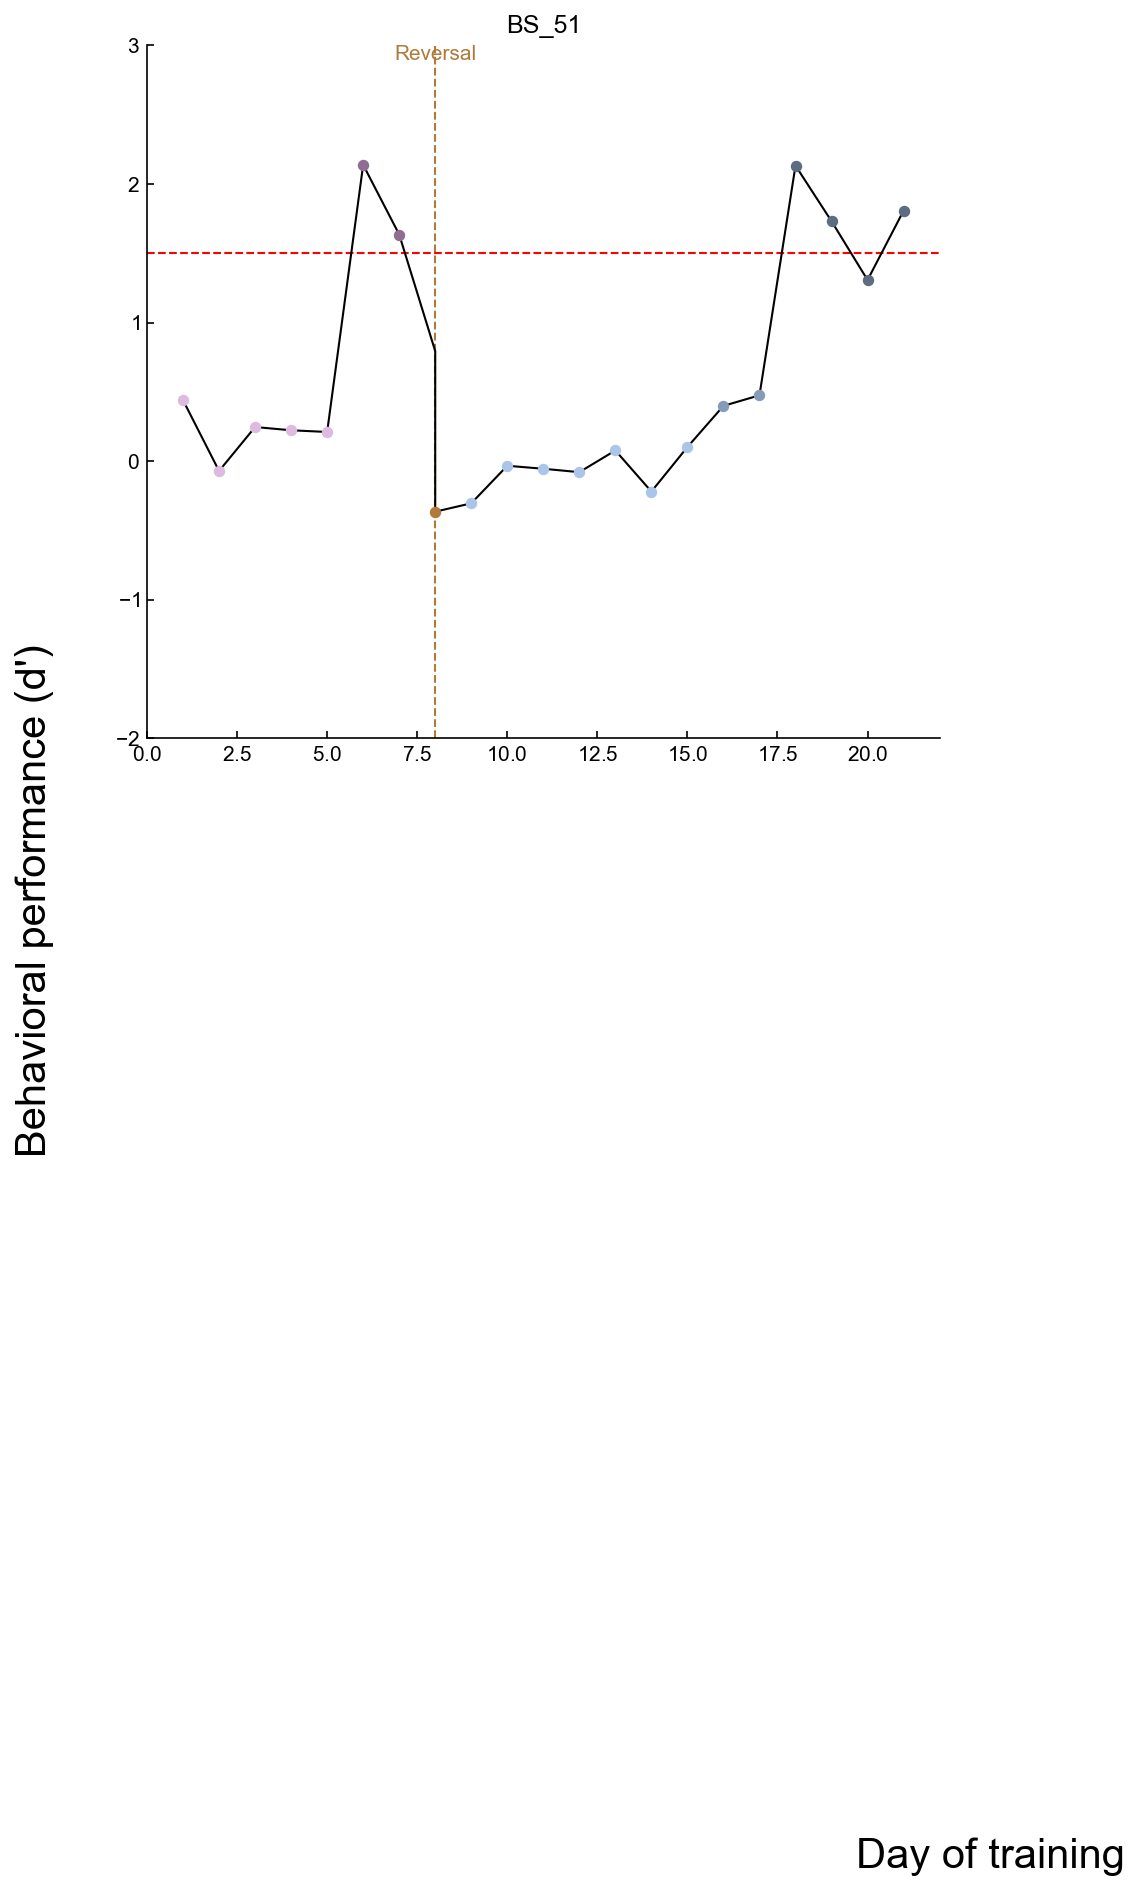

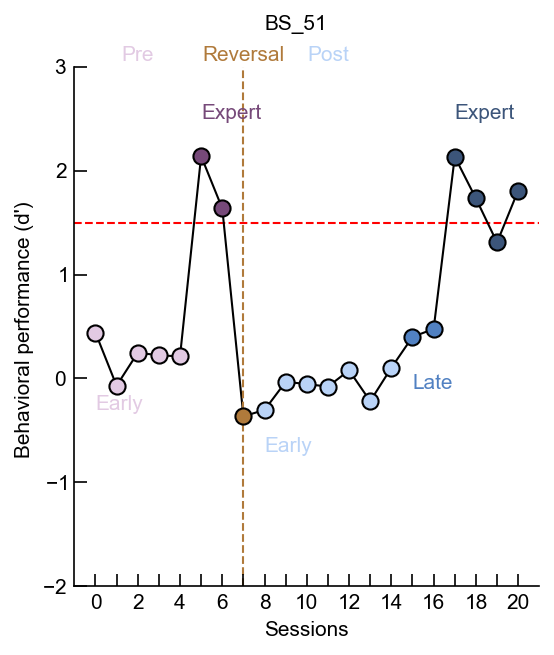

posx and posy should be finite values
posx and posy should be finite values


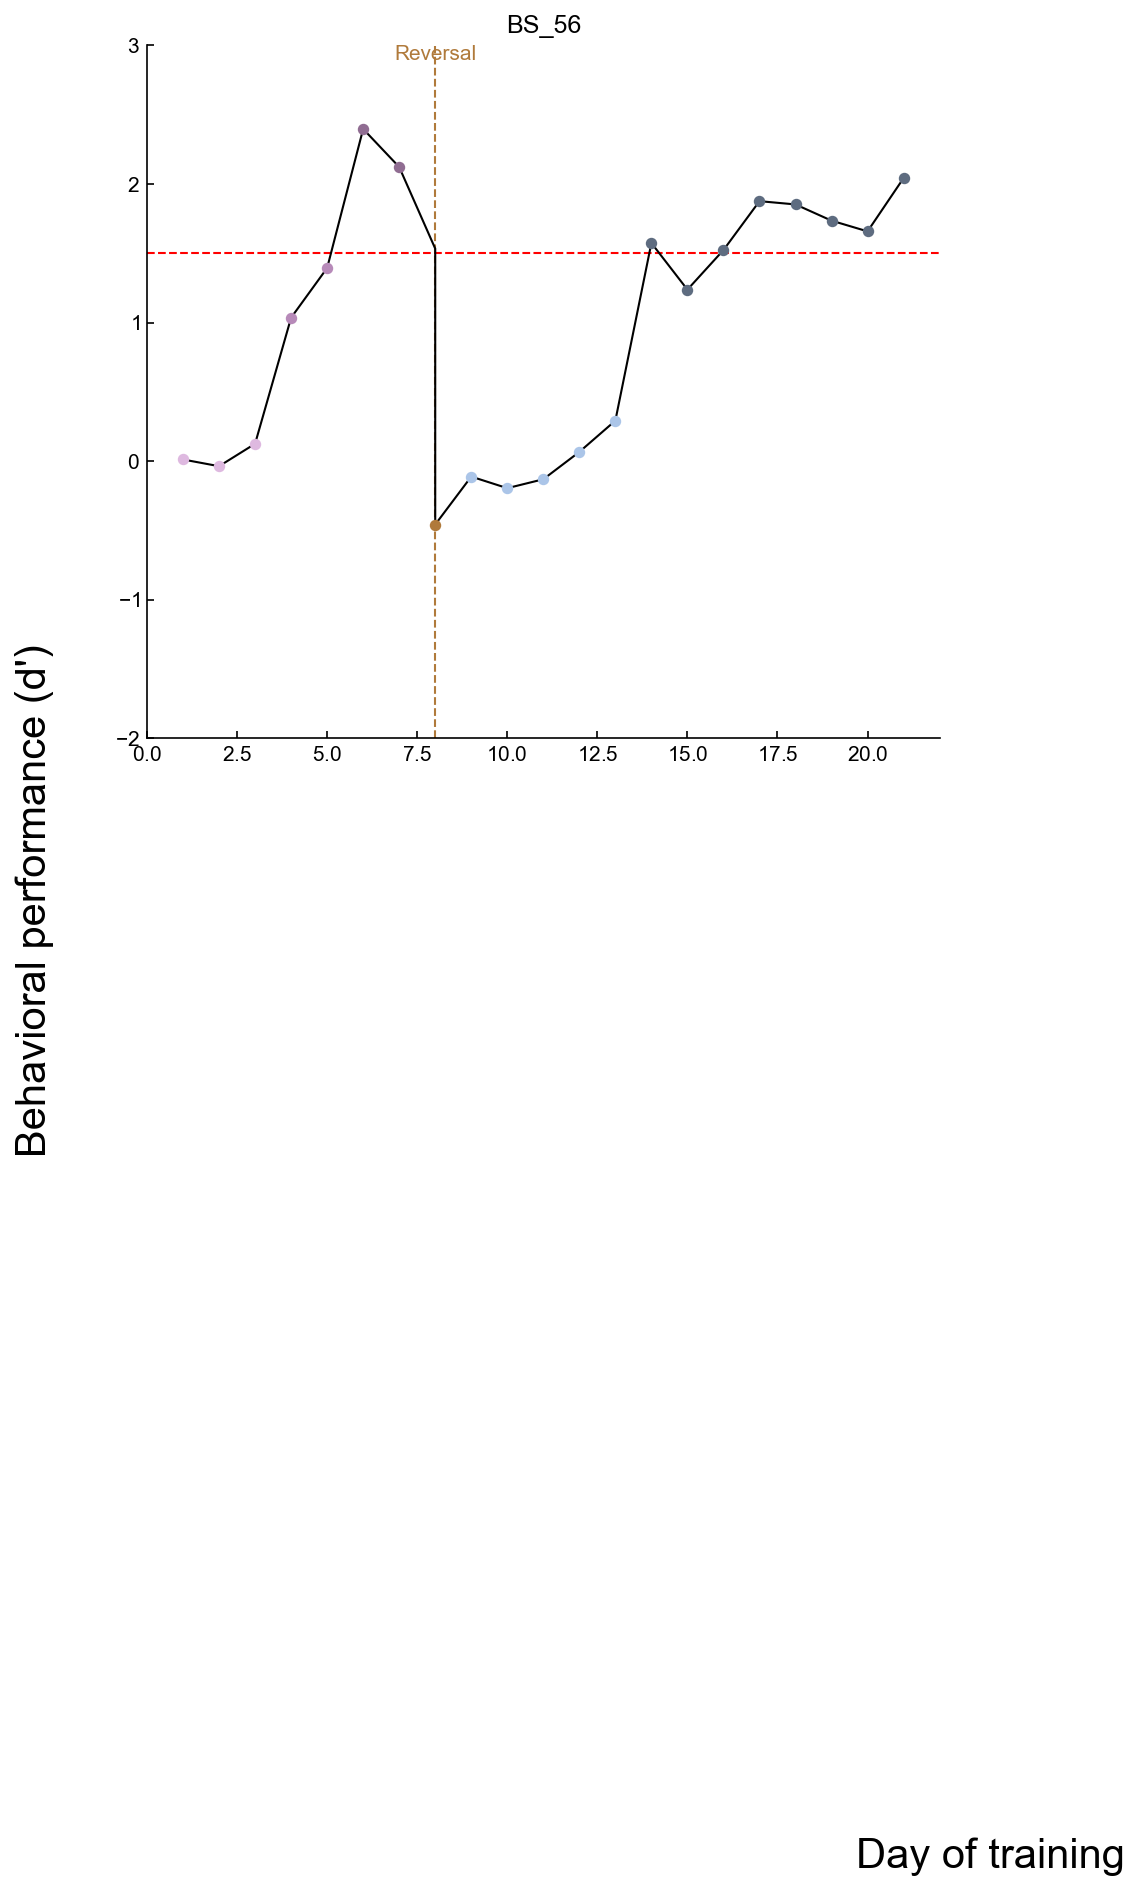

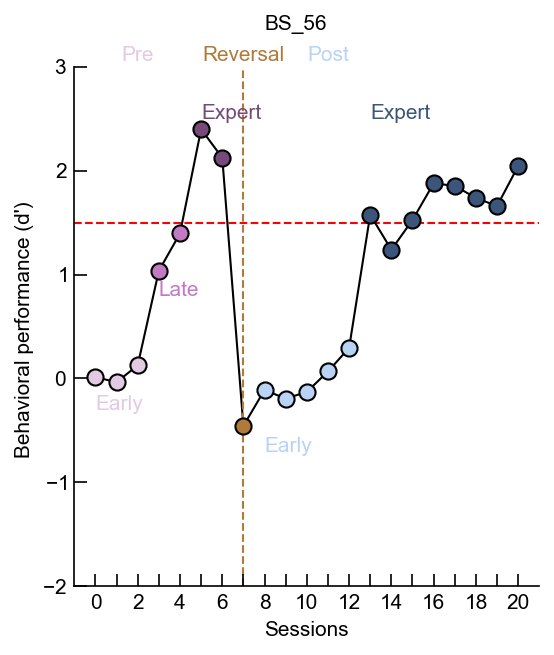

posx and posy should be finite values
posx and posy should be finite values


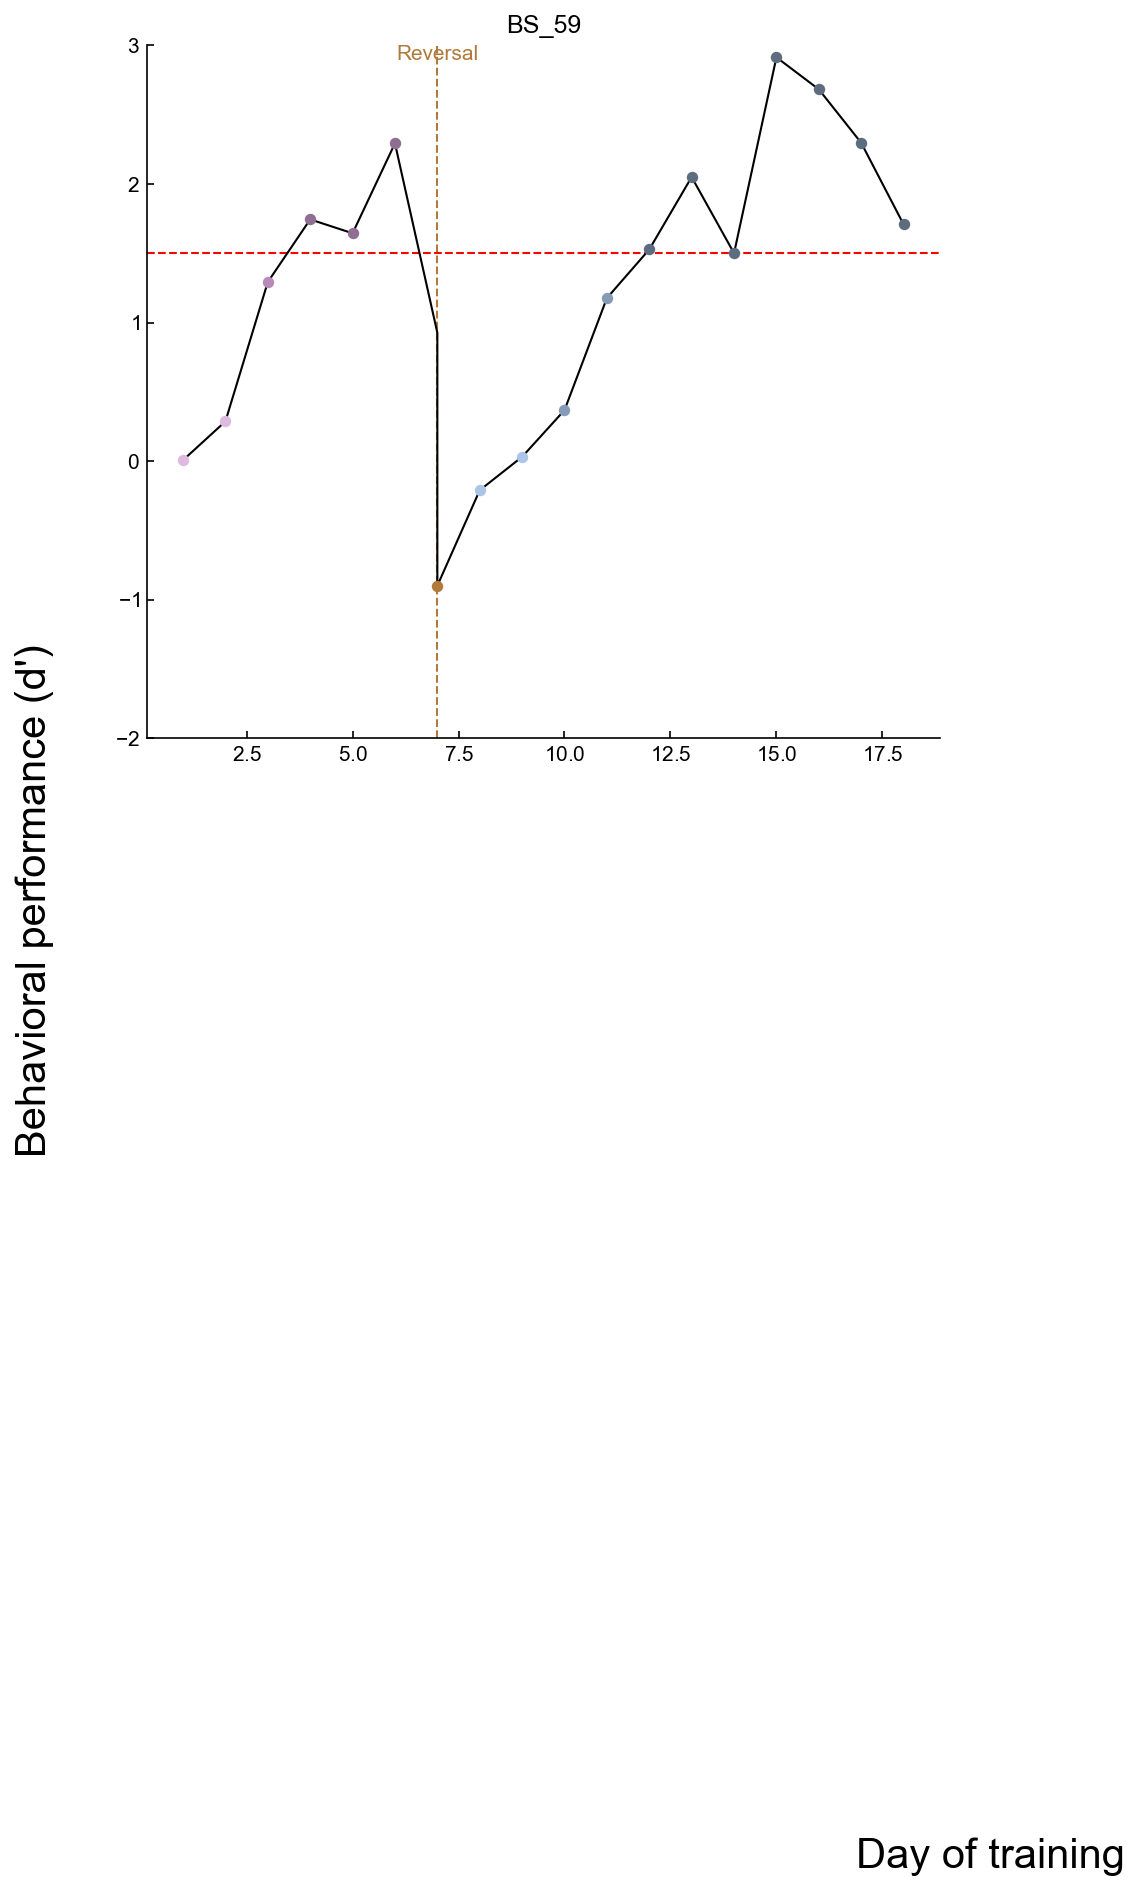

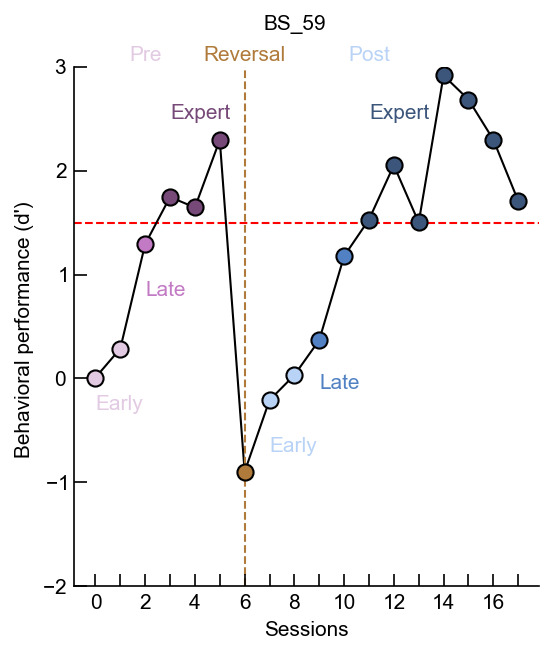

posx and posy should be finite values
posx and posy should be finite values


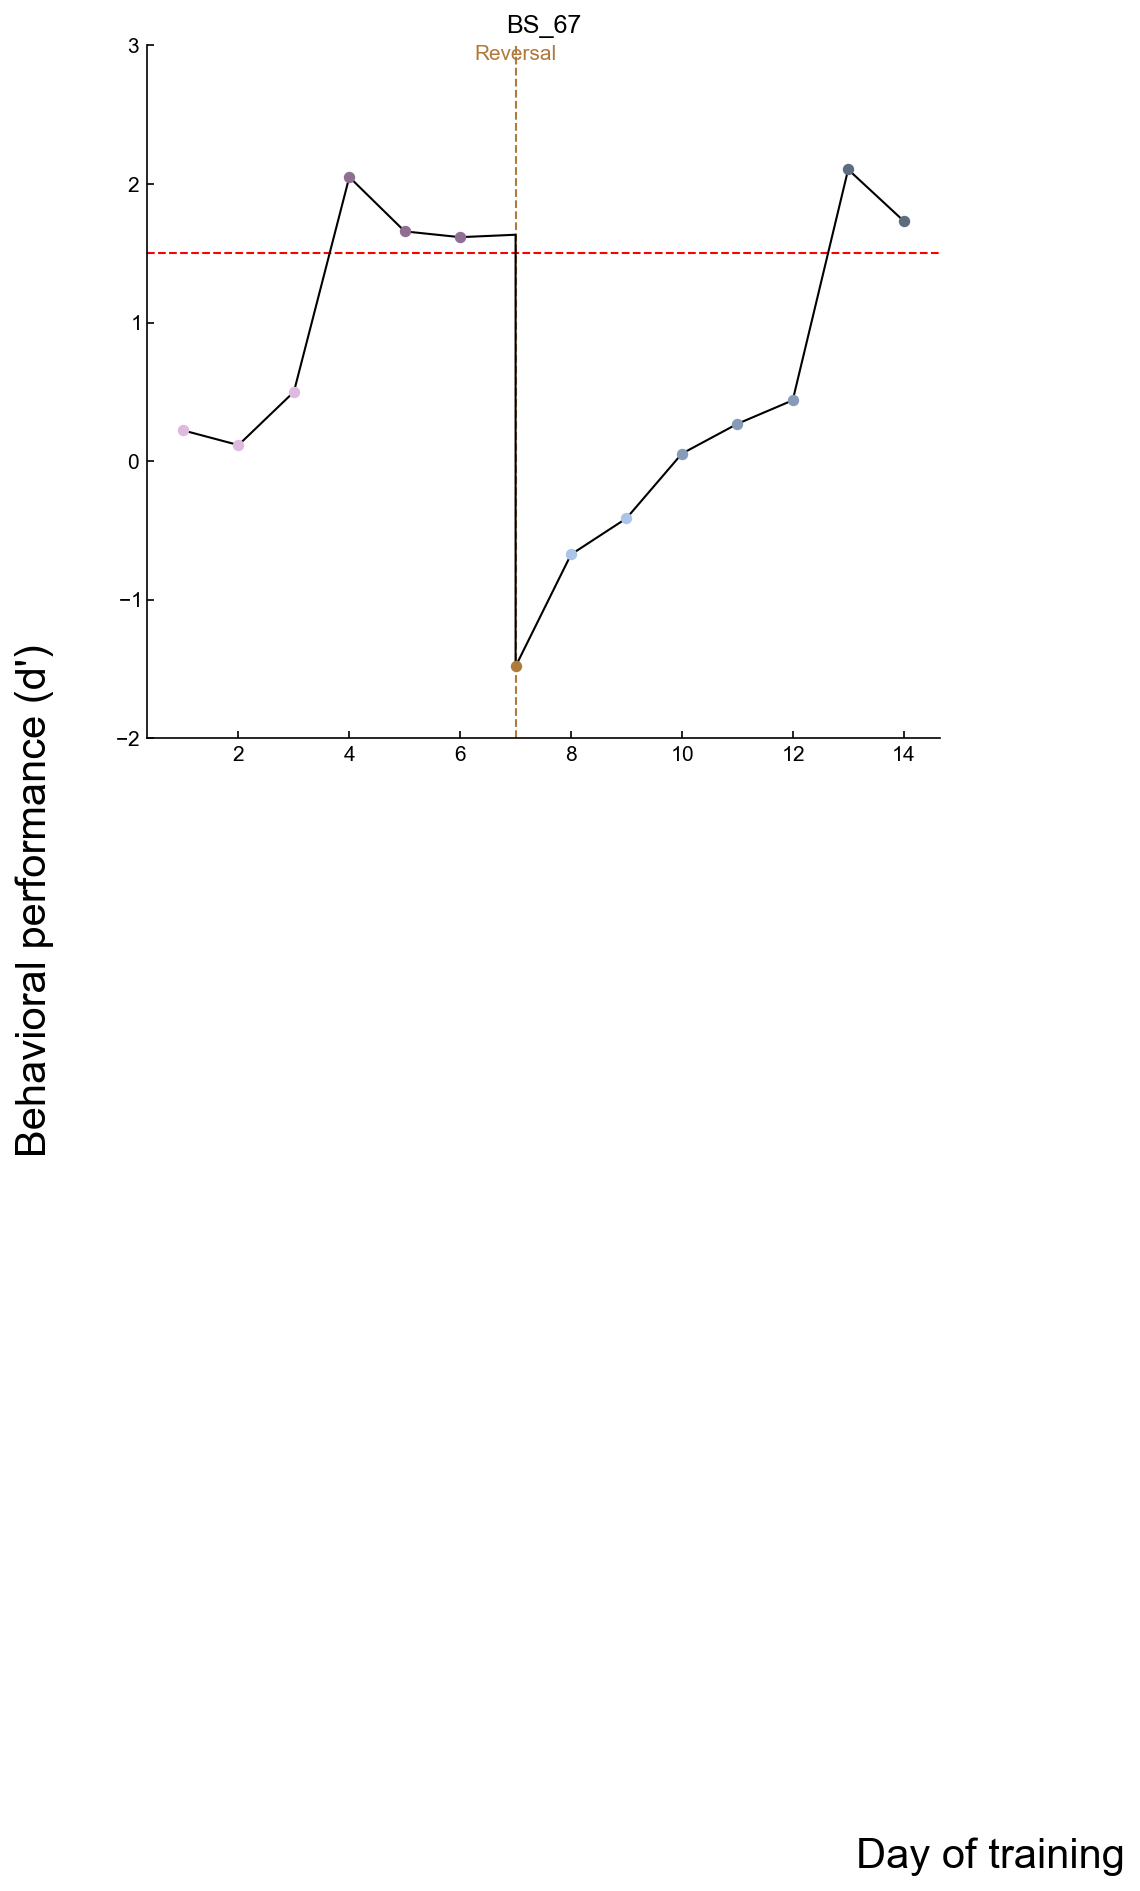

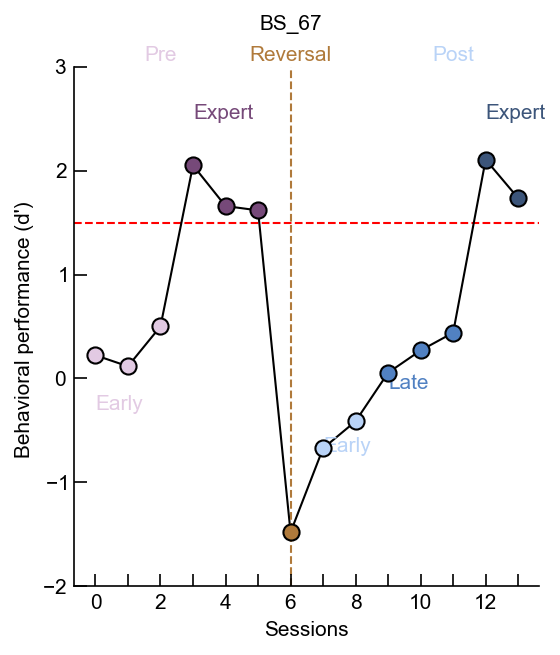

posx and posy should be finite values
posx and posy should be finite values


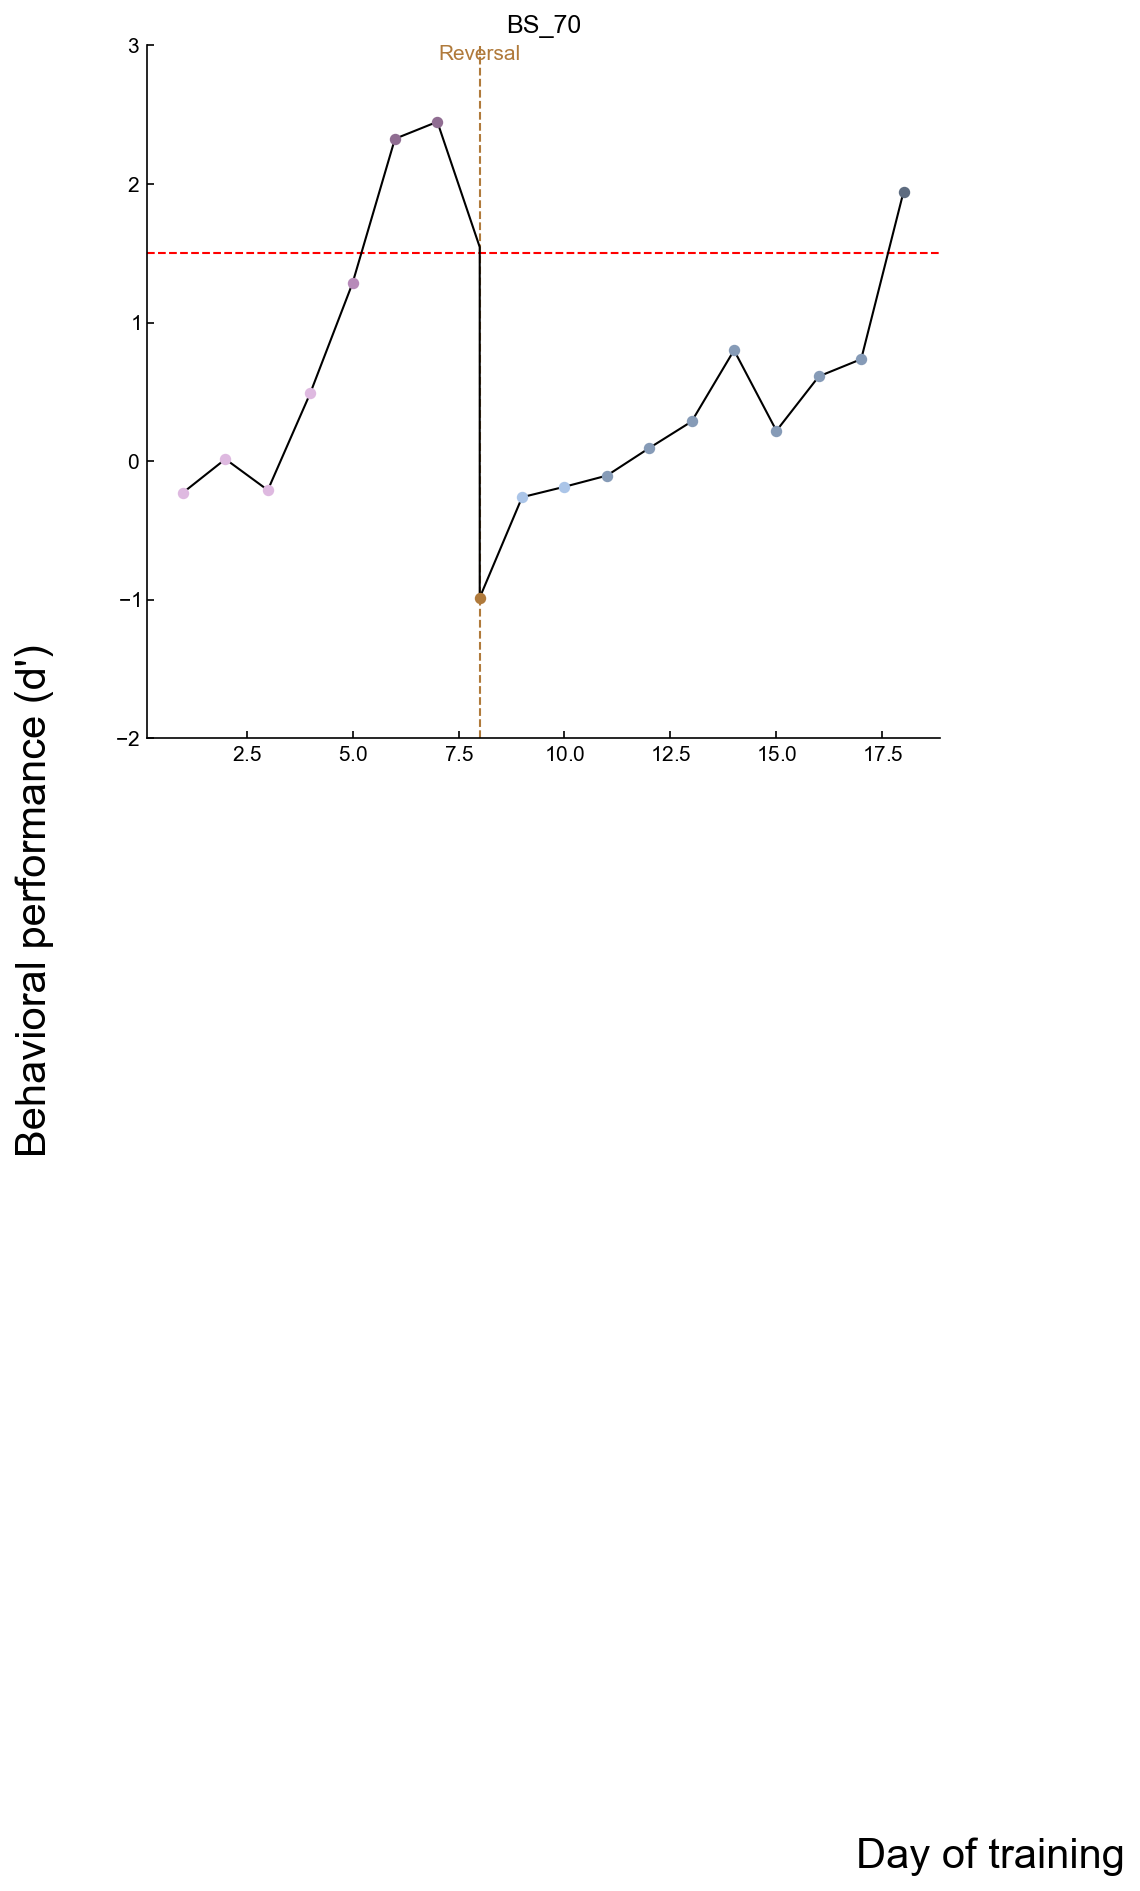

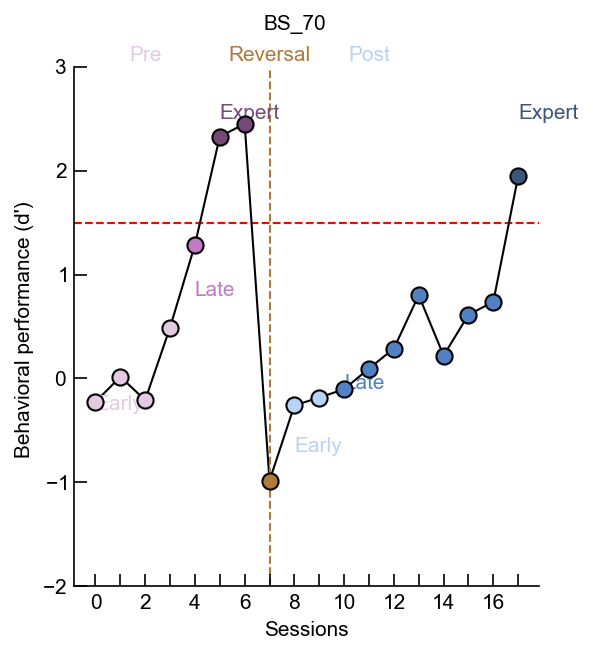

posx and posy should be finite values
posx and posy should be finite values


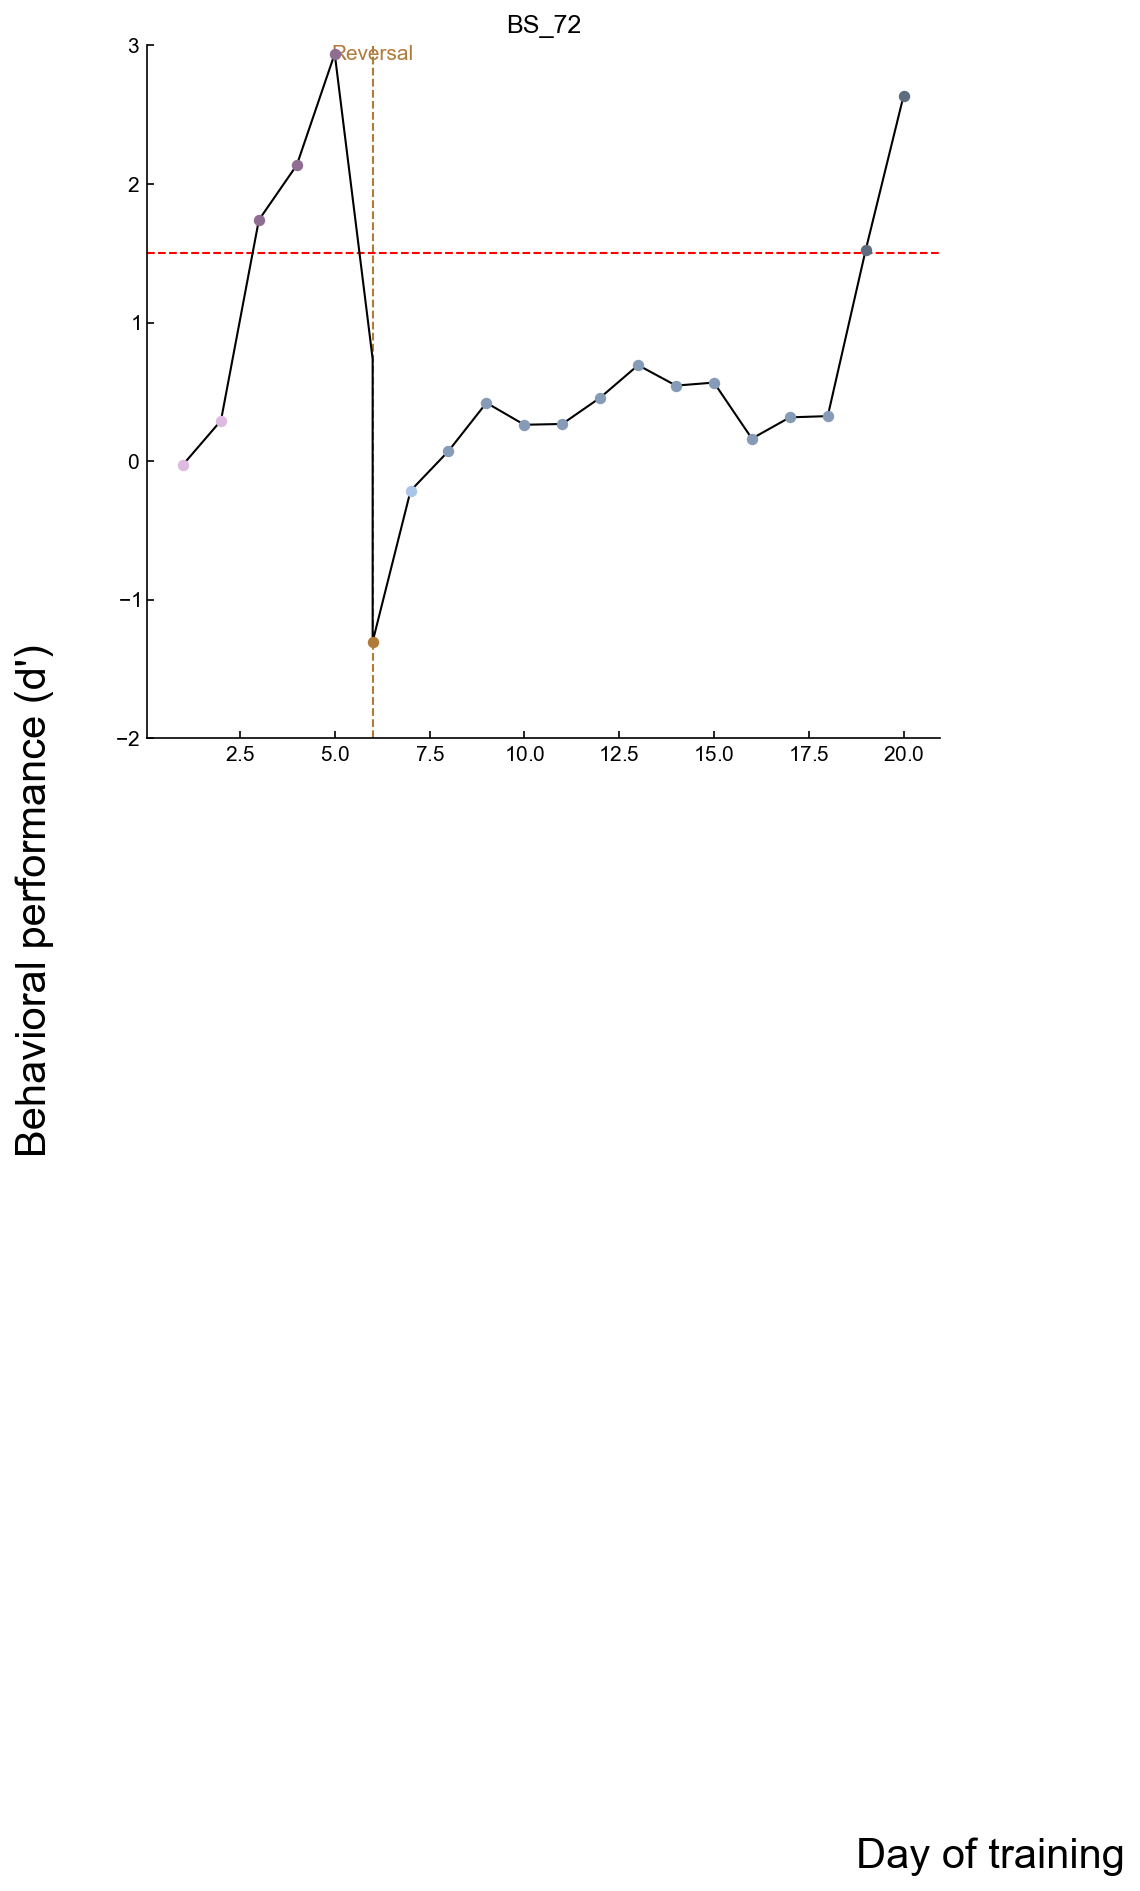

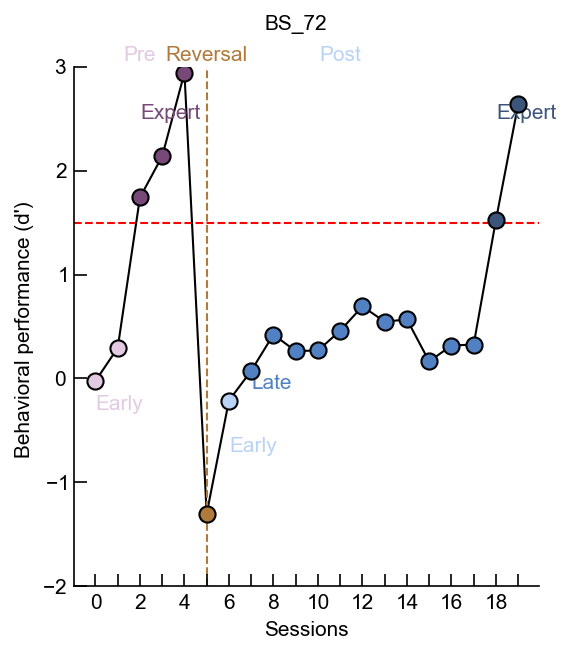

posx and posy should be finite values
posx and posy should be finite values


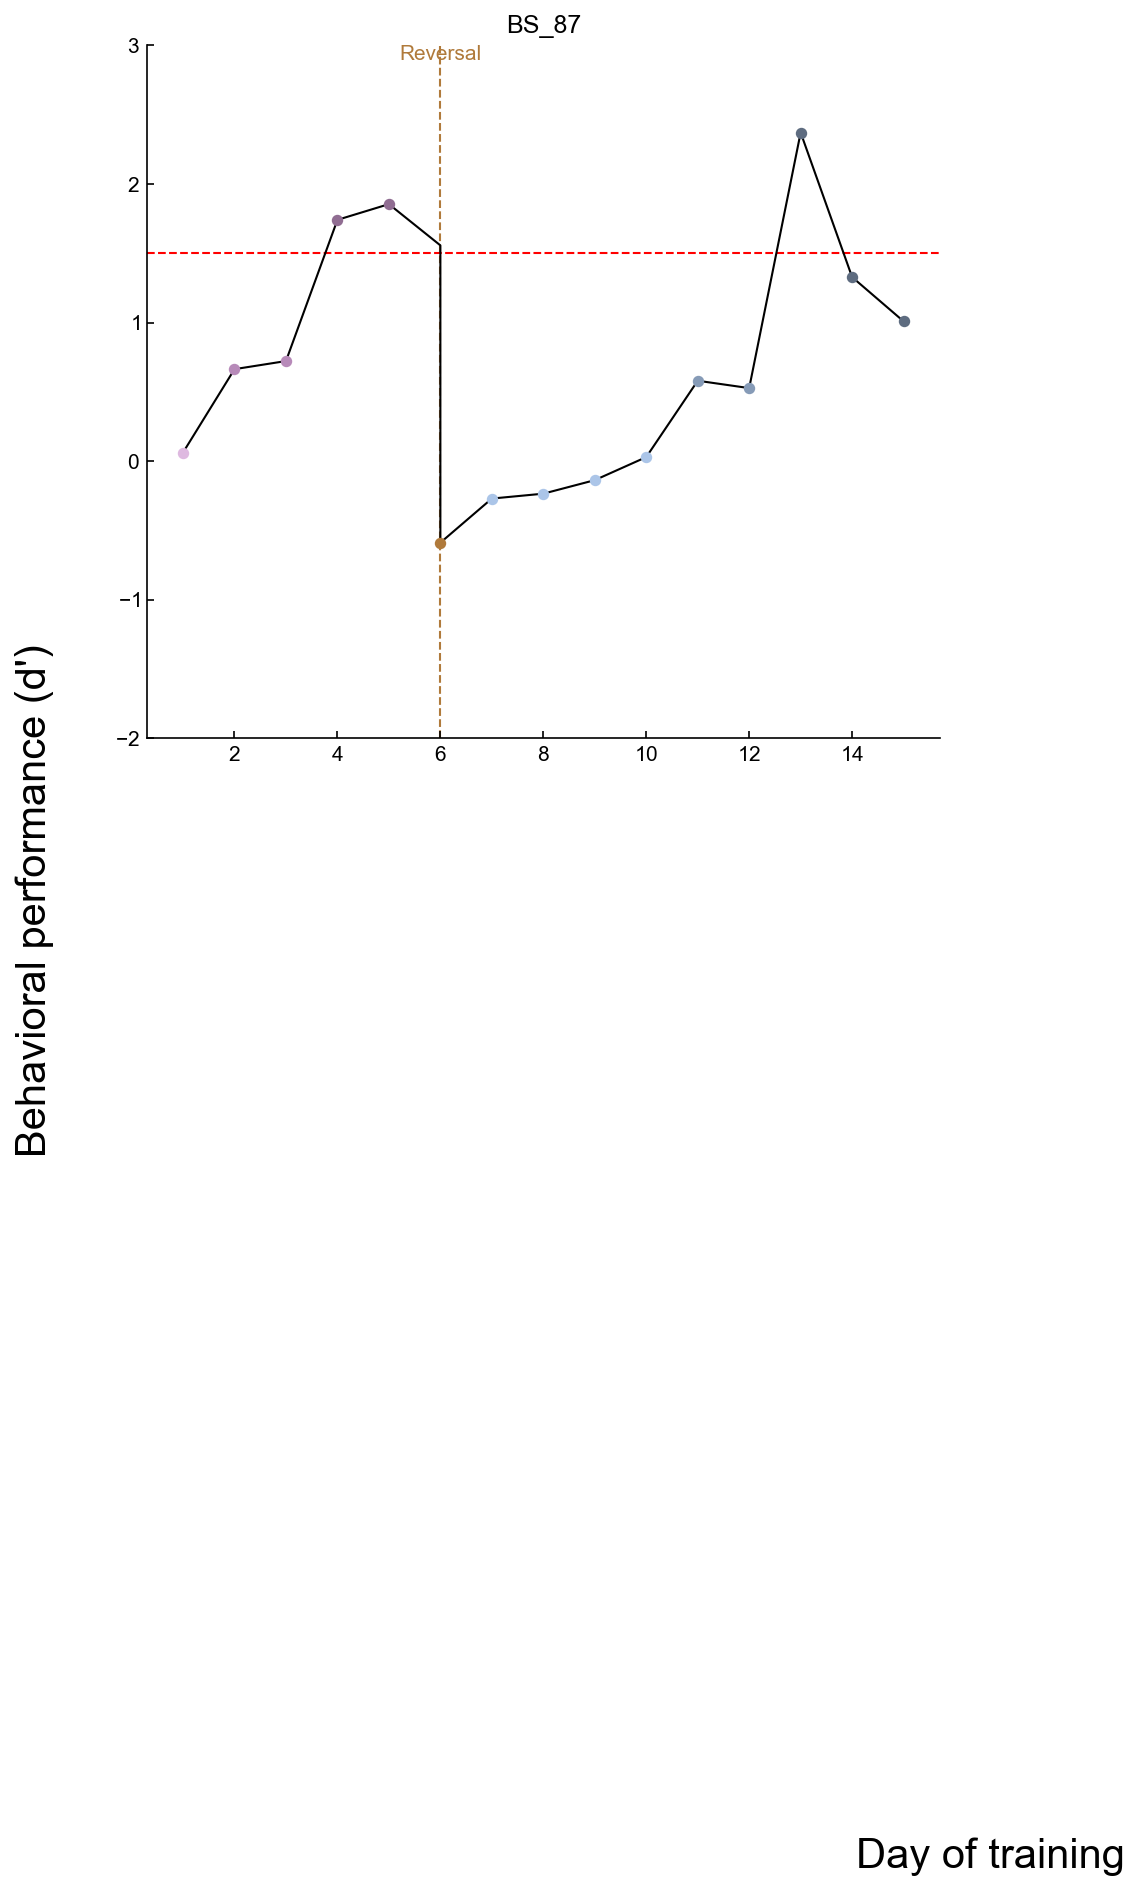

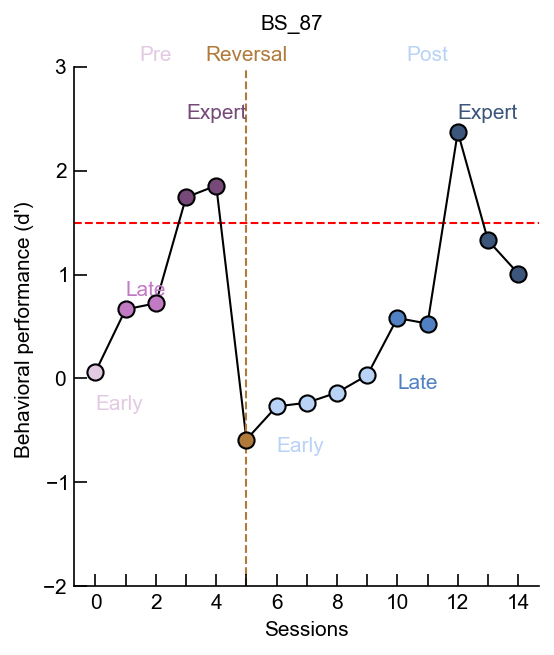

posx and posy should be finite values
posx and posy should be finite values


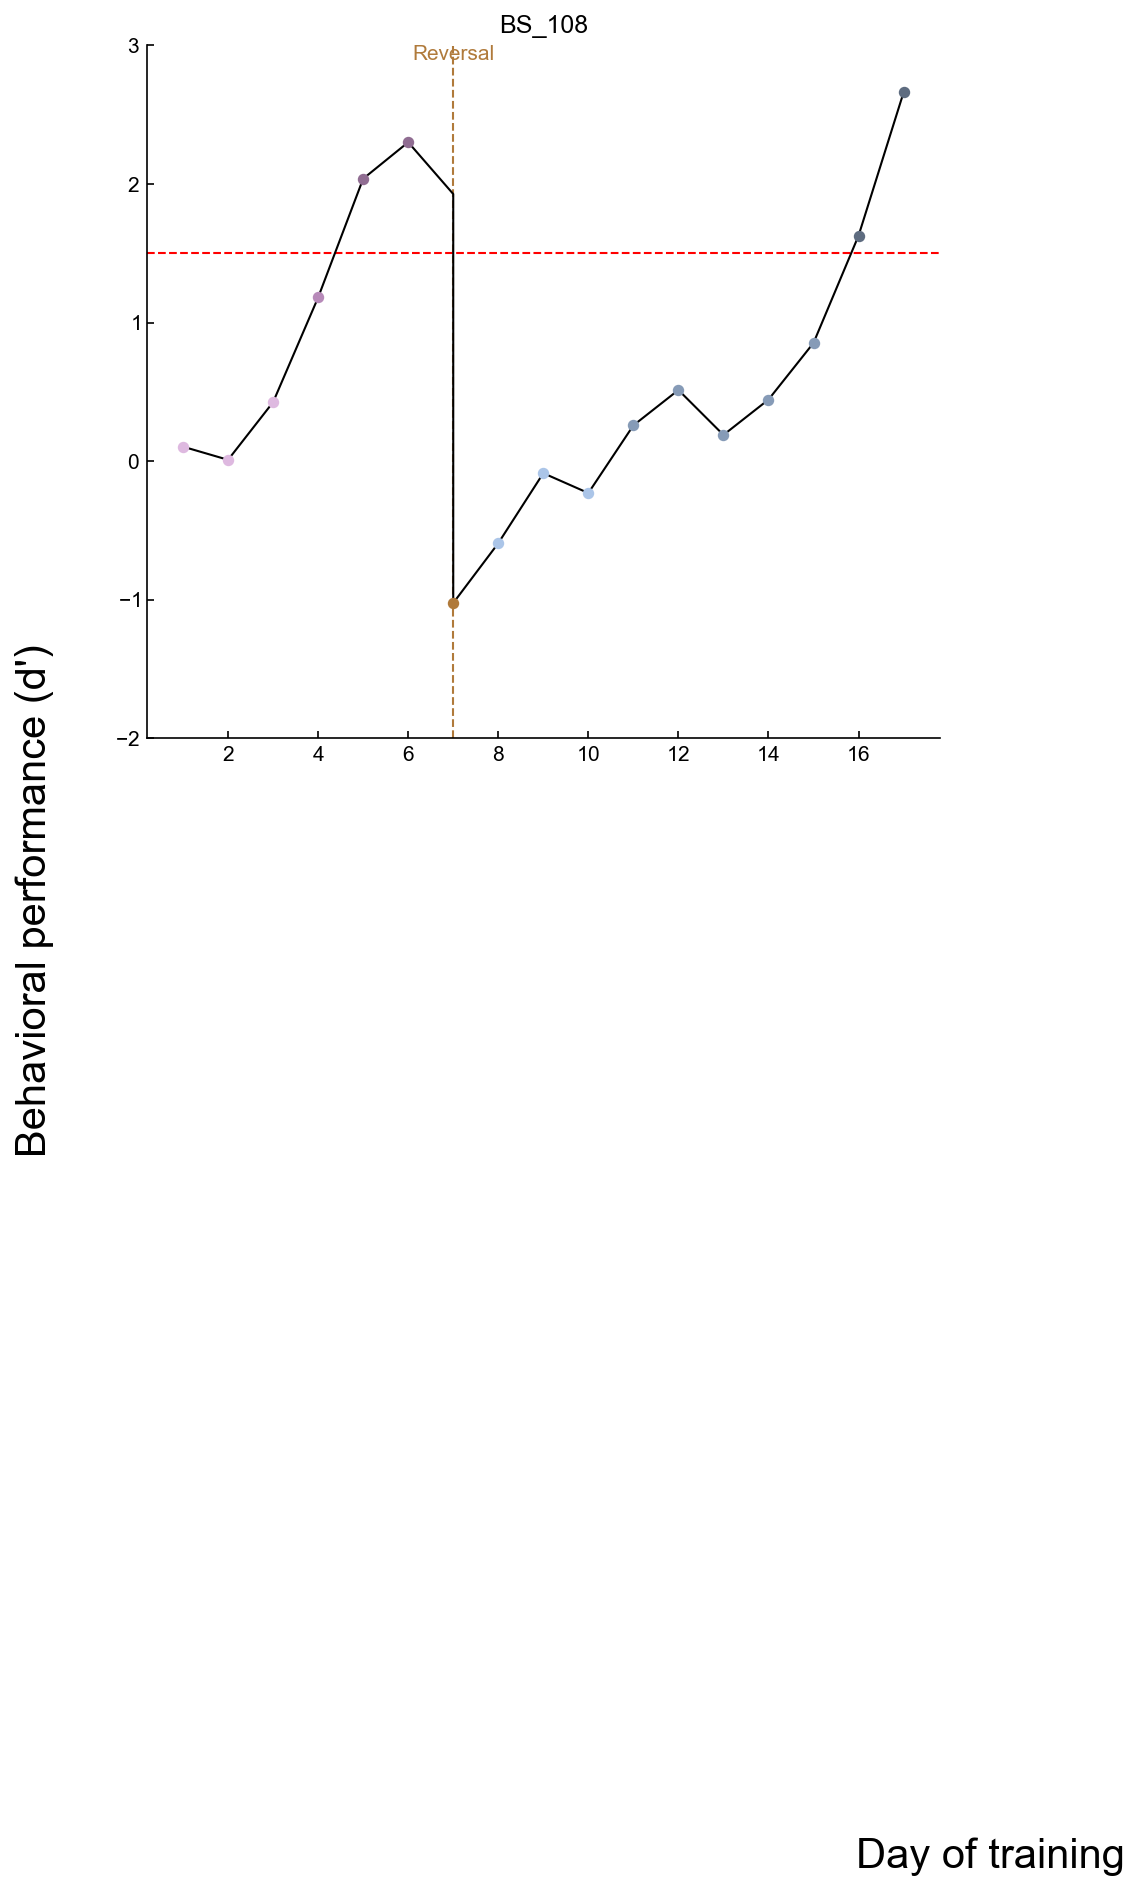

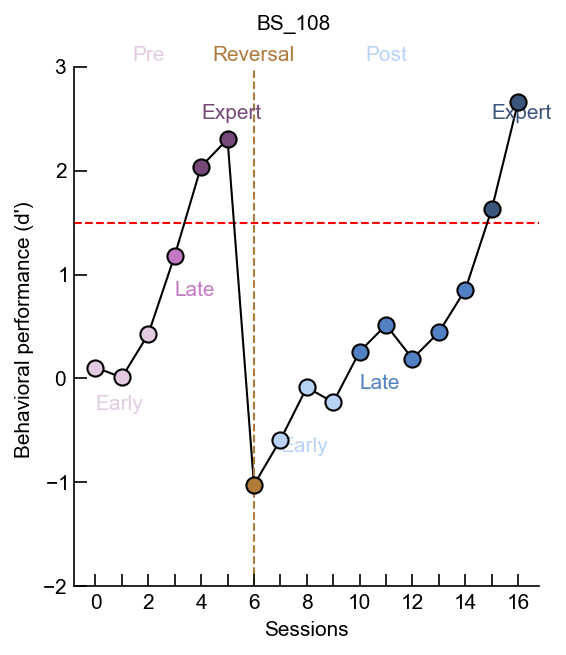

posx and posy should be finite values
posx and posy should be finite values


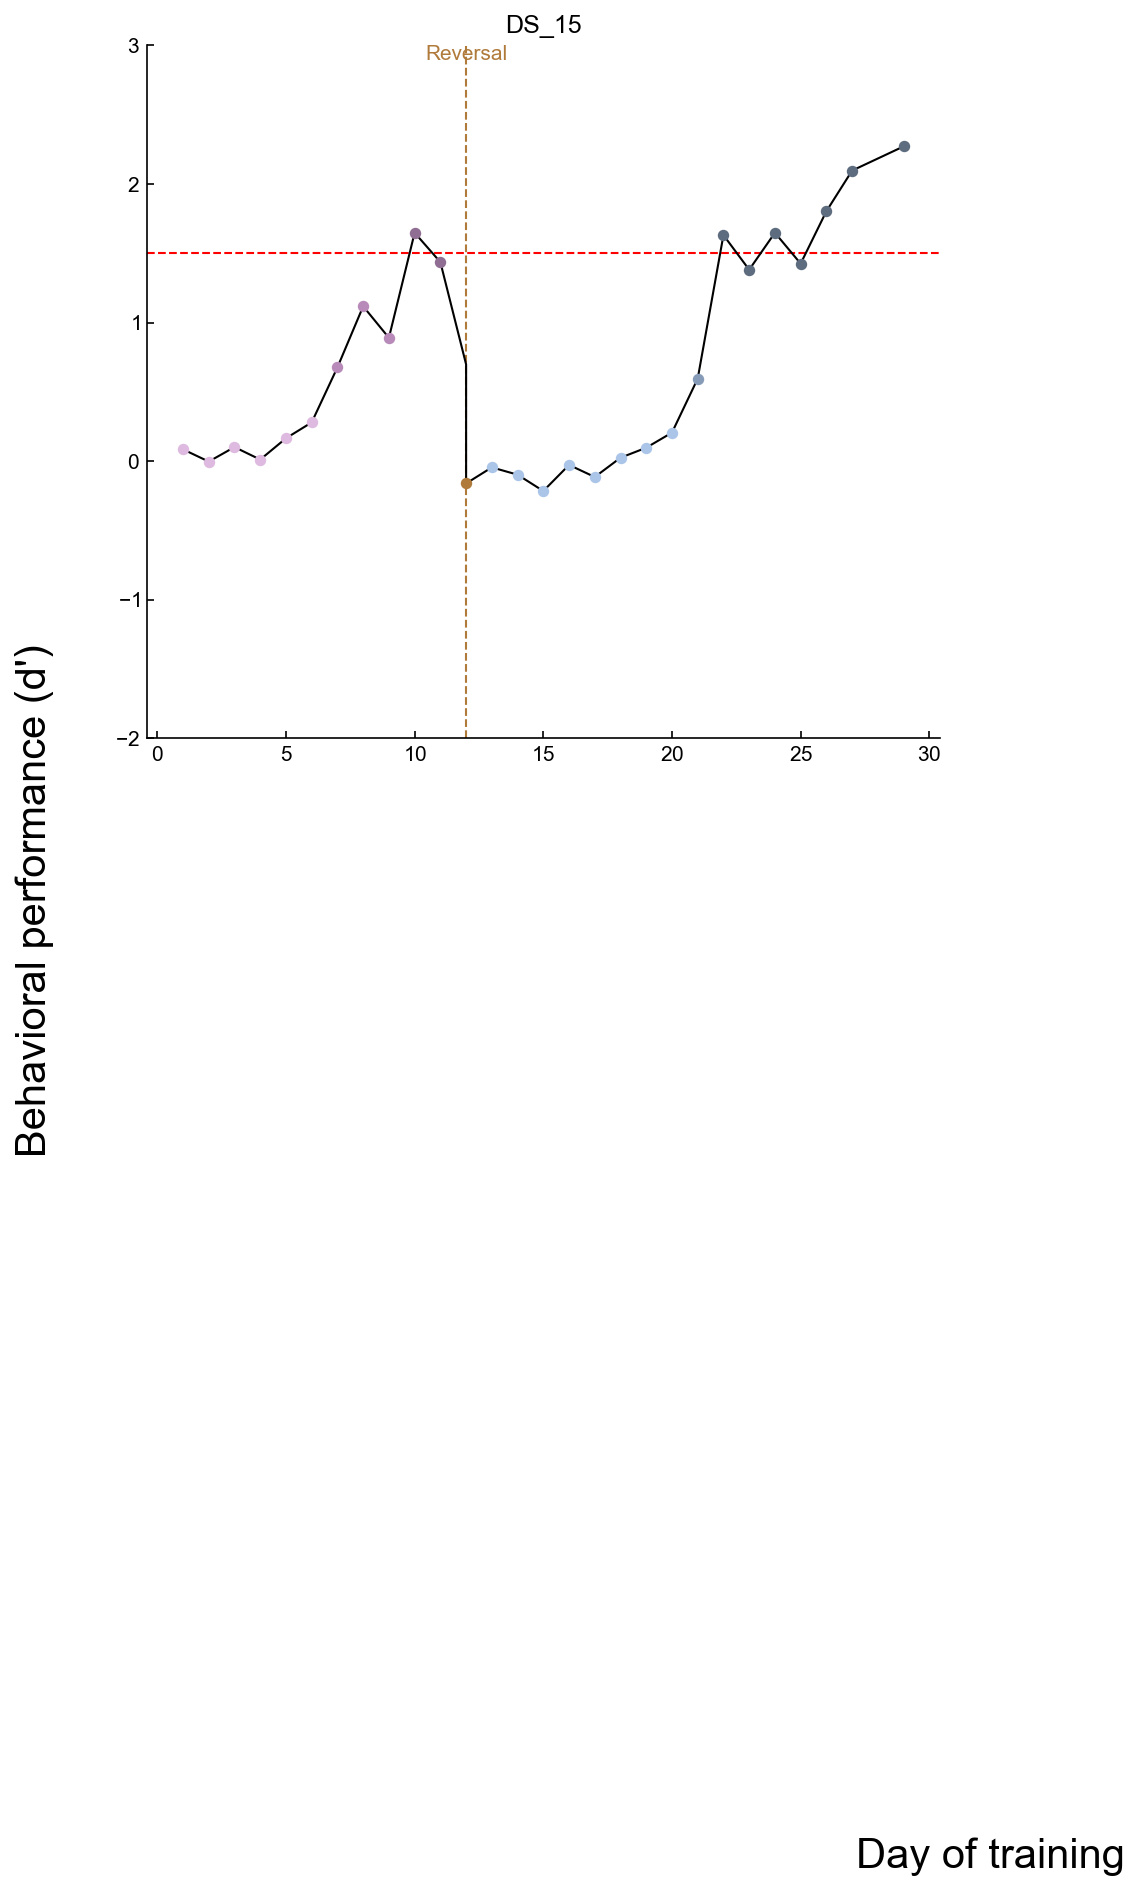

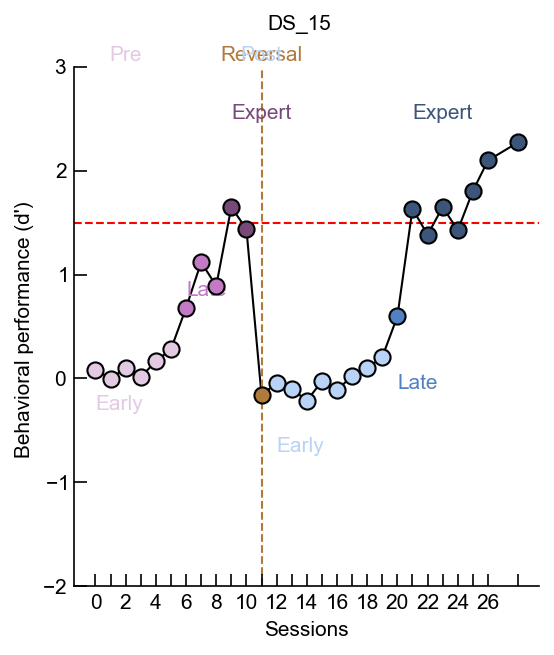

posx and posy should be finite values
posx and posy should be finite values


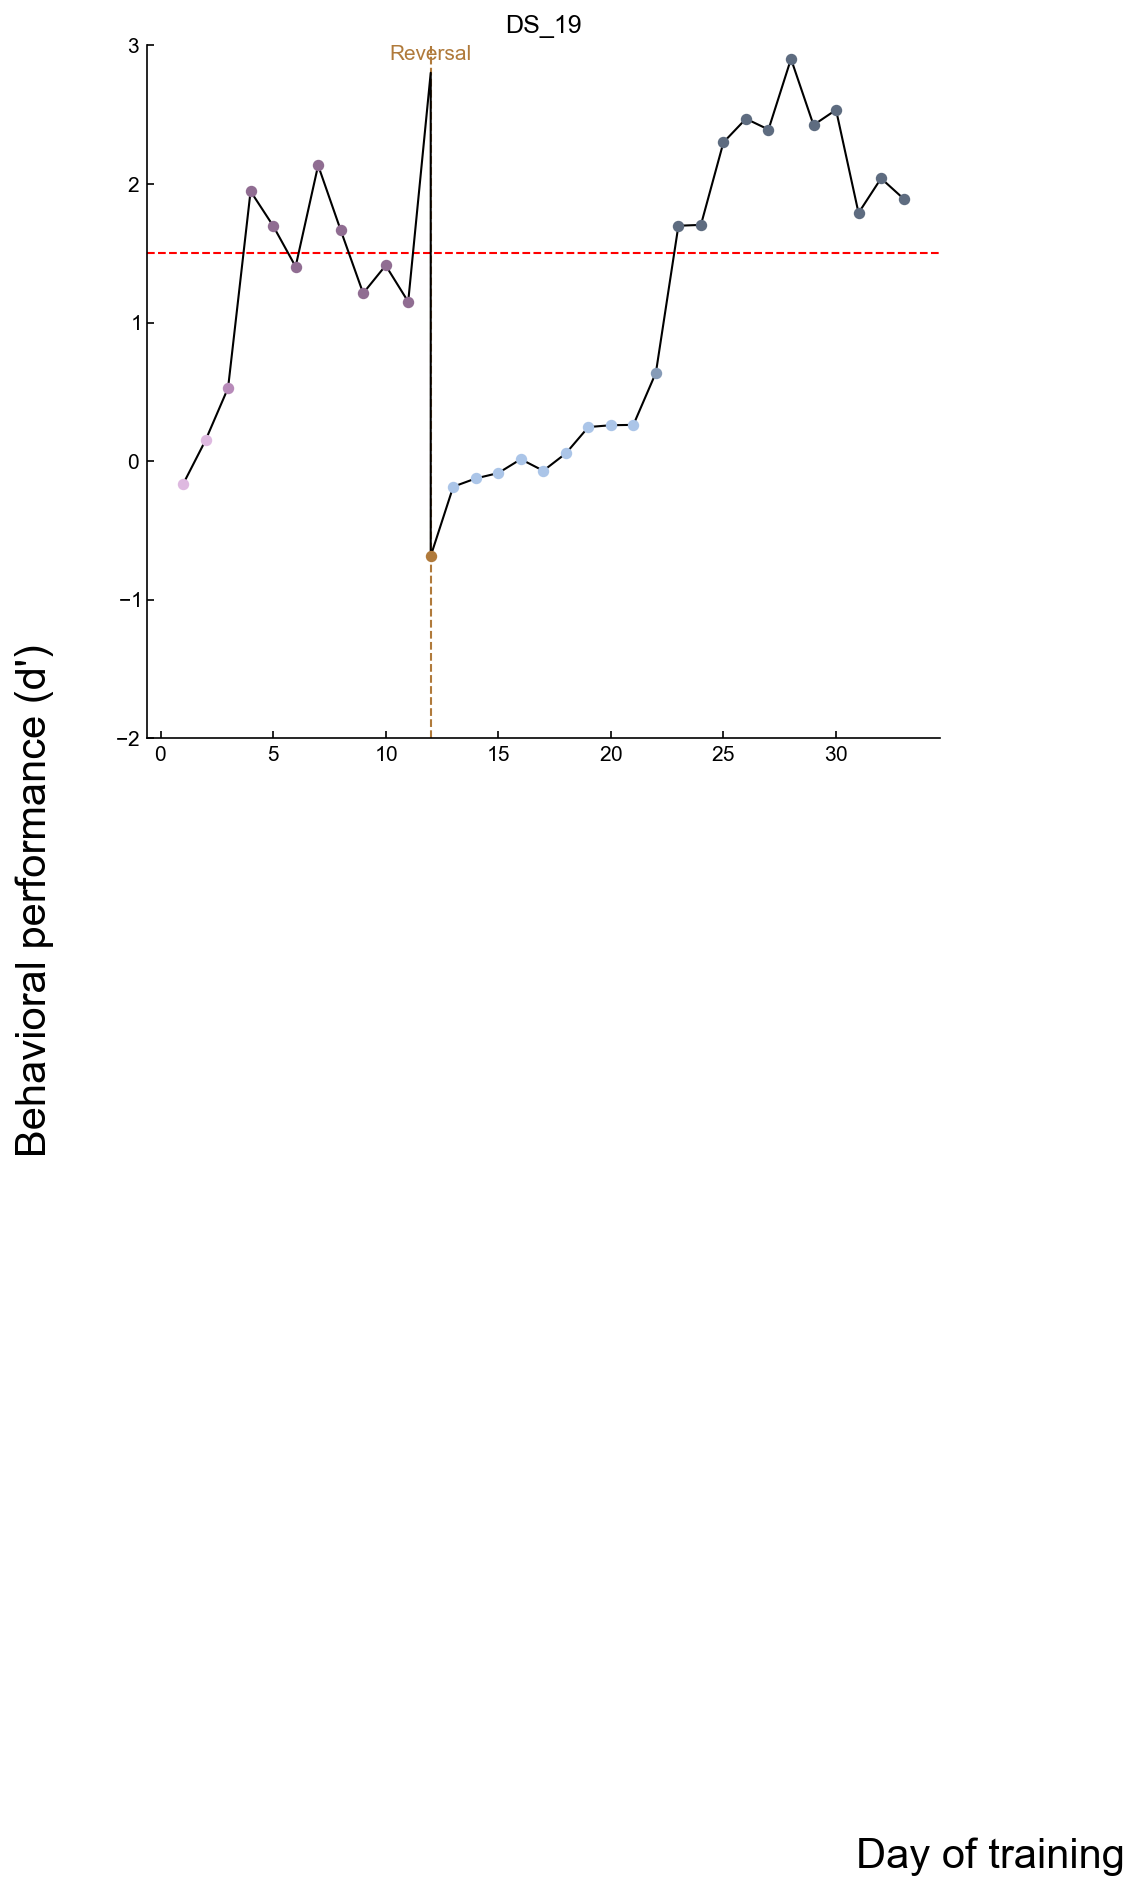

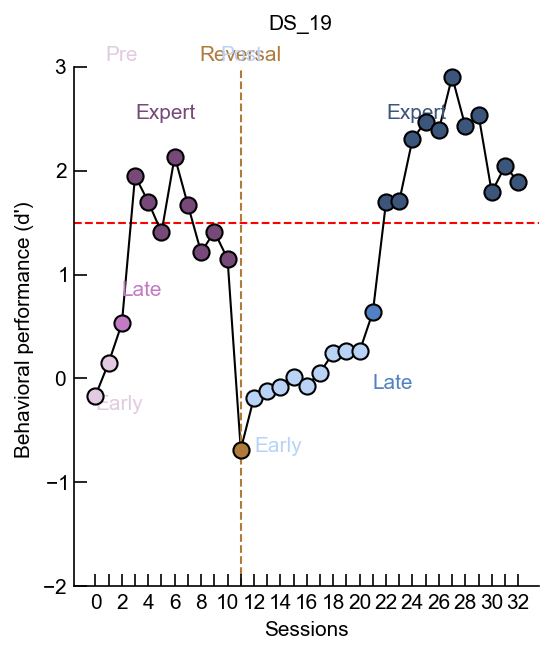

In [234]:
for animal in animallist:
    plotLearningCurve(animal)